# Libraries

In [23]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

from stats import  full_permutation_mean_diff, standardize_data, permutation_expected_mean_difference, get_descriptive_statistics
from stats import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from statsmodels.stats import multitest

In [3]:
import warnings
warnings.filterwarnings("ignore")

# strategies

Перед тем, как сравнивать частоту употребления стратегий в группах, стоит убедиться, что нету для каждой из стратегий зависимости между тем, сколько человек сказал слов


In [93]:
strats_ = pd.read_csv('strategies_fractions.tsv', sep='\t')

strats_['derivative strategy'] = strats_['derivative strategy']*100
strats_['individual association strategy'] = strats_['individual association strategy']*100
strats_['phonetic strategy'] = strats_['phonetic strategy']*100
strats_['semantic-field strategy'] = strats_['semantic-field strategy']*100
strats_.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,22.727273,11.363636,29.545455,36.363636,senior academics
1,pr_B_1,19.607843,5.882353,31.372549,43.137255,senior academics
2,pr_E_1,9.615385,1.923077,19.230769,69.230769,senior academics
3,pr_G_1,25.454545,1.818182,12.727273,60.000000,senior academics


In [5]:
strats = pd.read_csv('strategies_counts.tsv', sep='\t')
strats.head(4)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics
1,pr_B_1,10.0,3.0,16.0,22,51.0,senior academics
2,pr_E_1,5.0,1.0,10.0,36,52.0,senior academics
3,pr_G_1,14.0,1.0,7.0,33,55.0,senior academics


<Axes: xlabel='strat_sum', ylabel='phonetic strategy'>

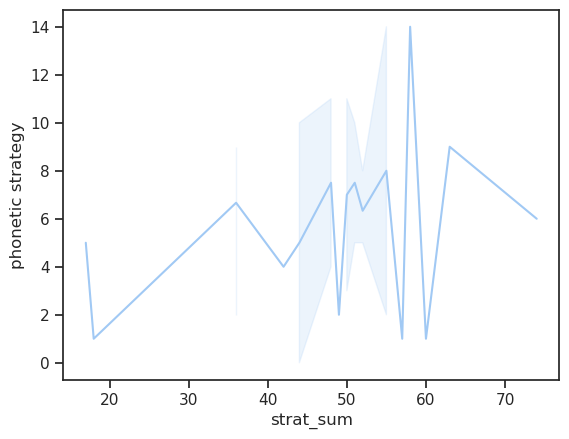

In [6]:
sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='phonetic strategy')

<Axes: xlabel='phonetic strategy', ylabel='Count'>

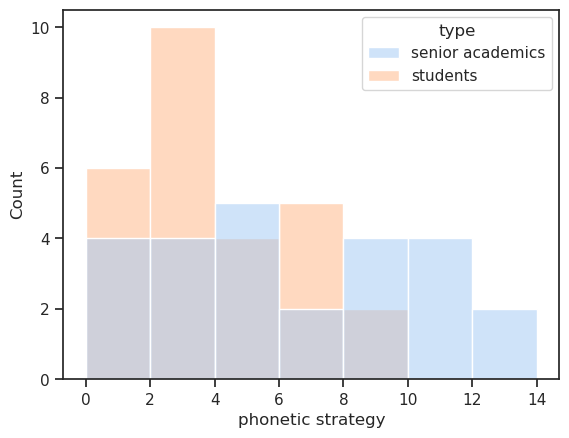

In [7]:
# sns.lineplot(strats[strats['type']=='senior academics'], x='strat_sum', y='fonetics');
sns.histplot(strats, x='phonetic strategy',hue='type')

количество сказанных слов
## 

In [8]:
res = stats.normaltest(strats[strats['type']!='senior academics']['strat_sum'])
res

NormaltestResult(statistic=9.419724139375617, pvalue=0.009006019699880572)

Наблюдаемая разница средних (стандартизированная): -0.33461976839439533
p-значение: 0.538
Доверительный интервал (95%): [-0.85011319  0.20036297]


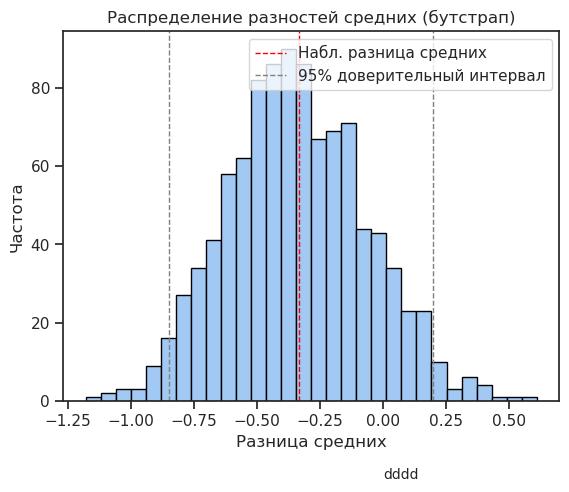

Разница средних при t-тесте (стандартизированная): -0.33461976839439533
p-значение при t-тесте: 0.23155025194351794


In [ ]:
# 1. Стандартизация данных
def standardize_data(df, column):
    mean = df[column].mean()
    std = df[column].std()
    df[column + '_standardized'] = (df[column] - mean) / std
    return df

strats = standardize_data(strats, 'strat_sum')


# 2. Бутстрап для сравнения стандартизированных средних
def permutation_mean_difference(group1, group2, num_iterations=1000):
    mean_diffs = []
    n1 = len(group1)
    n2 = len(group2)

    for _ in range(num_iterations):
        # Сэмплирование с возвращением
        sample1 = np.random.choice(group1, size=n1, replace=True)
        sample2 = np.random.choice(group2, size=n2, replace=True)
        mean_diff = np.mean(sample1) - np.mean(sample2)
        mean_diffs.append(mean_diff)

    return np.array(mean_diffs)

# Выбираем стандартизированные данные
group1 = strats[strats['type'] != 'senior academics']['strat_sum_standardized'].values
group2 = strats[strats['type'] == 'senior academics']['strat_sum_standardized'].values


mean_diffs_permutation = permutation_mean_difference(group1, group2)

# Вычисляем p-value и доверительный интервал
observed_diff = np.mean(group1) - np.mean(group2)
p_value = np.mean(np.abs(mean_diffs_permutation) >= np.abs(observed_diff))
ci = np.percentile(mean_diffs_permutation, [2.5, 97.5])


# Вывод результатов
print("Наблюдаемая разница средних (стандартизированная):", observed_diff)
print("p-значение:", p_value)
print("Доверительный интервал (95%):", ci)

# Строим гистограмму распределения разностей средних
plt.hist(mean_diffs_permutation, bins=30, edgecolor='black')
plt.axvline(observed_diff, color='red', linestyle='dashed', linewidth=1, label=f'Набл. разница средних')
plt.axvline(ci[0], color='grey', linestyle='dashed', linewidth=1, label=f'95% доверительный интервал')
plt.axvline(ci[1], color='grey', linestyle='dashed', linewidth=1)
plt.title('Распределение разностей средних (бутстрап)')
plt.xlabel('Разница средних')
plt.ylabel('Частота')
plt.text(0, -20, 'dddd', fontsize=10)
plt.legend()
plt.show()


# Сравнение с t-тестом (для сравнения) - выводим только p-value и разницу средних
t_stat, p_value_ttest = stats.ttest_ind(group1, group2)
print("Разница средних при t-тесте (стандартизированная):", np.mean(group1) - np.mean(group2))
print("p-значение при t-тесте:", p_value_ttest)


между группами академиков и студентов принята гипотеза об отсутствии разницы между средними количества сказанных слов

In [46]:
stats.ttest_ind(strats[strats['type']!='senior academics']['strat_sum'], strats[strats['type']=='senior academics']['strat_sum'])

TtestResult(statistic=-1.2111004152791622, pvalue=0.23155025194351778, df=50.0)

## доказать независимость частот с определенной стратегией от количества сказанных слов

### 
доказать независимость частот со стратегией "фонетика" от количества сказанных слов

In [47]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.pearsonr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.pearsonr(x, y)
print(res_exact.pvalue, res_asymptotic.pvalue) # asymptotic pvalue is too low
print(res_exact)

0.9958 0.9871247655788858
PermutationTestResult(statistic=0.002293610595479009, pvalue=0.9958, null_distribution=array([ 0.07155107, -0.0583658 , -0.12828325, ..., -0.06089014,
       -0.18877559,  0.00522393]))


In [48]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.spearmanr(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.spearmanr(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.241, 0.2388697933525074)

In [49]:
res_exact

PermutationTestResult(statistic=0.1662353346648563, pvalue=0.241, null_distribution=array([-0.08825235, -0.07524449, -0.27175305, ..., -0.07049491,
        0.02342699, -0.09178244]))

In [50]:
x=strats['phonetic strategy']/strats['strat_sum']
y=strats['strat_sum']
def statistic(x): # permute only `x`
    return stats.kendalltau(x, y).statistic
res_exact = stats.permutation_test((x,), statistic,
    permutation_type='pairings')
res_asymptotic = stats.kendalltau(x, y)
res_exact.pvalue, res_asymptotic.pvalue # asymptotic pvalue is too low

(0.2662, 0.26786173211226616)

In [51]:
res_exact

PermutationTestResult(statistic=0.10811355574641349, pvalue=0.2662, null_distribution=array([ 0.02934511, -0.11043027, -0.08726308, ..., -0.0973022 ,
       -0.00231672, -0.05096782]))

не отвергаем нулевую гипотезу, частота сказанных слов со стратегией фонетика не коррелирует со общим количеством сказанных слов

Более того, в этой связи есть линейность?

(0.0, 15.0)

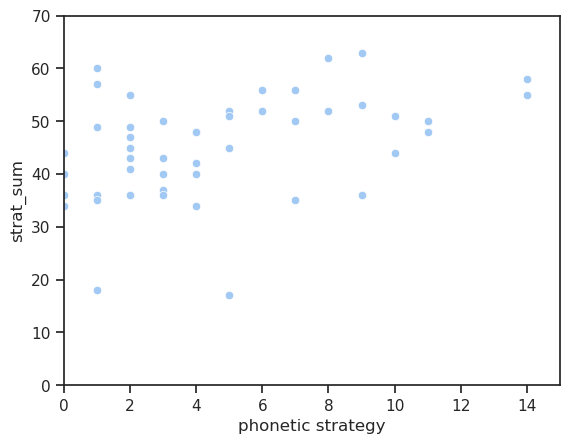

In [52]:
sns.scatterplot(strats, y='strat_sum', x='phonetic strategy');
plt.ylim(0,70)
plt.xlim(0,15)

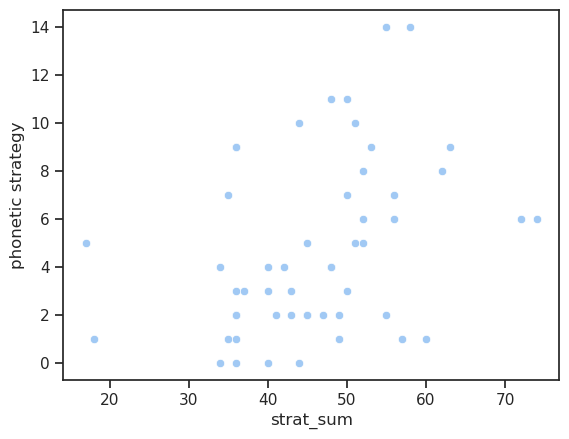

In [53]:
sns.scatterplot(strats, y='phonetic strategy', x='strat_sum');
# plt.ylim(0,70)
# plt.xlim(0,15)

поэтому не стоит сравнивать количества сказанных слов со стратегией фонетика напрямую, их надо нормализовывать по количеству сказанных слов

или стоит?? стоит, потому что на графике не видно связи, точки разбросаны

### 
доказать независимость частот со стратегией "лексика" от количества сказанных слов

In [54]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

## 
сравнение количества слов по стратегиям между группами

In [55]:
strats.head(1)

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,strat_sum,type,strat_sum_standardized
0,pr_A_1,10.0,5.0,13.0,16,44.0,senior academics,-0.180984


In [56]:
strats.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy',
       'strat_sum', 'type', 'strat_sum_standardized'],
      dtype='object')

In [ ]:
# full_permutation_mean_diff(strats, 'strat_sum')
full_permutation_analysis(strats, 'strat_sum')

Статистика Хи-квадрат: 1.0642870890770864e-27
P-значение: 1.0
Observed difference (standardized): -0.33461976839439533
CI for observed difference [-2.3247844257211616, 1.6555448889323707]
Cohen's d (effect size): -0.3295479816901048
Expected mean diffs are normal distributed
T-student p_value: 0.2349
Нормальность средних разниц: p=0.1697
Хи квадрат дисперсии разниц: p=1.0000
P-значение для разницы средних: 0.2218
П-значение для разницы дисперсий: 0.2142
Доверительный интервал для средней разницы H0: (-0.5428, 0.5385)
Эффект (Cohen's D): -0.3295


(array([ 0.05255246,  0.25914263, -0.01729405, ..., -0.1280296 ,
         0.16596926,  0.12601866]),
 True,
 (-0.5428220383506075, 0.5385320413199101),
 -0.33461976839439533,
 -0.3295479816901048,
 0.2218,
 -1.1978617840547632,
 0.2348765123487651)

принимаем нулевую гипотезу об отсутствии различий в среднем количестве сказанных слов

In [58]:
strategies_list = ['phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy']

In [ ]:
# pval = []
# es = []
# for i in strategies_list:
#     print (i)
#     mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d = full_permutation_analysis(strats, i)
#     # ci, p_value, observed_diff, mdelta, cohens_d = full_permutation_mean_diff(strats, i)
#     pval.append(p_value_mean)
#     es.append(cohens_d)
#     print('______________')
    

In [20]:
strategies_list
#ofld

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [21]:
pval

[0.0095, 0.911, 0.0022, 0.0843]

In [22]:
es

[-0.7398906246454715,
 -0.030915484095687527,
 -0.9162600429636434,
 0.47685591304288694]

In [40]:
# plt.text(2.7, 257.5, f"ES = {es[3]:.1f}", rotation = 0, fontsize = 11
#          )       

# plt.text(2.7, 240, f"p value = {pval[3]:.3f}", rotation = 0, fontsize = 11 
#          )      

In [41]:
int(3/2)

1

In [14]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(10, 12), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats, y=i, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j%2][int(j/2)]
#                      );
    
#     ax.set_xlabel(f'Strategy "{i}"')

#     ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)

#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# plt.tight_layout()
# plt.show();

## сравнение фракций для каждой стратегии между группами!!!

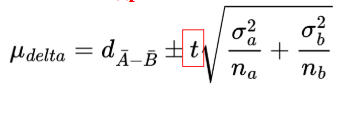

In [7]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [8]:
strategies_dict = {'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy' : 'S3',
 'individual association strategy' : 'S4'}

# S1. Phonetic strategy

# S2. Derivative strategy

# S3. Semantic-field strategy

# S4. Individual association strategy

In [119]:
paper_table = pd.DataFrame(columns=['Variable', 'Normal sampling distribution', 'H0 CI', 'Delta observed' ,'Cohens delta'
                                    , 'Permutation test p value'
                                    , 'Permutation test p value corrected'
                                    , 'Stat metric value'
                                    , 'Stat p value'
                                    , 'Stat p value corrected'
                                    ])
paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Permutation test p value,Permutation test p value corrected,Stat metric value,Stat p value,Stat p value corrected


In [120]:
desc_stats = pd.DataFrame(columns=['Variable', 'type/group', 'Expected mean diffs are normal distributed'
                          , 'mean'
                          , 'std'
                          , 'median'
                          , 'Q1'
                          , 'Q3'
                          ])

phonetic strategy
Статистика Хи-квадрат: 2.312113837352973e-27
P-значение: 1.0
Observed difference (standardized): -5.708276654656701
CI for observed difference [-20.337103192774567, 8.920549883461163]
Cohen's d (effect size): -0.7648065423412016
Expected mean diffs are normal distributed
T-student p_value: 0.007299
Нормальность средних разниц: p=0.8001
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0
П-значение для разницы дисперсий: 0.0004
Доверительный интервал для средней разницы H0: (-3.001, 3.009)
Эффект (Cohen's D): -0.7648


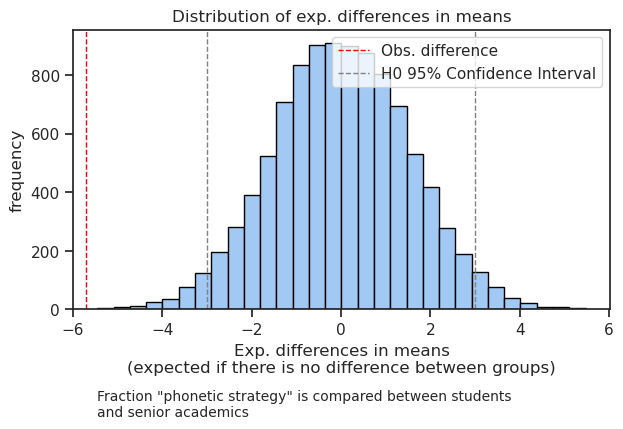

______________
derivative strategy
Статистика Хи-квадрат: 4.1005581660356534e-27
P-значение: 1.0
Observed difference (standardized): 1.2137035696691862
CI for observed difference [-14.822311998291706, 17.249719137630077]
Cohen's d (effect size): 0.14834476721913634
Expected mean diffs are normal distributed
T-student p_value: 0.6172
Нормальность средних разниц: p=0.2851
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.445
П-значение для разницы дисперсий: 0.0013
Доверительный интервал для средней разницы H0: (-3.065, 3.104)
Эффект (Cohen's D): 0.1483


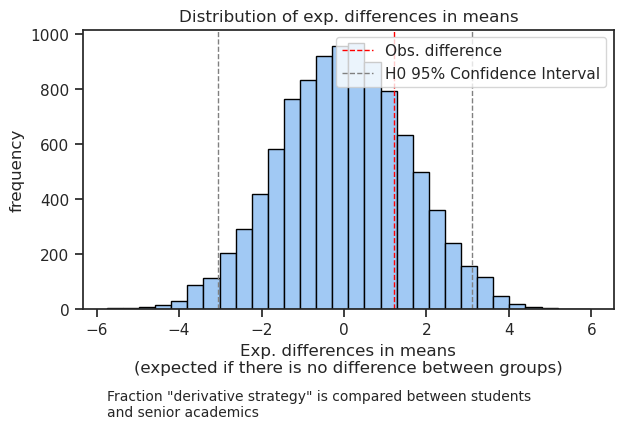

______________
semantic-field strategy
Статистика Хи-квадрат: 2.6912918929955235e-27
P-значение: 1.0
Observed difference (standardized): -7.244310423540831
CI for observed difference [-23.37177538746286, 8.883154540381199]
Cohen's d (effect size): -0.8804141544814132
Expected mean diffs are normal distributed
T-student p_value: 0.0031
Нормальность средних разниц: p=0.2856
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0
П-значение для разницы дисперсий: 0
Доверительный интервал для средней разницы H0: (-3.38, 3.294)
Эффект (Cohen's D): -0.8804


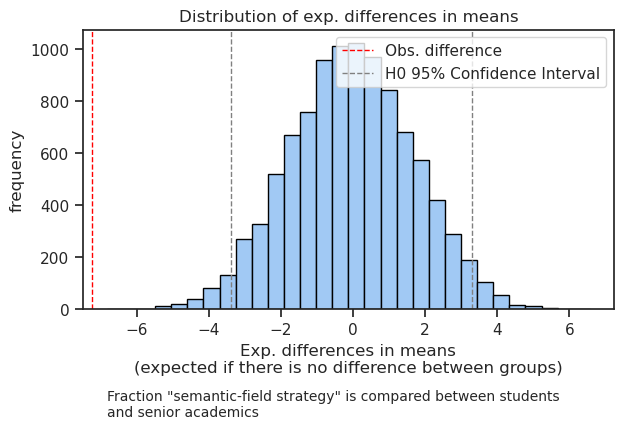

______________
individual association strategy
Статистика Хи-квадрат: 1.981567815430445e-28
P-значение: 1.0
Observed difference (standardized): 11.738883508528339
CI for observed difference [-11.88541005634017, 35.36317707339685]
Cohen's d (effect size): 0.9739216799663742
Expected mean diffs are normal distributed
T-student p_value: 0.0011
Нормальность средних разниц: p=0.2145
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0
П-значение для разницы дисперсий: 0.0062
Доверительный интервал для средней разницы H0: (-5.219, 5.04)
Эффект (Cohen's D): 0.9739


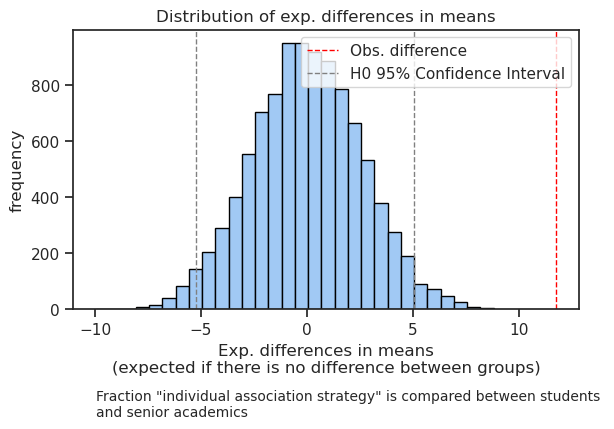

______________


In [121]:
pval = []
# es = []
pval_st = []
normality = []
for i in strategies_list:
    print (i)
    # mean_diffs, var_diffs, t_stats, p_value_mean, p_value_var, ci_mean, cohens_d, pst = full_permutation_analysis(strats_, i)
    # p_value_mean, normal, pst = full_permutation_analysis(strats_, i)
    # ci, p_value, observed_diff, mdelta, cohens_d = full_permutation_mean_diff(strats, i)
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_permutation_analysis(strats_, i)
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Fraction ")
    paper_table.loc[len(paper_table)] = [f'Fraction of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.4g}'), 0, round(Crit_metric, 2), float(f'{pst:.4g}'), 0]
    temp_ds = get_descriptive_statistics(df = strats_, col = i, varname=f'Fraction of {i}', type_col="type"
                                         , senior_type="senior academics", normal=normal)
    desc_stats = pd.concat([desc_stats, temp_ds])

    
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table['Permutation test p value corrected'] = pval
paper_table['Stat p value corrected'] = pval_st

In [27]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_permutation_mean_diff(strats_, i,num_it=10000)
#     pval.append(p_value)
#     es.append(cohens_d)

In [122]:
strategies_dict

{'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy': 'S3',
 'individual association strategy': 'S4'}

In [123]:
strats_.head()

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,22.727273,11.363636,29.545455,36.363636,senior academics
1,pr_B_1,19.607843,5.882353,31.372549,43.137255,senior academics
2,pr_E_1,9.615385,1.923077,19.230769,69.230769,senior academics
3,pr_G_1,25.454545,1.818182,12.727273,60.000000,senior academics
4,pr_I_1,8.333333,2.083333,18.750000,70.833333,senior academics


In [99]:
strats_.columns

Index(['ID', 'phonetic strategy', 'derivative strategy',
       'semantic-field strategy', 'individual association strategy', 'type'],
      dtype='object')

In [100]:
boxpl_strats = strats_[['type', 'ID',
       'phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy']].melt(id_vars=['type', 'ID'], value_vars=['phonetic strategy', 'derivative strategy',
       'semantic-field strategy',
       'individual association strategy'])

In [101]:
boxpl_strats['Strategy'] = boxpl_strats['variable'].apply(lambda x: strategies_dict.get(x
                                                                                        )
                                                            )
# boxpl_strats['value'] = boxpl_strats['value']

In [102]:
boxpl_strats.sort_values(['type', 'Strategy'])

,type,ID,variable,value,Strategy
0,senior academics,pr_A_1,phonetic strategy,22.727273,S1
1,senior academics,pr_B_1,phonetic strategy,19.607843,S1
2,senior academics,pr_E_1,phonetic strategy,9.615385,S1
3,senior academics,pr_G_1,phonetic strategy,25.454545,S1
4,senior academics,pr_I_1,phonetic strategy,8.333333,S1
...,...,...,...,...,...
203,students,Ф_Д_2,individual association strategy,60.000000,S4
204,students,Х_М_3,individual association strategy,68.571429,S4
205,students,Ш_А_26,individual association strategy,67.500000,S4
206,students,Ш_Ю_23,individual association strategy,59.677419,S4


In [103]:
def get_significance(p):
    if p <= 0.001:
        return "***"
    elif p <= 0.01:
        return "**"
    elif p <= 0.05:
        return "*"
    else:
        return "ns"

In [104]:
print(pval_st)
print(pval)

[0.01293204 0.035333   0.00439956 0.00439956]
[4.000e-04 4.403e-01 0.000e+00 0.000e+00]


In [105]:
# boxpl_strats[boxpl_strats['Strategy']=='S3']

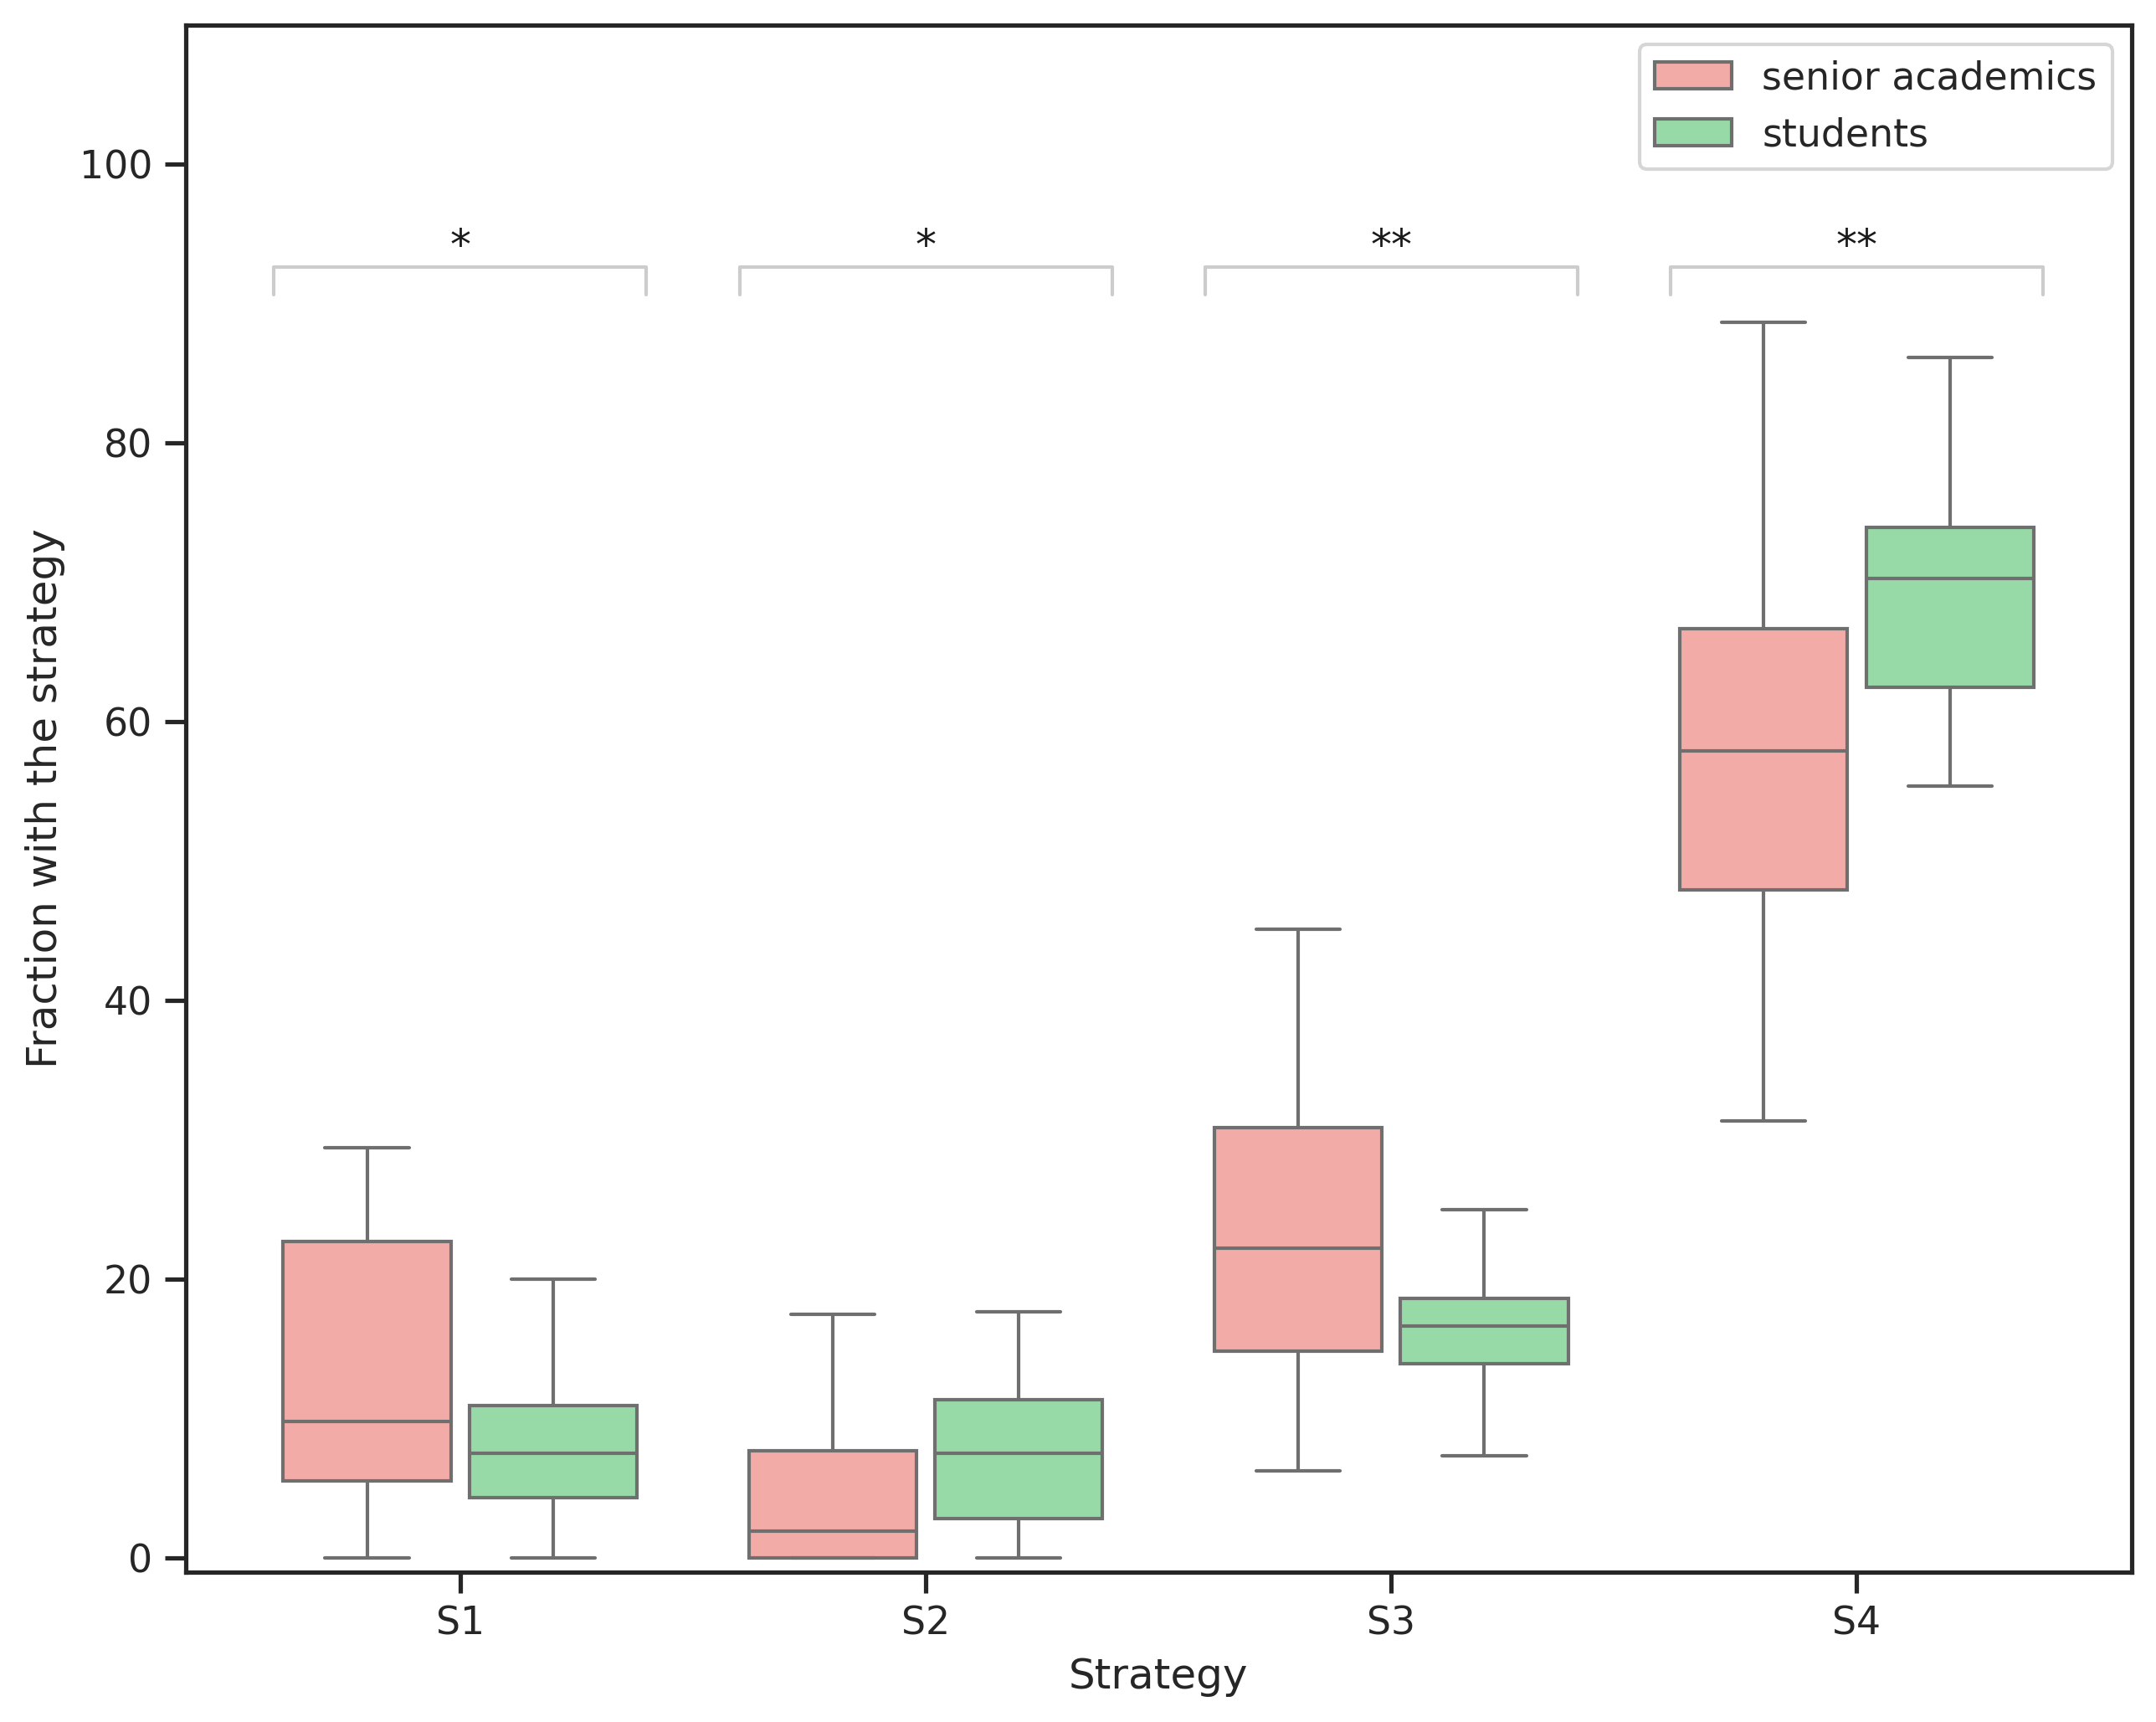

In [106]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
g = sns.boxplot(data = boxpl_strats.sort_values(['type', 'Strategy']), gap=0.1
                , x='Strategy',y='value', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
plt.xlabel('Strategy')
plt.ylabel('Fraction with the strategy')
# plt.title(f'Strategy Use by Group: Senior Academics vs. Students')
plt.ylim(-1, 110)

# statistical annotation
for i in range(4):
    x1, x2 =(i-1)+0.6, i+0.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = boxpl_strats['value'].max() + 2, 2, 'k'
    ptext = get_significance(pval_st[i])
    plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='0.8')
    plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color=col)




g.legend( bbox_to_anchor=(1, 1))
plt.show()

# for i in range(len(normality)):
#       g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       if pval_st[i]<=0.05:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected \n(t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       else:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected \n(M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value corrected \n(permutation)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    

fig.savefig(f'figures/Strategy Use by Group: Senior Academics vs. Students.png', bbox_inches='tight')
# Figure 3

In [ ]:
# sns.set_theme(style="ticks", palette="pastel");
# fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(15, 8), dpi=300)
# j=0
# for i in strategies_list:
    

#     ax = sns.boxplot(strats_, y=strats_[i]*100, x='type', hue='type', palette={'senior academics':'r', 'students':'g'}
#                      ,ax=axs[j]
#                      );
    
#     # ax.set_xlabel(f'Strategy "{i}"',    loc='left')
#     ax.set_title(f'Strategy "{strategies_dict.get(i)}"')
#     ax.set_xlabel('group')

#     # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#     # ax.text(0.02, 1.1, f"ES ({i}) = {es[j]:.2f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     # ax.text(0.02, -0.2, f"T ({i}) = {T:.2f}", ha="left", va="top", transform=ax.transAxes)
#     ax.text(0.02, -0.15, f"p value (t_test with permutation)= {pval_st[j]:.3f}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.20, f"Normal distributed = {str(normality[j])}", ha="left", va="top", transform=ax.transAxes
#             , fontsize =9)
#     ax.text(0.02, -0.1, f"p value (permutation)= {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
#     ax.set_ylim(-1,100)
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     # ax.spines['bottom'].set_visible(False)
#     if j!=0:
#         ax.set(ylabel=None)
#         ax.tick_params(left=False)
#         ax.set(yticklabels=[])
#         ax.spines['left'].set_visible(False)
#     else:
#         ax.set(ylabel= "Fraction with the strategy")
        
#     # ax.text(0, 10.2*y_lim, f"ES = {es[j]:.2f}" )
#     # ax.text(0, 10.15*y_lim, f"p value = {pval[j]:.3f}" )
#     j+=1


# # plt.xlabel('group')
# # plt.title(f'Strategies between groups')
# fig.suptitle("Strategy Use by Group: Senior Academics vs. Students", fontsize="x-large")
# fig.text(0.06, -0.04, "Fraction = (words count with Si strategy)/(words count) * 100")
# plt.tight_layout()
# plt.show();

# Words

In [37]:
words = pd.read_csv('words.tsv', sep='\t')

df = words.fillna('0')
# df['Стратегия'] = df['Стратегия'].str[0]
# def renamestrats(row):
#     '''
#     df['phonetic strategy'] = df['1'] 
#     df['derivation'] = df['2']
#     df['lexico-semantic field'] = df['3'] + df['4'] + df['5'] + df['6'] + df['7']
#     df['other'] = df['8']

#     '''
    
    
#     stratsfict = {'1':'fonetics', '2': 'derivation', 
#                   '8':'other', **dict.fromkeys(['n', '0'], 'None')
#                   }
#     stratsfict.update(dict.fromkeys(['3', '4', '5', '6', '7'], 'lexico-semantic field'))
#     #print(stratsfict[row['Стратегия']])
#     row['strategy_name']=stratsfict[row['Стратегия']]
#     return row

# df = df.apply(renamestrats, axis=1)
df['frequency'] = df['frequency'].astype('float', errors = 'ignore')
df['pause'] = df['pause'].astype('float', errors='ignore' )
df.head()

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,0,п,0,1.0,1,152.7,...,0,0,59,28,13,18,2.390357,students,0,0
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,0,0,59,28,13,18,2.390357,students,individual association strategy,S4
2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,13.2,...,1.0,0,59,28,13,18,2.390357,students,phonetic strategy,S1
3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,12.7,...,1.0,0,59,28,13,18,2.390357,students,individual association strategy,S4
4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,5786.7,...,0,0,59,28,13,18,2.390357,students,semantic-field strategy,S3


In [38]:
df[df['strategy_name']=='individual association strategy'][['type','frequency']]

,type,frequency
1,students,204.2
3,students,12.7
5,students,18.5
6,students,16.3
8,students,2.1
...,...,...
2542,senior academics,0.0
2543,senior academics,3.3
2544,senior academics,2.0
2545,senior academics,5.5


In [39]:
# df['frequency'] = pd.to_numeric(df['frequency'].str.replace(',','.'))

In [40]:
cols = df.select_dtypes('number').columns  # limits to a (float), b (int) and e (timedelta)
df_sub = df.loc[:, 'frequency']


# OPTION 1: z-score filter: z-score < 3
#lim = np.abs((df_sub - df_sub.mean()) / df_sub.std(ddof=0)) < 3

# OPTION 2: quantile filter: discard 1% upper / lower values
#lim = np.logical_and(df_sub < df_sub.quantile(0.99, numeric_only=False),
#                     df_sub > df_sub.quantile(0.01, numeric_only=False))

# OPTION 3: iqr filter: within 2.22 IQR (equiv. to z-score < 3)
iqr = df_sub.quantile(0.75) - df_sub.quantile(0.25)
lim = np.abs((df_sub - df_sub.median()) / iqr) < 2.22


# replace outliers with nan
df.loc[:, 'frequency'] = df_sub.where(lim, np.nan)
df = df.reset_index() #важная часть кода
df["frequency"] = df["frequency"].fillna(220)
dfj = df[df['strategy_name'] !='None']

dfj['Word frequency'] = (dfj['frequency'])

In [41]:
dfj['strategy_name'].unique()

array(['0', 'individual association strategy', 'phonetic strategy',
       'semantic-field strategy', 'derivative strategy'], dtype=object)

In [42]:
strategies_list = ['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

In [43]:
# dfj['Pause duration'] = pd.to_numeric(dfj['pause'].str.replace(',','.'))
dfj['Pause duration'] = dfj['pause']

In [44]:
dfjj = dfj[dfj['strategy_name'].isin(strategies_list)]

In [45]:
strategies_list

['phonetic strategy',
 'derivative strategy',
 'semantic-field strategy',
 'individual association strategy']

## Pause duration

S1. Phonetic strategy

S2. Derivative strategy

S3. Semantic-field strategy

S4. Individual association strategy

In [ ]:
# pval = []
# es = []
# for i in strategies_list:
#     ci, p_value, observed_diff, mdelta, cohens_d = full_permutation_mean_diff(strats, i)
#     pval.append(p_value)
#     es.append(cohens_d)
    

In [107]:
dfjj.head()

,index,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,...,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name,Word frequency,Pause duration
1,1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,...,59,28,13,18,2.390357,students,individual association strategy,S4,220.0,0.10
2,2,2,Б_В_10,1,парад,"['период', 'парад']",п,11,3.0,3,...,59,28,13,18,2.390357,students,phonetic strategy,S1,13.2,3.15
3,3,3,Б_В_10,1,предлог,"['парад', 'предлог']",п,8,4.0,4,...,59,28,13,18,2.390357,students,individual association strategy,S4,12.7,1.00
4,4,4,Б_В_10,1,по,"['предлог', 'по']",п,3,5.0,5,...,59,28,13,18,2.390357,students,semantic-field strategy,S3,220.0,0.70
5,5,5,Б_В_10,1,повреждение,"['по', 'повреждение']",п,8,6.0,6,...,59,28,13,18,2.390357,students,individual association strategy,S4,18.5,3.34


In [108]:
sorted(dfjj['strategy_paper_name'].unique())

['S1', 'S2', 'S3', 'S4']

In [109]:
dfj_s = dfjj[['type','Pause duration', 'strategy_paper_name']]

In [49]:
# sns.histplot(dfj_s['Pause duration'])

In [50]:
# dfj_s = dfj_s[dfj_s['Pause duration']<=]

In [110]:
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

In [ ]:
# paper_table.tail(4)['Permutation test p value corrected']=6

In [53]:
idx = paper_table.tail(4).index

In [54]:
idx

Index([0, 1, 2, 3], dtype='int64')

In [55]:
paper_table.index[-4:]

Index([0, 1, 2, 3], dtype='int64')

In [56]:
# pval

In [124]:
paper_table

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Permutation test p value,Permutation test p value corrected,Stat metric value,Stat p value,Stat p value corrected
0,Fraction of phonetic strategy,True,"[-3.0, 3.01]",-5.71,-0.76,0.000,0.000,-2.75,0.007299,0.009732
1,Fraction of derivative strategy,True,"[-3.07, 3.1]",1.21,0.15,0.445,0.445,0.53,0.617200,0.617238
2,Fraction of semantic-field strategy,True,"[-3.38, 3.29]",-7.24,-0.88,0.000,0.000,-3.15,0.003100,0.006199
3,Fraction of individual association strategy,True,"[-5.22, 5.04]",11.74,0.97,0.000,0.000,3.52,0.001100,0.004400


S1
Статистика Хи-квадрат: 2.7613324287346135e-27
P-значение: 1.0
Observed difference (standardized): -0.8563605823068308
CI for observed difference [-7.2783463104533235, 5.565625145839662]
Cohen's d (effect size): -0.2613625773045474
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.0111
Нормальность средних разниц: p=5.854e-09
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.0045
П-значение для разницы дисперсий: 0.0788
Доверительный интервал для средней разницы H0: (-0.5933, 0.6208)
Эффект (Cohen's D): -0.2614


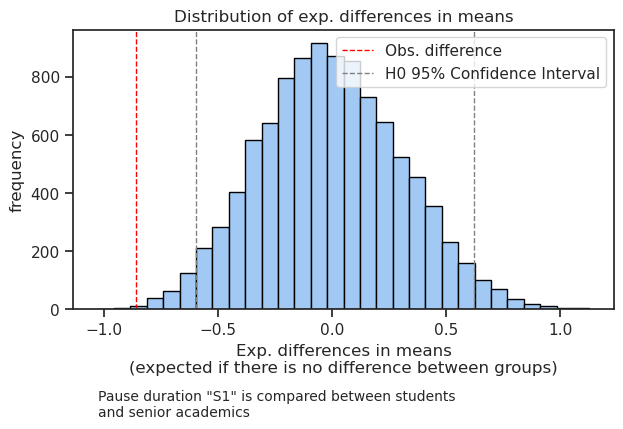

______________
S2
Статистика Хи-квадрат: 4.25462257931559e-27
P-значение: 1.0
Observed difference (standardized): 1.0133695652173913
CI for observed difference [-4.184665096382632, 6.2114042268174146]
Cohen's d (effect size): 0.38210679172629974
Expected mean diffs are not normal distributed
Mann-Whitneyu p_value: 0.01605
Нормальность средних разниц: p=0.03206
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0
П-значение для разницы дисперсий: 0.0004
Доверительный интервал для средней разницы H0: (-0.5485, 0.5418)
Эффект (Cohen's D): 0.3821


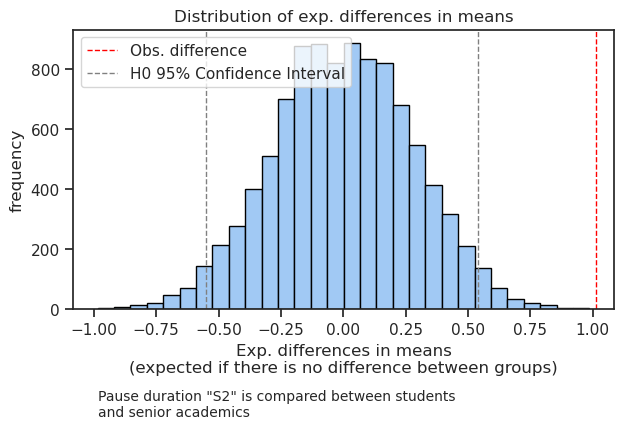

______________
S3
Статистика Хи-квадрат: 3.389682852269111e-27
P-значение: 1.0
Observed difference (standardized): -0.08581137691544516
CI for observed difference [-4.473013847539502, 4.301391093708611]
Cohen's d (effect size): -0.038336570942518716
Expected mean diffs are normal distributed
T-student p_value: 0.6834
Нормальность средних разниц: p=0.3321
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.5646
П-значение для разницы дисперсий: 0.5918
Доверительный интервал для средней разницы H0: (-0.2926, 0.29)
Эффект (Cohen's D): -0.03834


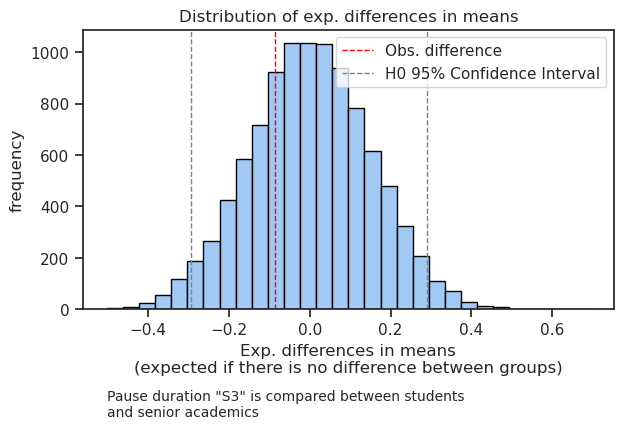

______________
S4
Статистика Хи-квадрат: 3.1846504538035425e-27
P-значение: 1.0
Observed difference (standardized): 0.12719655638328975
CI for observed difference [-5.914084934087107, 6.168478046853686]
Cohen's d (effect size): 0.04126694823019016
Expected mean diffs are normal distributed
T-student p_value: 0.4179
Нормальность средних разниц: p=0.4823
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.2724
П-значение для разницы дисперсий: 0.4551
Доверительный интервал для средней разницы H0: (-0.2207, 0.221)
Эффект (Cohen's D): 0.04127


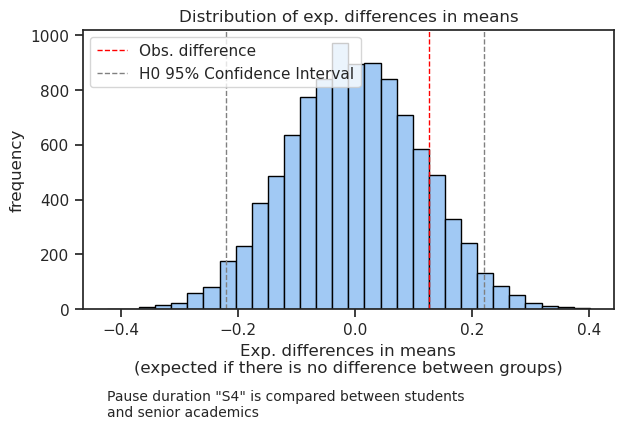

______________


In [126]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = pd.DataFrame(columns=['type','Word frequency', 'Pause duration'])
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_s[dfj_s['strategy_paper_name']==i]
    #
    # p_value_mean, normal, pst = full_permutation_analysis(tempdf, 'Pause duration')
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_permutation_analysis(tempdf, 'Pause duration')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Pause duration ")
    
    paper_table.loc[len(paper_table)] = [f'Pause duration of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.4g}'), 0, round(Crit_metric, 2), float(f'{pst:.4g}'), 0]
    temp_ds = get_descriptive_statistics(df = tempdf, col = 'Pause duration', varname=f'Pause duration of {i}'
                                         , type_col="type"
                                         , senior_type="senior academics", normal=normal)
    desc_stats = pd.concat([desc_stats, temp_ds])

    dfj_boot = pd.concat([dfj_boot, tempdf])
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table.loc[paper_table.index[-4:], 'Permutation test p value corrected'] = pval
paper_table.loc[paper_table.index[-4:], 'Stat p value corrected'] = pval_st


In [127]:
dfj_boot

,type,Word frequency,Pause duration,strategy_paper_name
2,students,NaN,3.15,S1
34,students,NaN,1.30,S1
35,students,NaN,0.54,S1
37,students,NaN,10.98,S1
49,students,NaN,1.29,S1
...,...,...,...,...
2542,senior academics,NaN,7.20,S4
2543,senior academics,NaN,4.55,S4
2544,senior academics,NaN,3.61,S4
2545,senior academics,NaN,3.44,S4


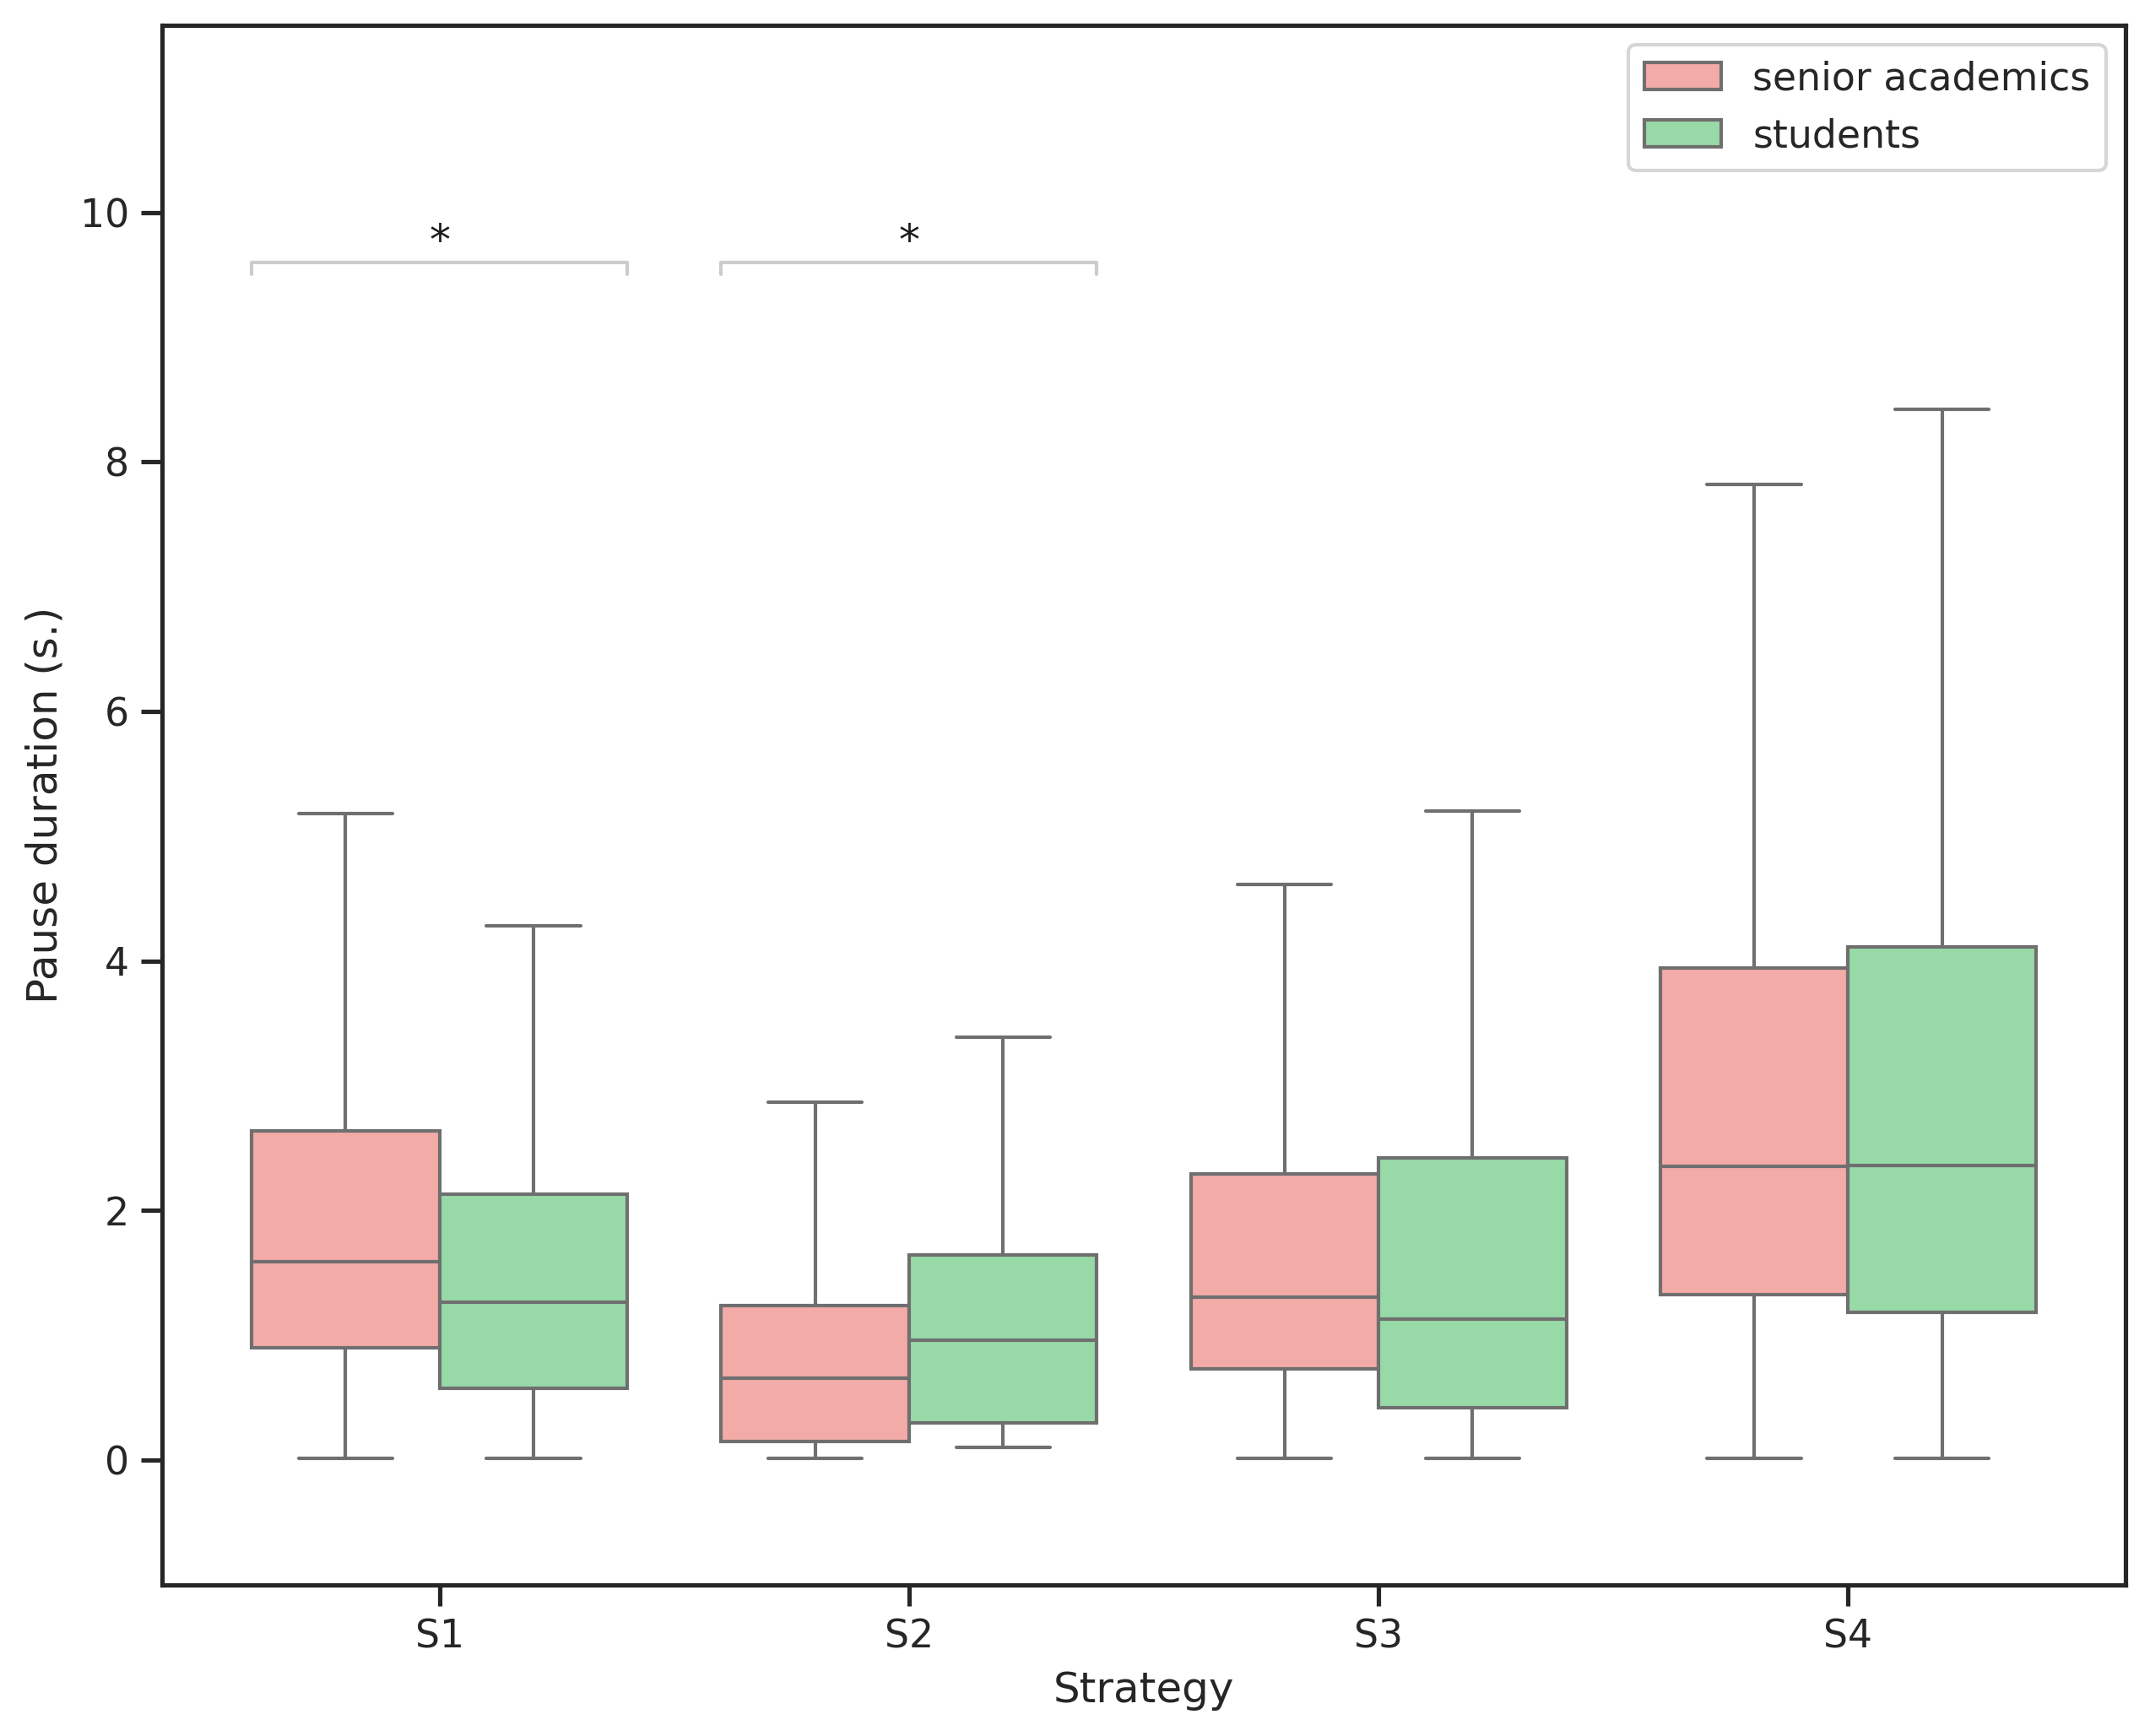

In [128]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['type', 'strategy_paper_name']), x='strategy_paper_name',y='Pause duration', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
xi=11.5
plt.ylim(-1, xi)

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
# for i in range(len(normality)):
#       g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       if normality[i]:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected\n (t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       else:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected\n (M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value corrected\n (permutation)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)

# statistical annotation
for i in range(4):
    x1, x2 =(i-1)+0.6, i+0.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = xi-2, 0.1, 'k'
    ptext = get_significance(pval_st[i])
    if ptext!='ns':
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='0.8')
        plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')
        
g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
plt.ylabel('Pause duration (s.)')
# plt.title('Pause duration by strategy in groups')
# Figure 5
fig.savefig(f'figures/Pause duration by strategy in groups.png', bbox_inches='tight')


In [129]:
dict_for_strategy_names_paper = {'phonetic strategy': 'S1',
                                 'derivative strategy': 'S2',
                                 'semantic-field strategy': 'S3',
                                 'individual association strategy': 'S4'
}

## word frequency

In [ ]:
# # ci, p_value, observed_diff, mdelta_, cohens_d = full_permutation_mean_diff(dfj[['type','Word frequency']], 'Word frequency')
# # dfjj[['type', 'Word frequency', 'strategy_paper_name', 'order_letter']]
# dfjj
# x1 = dfjj[dfjj['type']=='students']['order_whole_test'].values.astype(float)
# y1 = dfjj[dfjj['type']=='students']['Word frequency'].values.astype(float)
# x2 = dfjj[dfjj['type']!='students']['order_whole_test'].values.astype(float)
# y2 = dfjj[dfjj['type']!='students']['Word frequency'].values.astype(float)

# slope, intercept, r, p, stderr = stats.linregress(x1, y1)
# line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
# fig, ax = plt.subplots(dpi=250)
# # ax.set_color_cycle(['green', 'red'])
# ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
# ax.plot(x1, intercept + slope * x1, label=line, color='green')

# slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
# line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
# ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
# ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

# ax.set_xlabel('Word order in letter')
# ax.set_ylabel('Word frequency')
# ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# # plt.tight_layout()

# # ax.legend(facecolor='white')
# plt.show()
# fig.savefig(f'figures/Word order in letter ~ Word frequency.png', bbox_inches='tight')

### **between strategies**

In [130]:
dfj_s = dfjj[['type','Word frequency']]
# full_permutation_mean_diff(dfj_s, 'Word frequency', f'Strategy "{i}".\n')
st_paper_n_list = sorted(dfjj['strategy_paper_name'].unique())
st_paper_n_list

['S1', 'S2', 'S3', 'S4']

S1
Статистика Хи-квадрат: 7.889296459456339e-29
P-значение: 1.0
Observed difference (standardized): 4.481870100783873
CI for observed difference [-145.80867459268237, 154.77241479425012]
Cohen's d (effect size): 0.05844988728634429
Expected mean diffs are normal distributed
T-student p_value: 0.6508
Нормальность средних разниц: p=0.6582
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.538
П-значение для разницы дисперсий: 0.985
Доверительный интервал для средней разницы H0: (-13.95, 14.61)
Эффект (Cohen's D): 0.05845


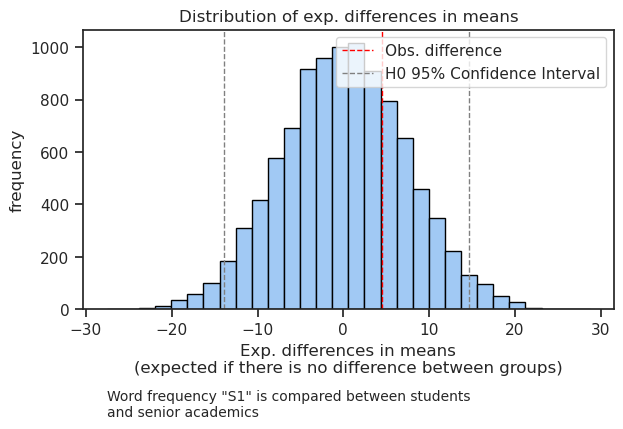

______________
S2
Статистика Хи-квадрат: 4.645583148091776e-28
P-значение: 1.0
Observed difference (standardized): 17.17989130434783
CI for observed difference [-98.07256380647891, 132.43234641517458]
Cohen's d (effect size): 0.2921637280884142
Expected mean diffs are normal distributed
T-student p_value: 0.0451
Нормальность средних разниц: p=0.7937
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.0051
П-значение для разницы дисперсий: 0.1595
Доверительный интервал для средней разницы H0: (-12.07, 12.08)
Эффект (Cohen's D): 0.2922


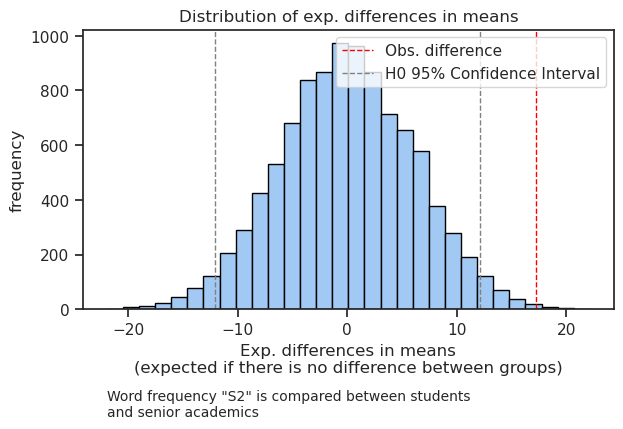

______________
S3
Статистика Хи-квадрат: 3.202500917093053e-27
P-значение: 1.0
Observed difference (standardized): 11.983987799948551
CI for observed difference [-144.71340928170537, 168.68138488160247]
Cohen's d (effect size): 0.14989793401392243
Expected mean diffs are normal distributed
T-student p_value: 0.1083
Нормальность средних разниц: p=0.4335
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.0264
П-значение для разницы дисперсий: 0.2865
Доверительный интервал для средней разницы H0: (-10.57, 10.56)
Эффект (Cohen's D): 0.1499


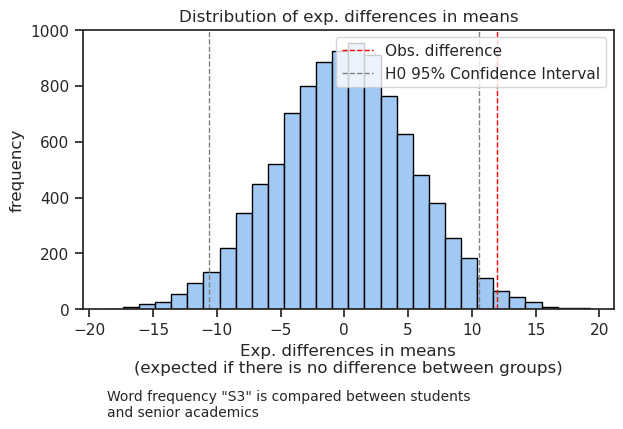

______________
S4
Статистика Хи-квадрат: 1.3822715268179125e-27
P-значение: 1.0
Observed difference (standardized): 9.824443945369552
CI for observed difference [-130.7003323561657, 150.3492202469048]
Cohen's d (effect size): 0.13702857702192942
Expected mean diffs are normal distributed
T-student p_value: 0.008599
Нормальность средних разниц: p=0.3492
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.0001
П-значение для разницы дисперсий: 0.0393
Доверительный интервал для средней разницы H0: (-5.282, 5.314)
Эффект (Cohen's D): 0.137


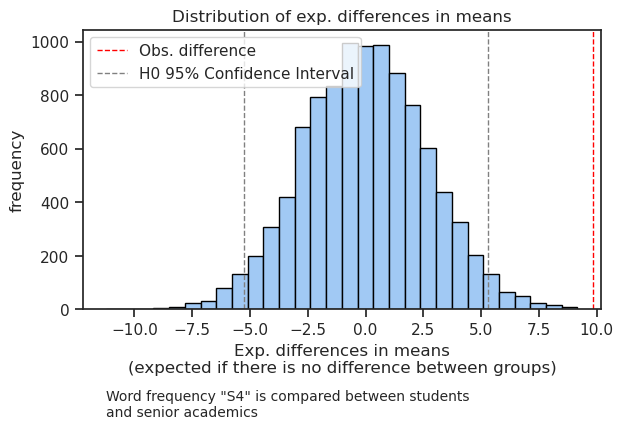

______________


In [134]:
pval = []
# es = []
pval_st = []
normality = []
dfj_boot = dfjj[['type', 'Word frequency', 'strategy_paper_name']]
for i in st_paper_n_list:
    print (i)
    tempdf = dfj_boot[dfj_boot['strategy_paper_name']==i]
    
    mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_permutation_analysis(tempdf, 'Word frequency')
    plot_bresults(mean_expected_diffs, delta, ci_mean, i, text_add="Word frequency ")
    paper_table.loc[len(paper_table)] = [f'Word frequency of {i}', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.3g}'), 0, round(Crit_metric, 2), float(f'{pst:.3g}'), 0]
    temp_ds = get_descriptive_statistics(df = tempdf, col = 'Word frequency', varname=f'Word frequency of {i}'
                                         , type_col="type"
                                         , senior_type="senior academics", normal=normal)
    desc_stats = pd.concat([desc_stats, temp_ds])
    pval.append(p_value_mean)
    # es.append(cohens_d)
    pval_st.append(pst)
    normality.append(normal)
    print('______________')

# fdr correction
pval_st = multitest.fdrcorrection(pval_st)[1]
pval = multitest.fdrcorrection(pval)[1]

paper_table.loc[paper_table.index[-4:], 'Permutation test p value corrected'] = pval
paper_table.loc[paper_table.index[-4:], 'Stat p value corrected'] = pval_st  

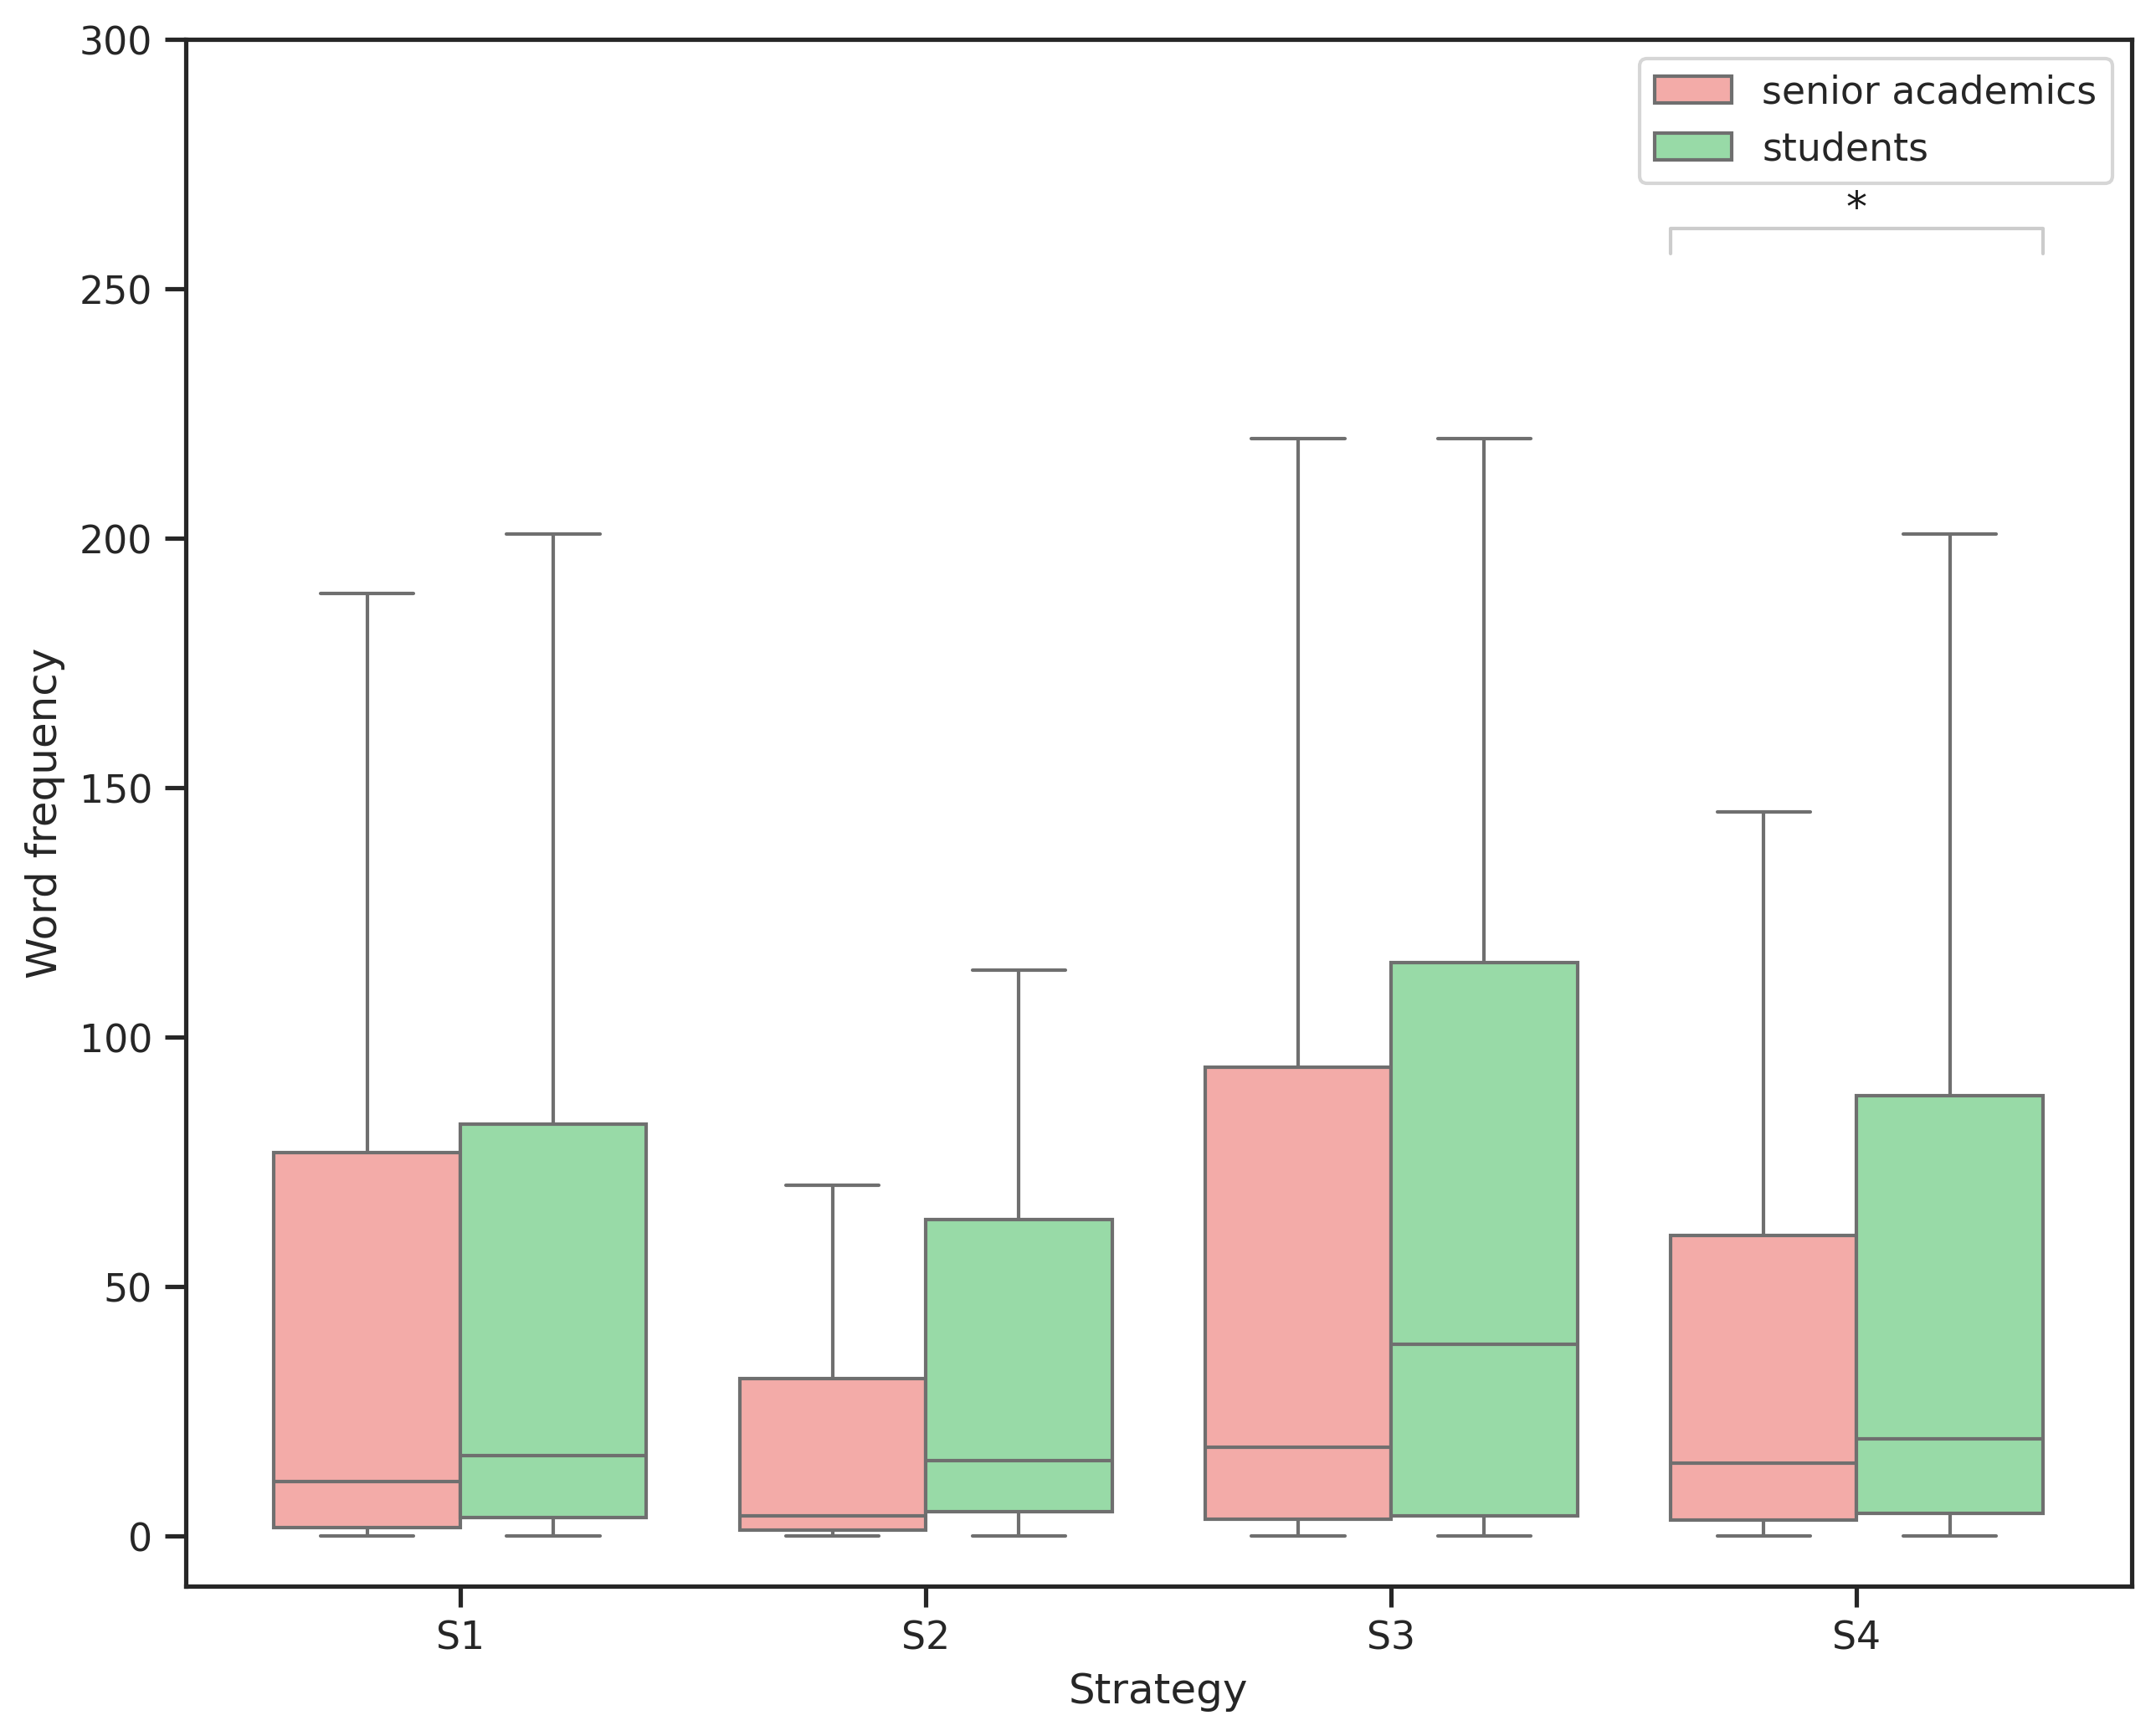

In [135]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = dfj_boot.sort_values(['type', 'strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
xi=300
plt.ylim((-10,xi))

# ax.text(0.02, 1.05, f"p value = {pval[j]:.3f}", ha="left", va="top", transform=ax.transAxes)
# for i in range(len(normality)):
#       g.text(i*0.25+0.05, -0.12, f"Normal distributed = {str(normality[i])}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       if normality[i]:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected\n(t-test with permutation)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       else:
#             g.text(i*0.25+0.05, -0.17, f"p value corrected\n(M-U test)= {pval_st[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value corrected\n(permutation)= {pval[i]:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)

# statistical annotation
for i in range(4):
    x1, x2 =(i-1)+0.6, i+0.4   # columns 'Sat' and 'Sun' (first column: 0, see plt.xticks())
    y, h, col = xi-41-2, 5, 'k'
    ptext = get_significance(pval_st[i])
    if ptext!='ns':
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c='0.8')
        plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')

g.legend( bbox_to_anchor=(1, 1))
plt.xlabel('Strategy')
# plt.title('Word frequency by strategy in groups')
fig.savefig(f'figures/Word frequency by strategy in groups.png', bbox_inches='tight')


In [126]:
# fig = plt.figure(figsize=(10, 6), dpi=300)
# sns.set_theme(style="ticks", palette="pastel")
# g = sns.boxplot(data = dfj_boot.sort_values(['strategy_paper_name']), x='strategy_paper_name',y='Word frequency', hue='type', palette={'senior academics':'r', 'students':'g'}, fliersize=3);
# plt.tight_layout()
# g.legend( bbox_to_anchor=(1.28, 1))
# plt.ylim((-10,270))

# for i in range(len(es)):
#       a = dfj_boot[(dfj_boot['type']!='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       b = dfj_boot[(dfj_boot['type']=='students') & (dfj_boot['strategy_paper_name']==st_paper_n_list[i])]['Word frequency' + '_standardized'].values
#       # T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)
#       T, pst = stats.ttest_ind(a, b, equal_var=False, permutations=10000)

#       g.text(i*0.25+0.05, -0.12, f"ES = {es[i]:.2f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
#       g.text(i*0.25+0.05, -0.17, f"p value = {pval[i]:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
#       g.text(i*0.25+0.05, -0.22, f"p value (t test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
    
# g.legend( bbox_to_anchor=(0.75, 0.85))
# # fig.suptitle('Word frequency by strategy in groups', fontsize=15)
# g.set_title('Word frequency by strategy in groups', fontdict={'fontsize': 15, 'fontweight': 'medium'})
# plt.xlabel('strategy_name')
# plt.show()

## word in tertiles

In [136]:
words = pd.read_csv('words.tsv', sep='\t')
words.head(2)

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,NaN,п,NaN,1.0,1,152.7,...,NaN,NaN,59,28,13,18,2.390357,students,NaN,NaN
1,1,Б_В_10,1,период,"['пара', 'период']",п,8,2.0,2,204.2,...,NaN,NaN,59,28,13,18,2.390357,students,individual association strategy,S4


In [137]:
words.columns

Index(['Unnamed: 0', 'ID', 'quota sec', 'word', 'previous + word',
       'first_letter', 'strategy', 'order_letter', 'order_whole_test',
       'frequency', 'pause', 'VP', 'VS', 'N of words', 'N of words_P',
       'N of words_O', 'N of words_S', 'mean pause', 'type', 'strategy_name',
       'strategy_paper_name'],
      dtype='object')

In [138]:
words[['quota sec', 'type', 'frequency']].groupby(['quota sec', 'type']).mean()

frequency
quota sec type                        
1         senior academics   91.554325
          students          134.849896
2         senior academics   69.398642
          students          189.809972
3         senior academics   91.522465
          students          121.710216

In [139]:
words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count()

,quota sec,type,ID,word
0,1,senior academics,pr_A_1,20
1,1,senior academics,pr_B_1,22
2,1,senior academics,pr_E_1,22
3,1,senior academics,pr_G_1,24
4,1,senior academics,pr_I_1,20
...,...,...,...,...
148,3,students,Ф_Д_2,9
149,3,students,Х_М_3,10
150,3,students,Ш_А_26,11
151,3,students,Ш_Ю_23,13


### simple granulation

In [140]:
word_counts = words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count().drop('ID', axis=1)
wcounts_groups = word_counts.groupby(['quota sec', 'type'])['word'].apply(list)

In [141]:
wcounts_groups.keys()

MultiIndex([(1, 'senior academics'),
            (1,         'students'),
            (2, 'senior academics'),
            (2,         'students'),
            (3, 'senior academics'),
            (3,         'students')],
           names=['quota sec', 'type'])

In [142]:
for key in wcounts_groups.keys():
    print(key, stats.shapiro(wcounts_groups[key]))

(1, 'senior academics') ShapiroResult(statistic=0.9790192758357609, pvalue=0.8649974983499225)
(1, 'students') ShapiroResult(statistic=0.9094829633515495, pvalue=0.022191155217374116)
(2, 'senior academics') ShapiroResult(statistic=0.9768191144141316, pvalue=0.8308157394685582)
(2, 'students') ShapiroResult(statistic=0.9481573355153016, pvalue=0.1933483149567224)
(3, 'senior academics') ShapiroResult(statistic=0.8984916716061329, pvalue=0.023536598350061857)
(3, 'students') ShapiroResult(statistic=0.9440957571448886, pvalue=0.15373077597042362)


In [143]:
# anova
anova = stats.kruskal(*wcounts_groups)
print(anova)

KruskalResult(statistic=87.3098032365469, pvalue=2.466980417583946e-17)


In [144]:
# m-u test
ter1_mu = stats.mannwhitneyu(wcounts_groups[(1, 'senior academics')], wcounts_groups[(1, 'students')])
ter2_mu = stats.mannwhitneyu(wcounts_groups[(2, 'senior academics')], wcounts_groups[(2, 'students')])
ter3_mu = stats.mannwhitneyu(wcounts_groups[(3, 'senior academics')], wcounts_groups[(3, 'students')])

print(f'T1 {ter1_mu}')
print(f'T2 {ter2_mu}')
print(f'T3 {ter3_mu}')

T1 MannwhitneyuResult(statistic=325.5, pvalue=0.8323678354938316)
T2 MannwhitneyuResult(statistic=369.0, pvalue=0.3988294772784958)
T3 MannwhitneyuResult(statistic=528.5, pvalue=2.1589238583441146e-05)


In [256]:
# ter1_median_academics = np.nanmedian(wcounts_groups[(1, 'senior academics')])
# ter1_median_students = np.nanmedian(wcounts_groups[(1, 'students')])
# ter2_median_academics = np.nanmedian(wcounts_groups[(2, 'senior academics')])
# ter2_median_academics = np.nanmedian(wcounts_groups[(2, 'students')])
# ter3_median_academics = np.nanmedian(wcounts_groups[(3, 'senior academics')])
# ter3_median_academics = np.nanmedian(wcounts_groups[(3, 'students')])

ter_medians_simple = {}
ter_q1and3_simple = {}
for key in list(wcounts_groups.keys()):
    ter_medians_simple[key] = np.nanmedian(wcounts_groups[key])
    ter_q1and3_simple[key] = np.nanquantile(a=wcounts_groups[key], q=[0.25, 0.75])

In [259]:
tertiles_corrected = multitest.fdrcorrection([ter1_mu.pvalue,ter2_mu.pvalue, ter3_mu.pvalue])
tertiles_corrected


(array([False, False,  True]),
 array([8.32367835e-01, 5.98244216e-01, 6.47677158e-05]))

In [146]:
wcounts_dependent = (words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID'], as_index=False).count()
 ).pivot(index=['ID', 'type'], columns='quota sec', values='word' ).reset_index(drop=False)
wcounts_dependent.head()

quota sec,ID,type,1,2,3
0,pr_A_1,senior academics,20.0,12.0,15.0
1,pr_B_1,senior academics,22.0,17.0,15.0
2,pr_E_1,senior academics,22.0,13.0,20.0
3,pr_G_1,senior academics,24.0,18.0,16.0
4,pr_I_1,senior academics,20.0,18.0,13.0


In [147]:
# wcounts_dependent[wcounts_dependent['type']=='senior academics'][1]
stats.friedmanchisquare(wcounts_dependent[wcounts_dependent['type']=='senior academics'][1].values.astype(int)
                        , wcounts_dependent[wcounts_dependent['type']=='senior academics'][2].values.astype(int)
                        , wcounts_dependent[wcounts_dependent['type']=='senior academics'][3].values.astype(int)
                        )

FriedmanchisquareResult(statistic=29.312499999999986, pvalue=4.313914165158664e-07)

In [148]:
stats.friedmanchisquare(wcounts_dependent[wcounts_dependent['type']!='senior academics'][1].values.astype(int)
                        , wcounts_dependent[wcounts_dependent['type']!='senior academics'][2].values.astype(int)
                        , wcounts_dependent[wcounts_dependent['type']!='senior academics'][3].values.astype(int)
                        )

FriedmanchisquareResult(statistic=42.64761904761902, pvalue=5.48513335515569e-10)

In [149]:
# stud behavior in tertiles
stud_12 = stats.wilcoxon(x = wcounts_dependent[wcounts_dependent['type']!='senior academics'][1].values.astype(int)
                         , y =wcounts_dependent[wcounts_dependent['type']!='senior academics'][2].values.astype(int)
                         , method='exact')
stud_23 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']!='senior academics'][2].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']!='senior academics'][3].values.astype(int))
stud_13 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']!='senior academics'][1].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']!='senior academics'][3].values.astype(int))
print(f'stud_12 {stud_12}')
print(f'stud_23 {stud_23}')
print(f'stud_13 {stud_13}')

stud_12 WilcoxonResult(statistic=0.0, pvalue=7.976447184692851e-06)
stud_23 WilcoxonResult(statistic=50.0, pvalue=0.0024141493293099027)
stud_13 WilcoxonResult(statistic=0.0, pvalue=1.4901161193847656e-08)


In [150]:
stud_tertiles_corrected = multitest.fdrcorrection([stud_12.pvalue,stud_23.pvalue, stud_13.pvalue])
stud_tertiles_corrected

(array([ True,  True,  True]),
 array([1.19646708e-05, 2.41414933e-03, 4.47034836e-08]))

In [151]:
# prof behavior in tertiles
prof_12 = stats.wilcoxon(x = wcounts_dependent[wcounts_dependent['type']=='senior academics'][1].values.astype(int)
                         , y =wcounts_dependent[wcounts_dependent['type']=='senior academics'][2].values.astype(int)
                         , method='exact')
prof_23 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']=='senior academics'][2].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']=='senior academics'][3].values.astype(int))
prof_13 = stats.wilcoxon(wcounts_dependent[wcounts_dependent['type']=='senior academics'][1].values.astype(int)
                         , wcounts_dependent[wcounts_dependent['type']=='senior academics'][3].values.astype(int))
print(f'prof_12 {prof_12}')
print(f'prof_23 {prof_23}')
print(f'prof_13 {prof_13}')

prof_12 WilcoxonResult(statistic=26.0, pvalue=0.00038747029312425913)
prof_23 WilcoxonResult(statistic=90.5, pvalue=0.24175330397156958)
prof_13 WilcoxonResult(statistic=58.5, pvalue=0.0041751861572265625)


In [152]:
prof_tertiles_corrected = multitest.fdrcorrection([prof_12.pvalue,prof_23.pvalue, prof_13.pvalue])
prof_tertiles_corrected

(array([ True, False,  True]), array([0.00116241, 0.2417533 , 0.00626278]))

In [153]:
word_counts

,quota sec,type,word
0,1,senior academics,20
1,1,senior academics,22
2,1,senior academics,22
3,1,senior academics,24
4,1,senior academics,20
...,...,...,...
148,3,students,9
149,3,students,10
150,3,students,11
151,3,students,13


In [154]:
prof_tertiles_corrected[1] 

array([0.00116241, 0.2417533 , 0.00626278])

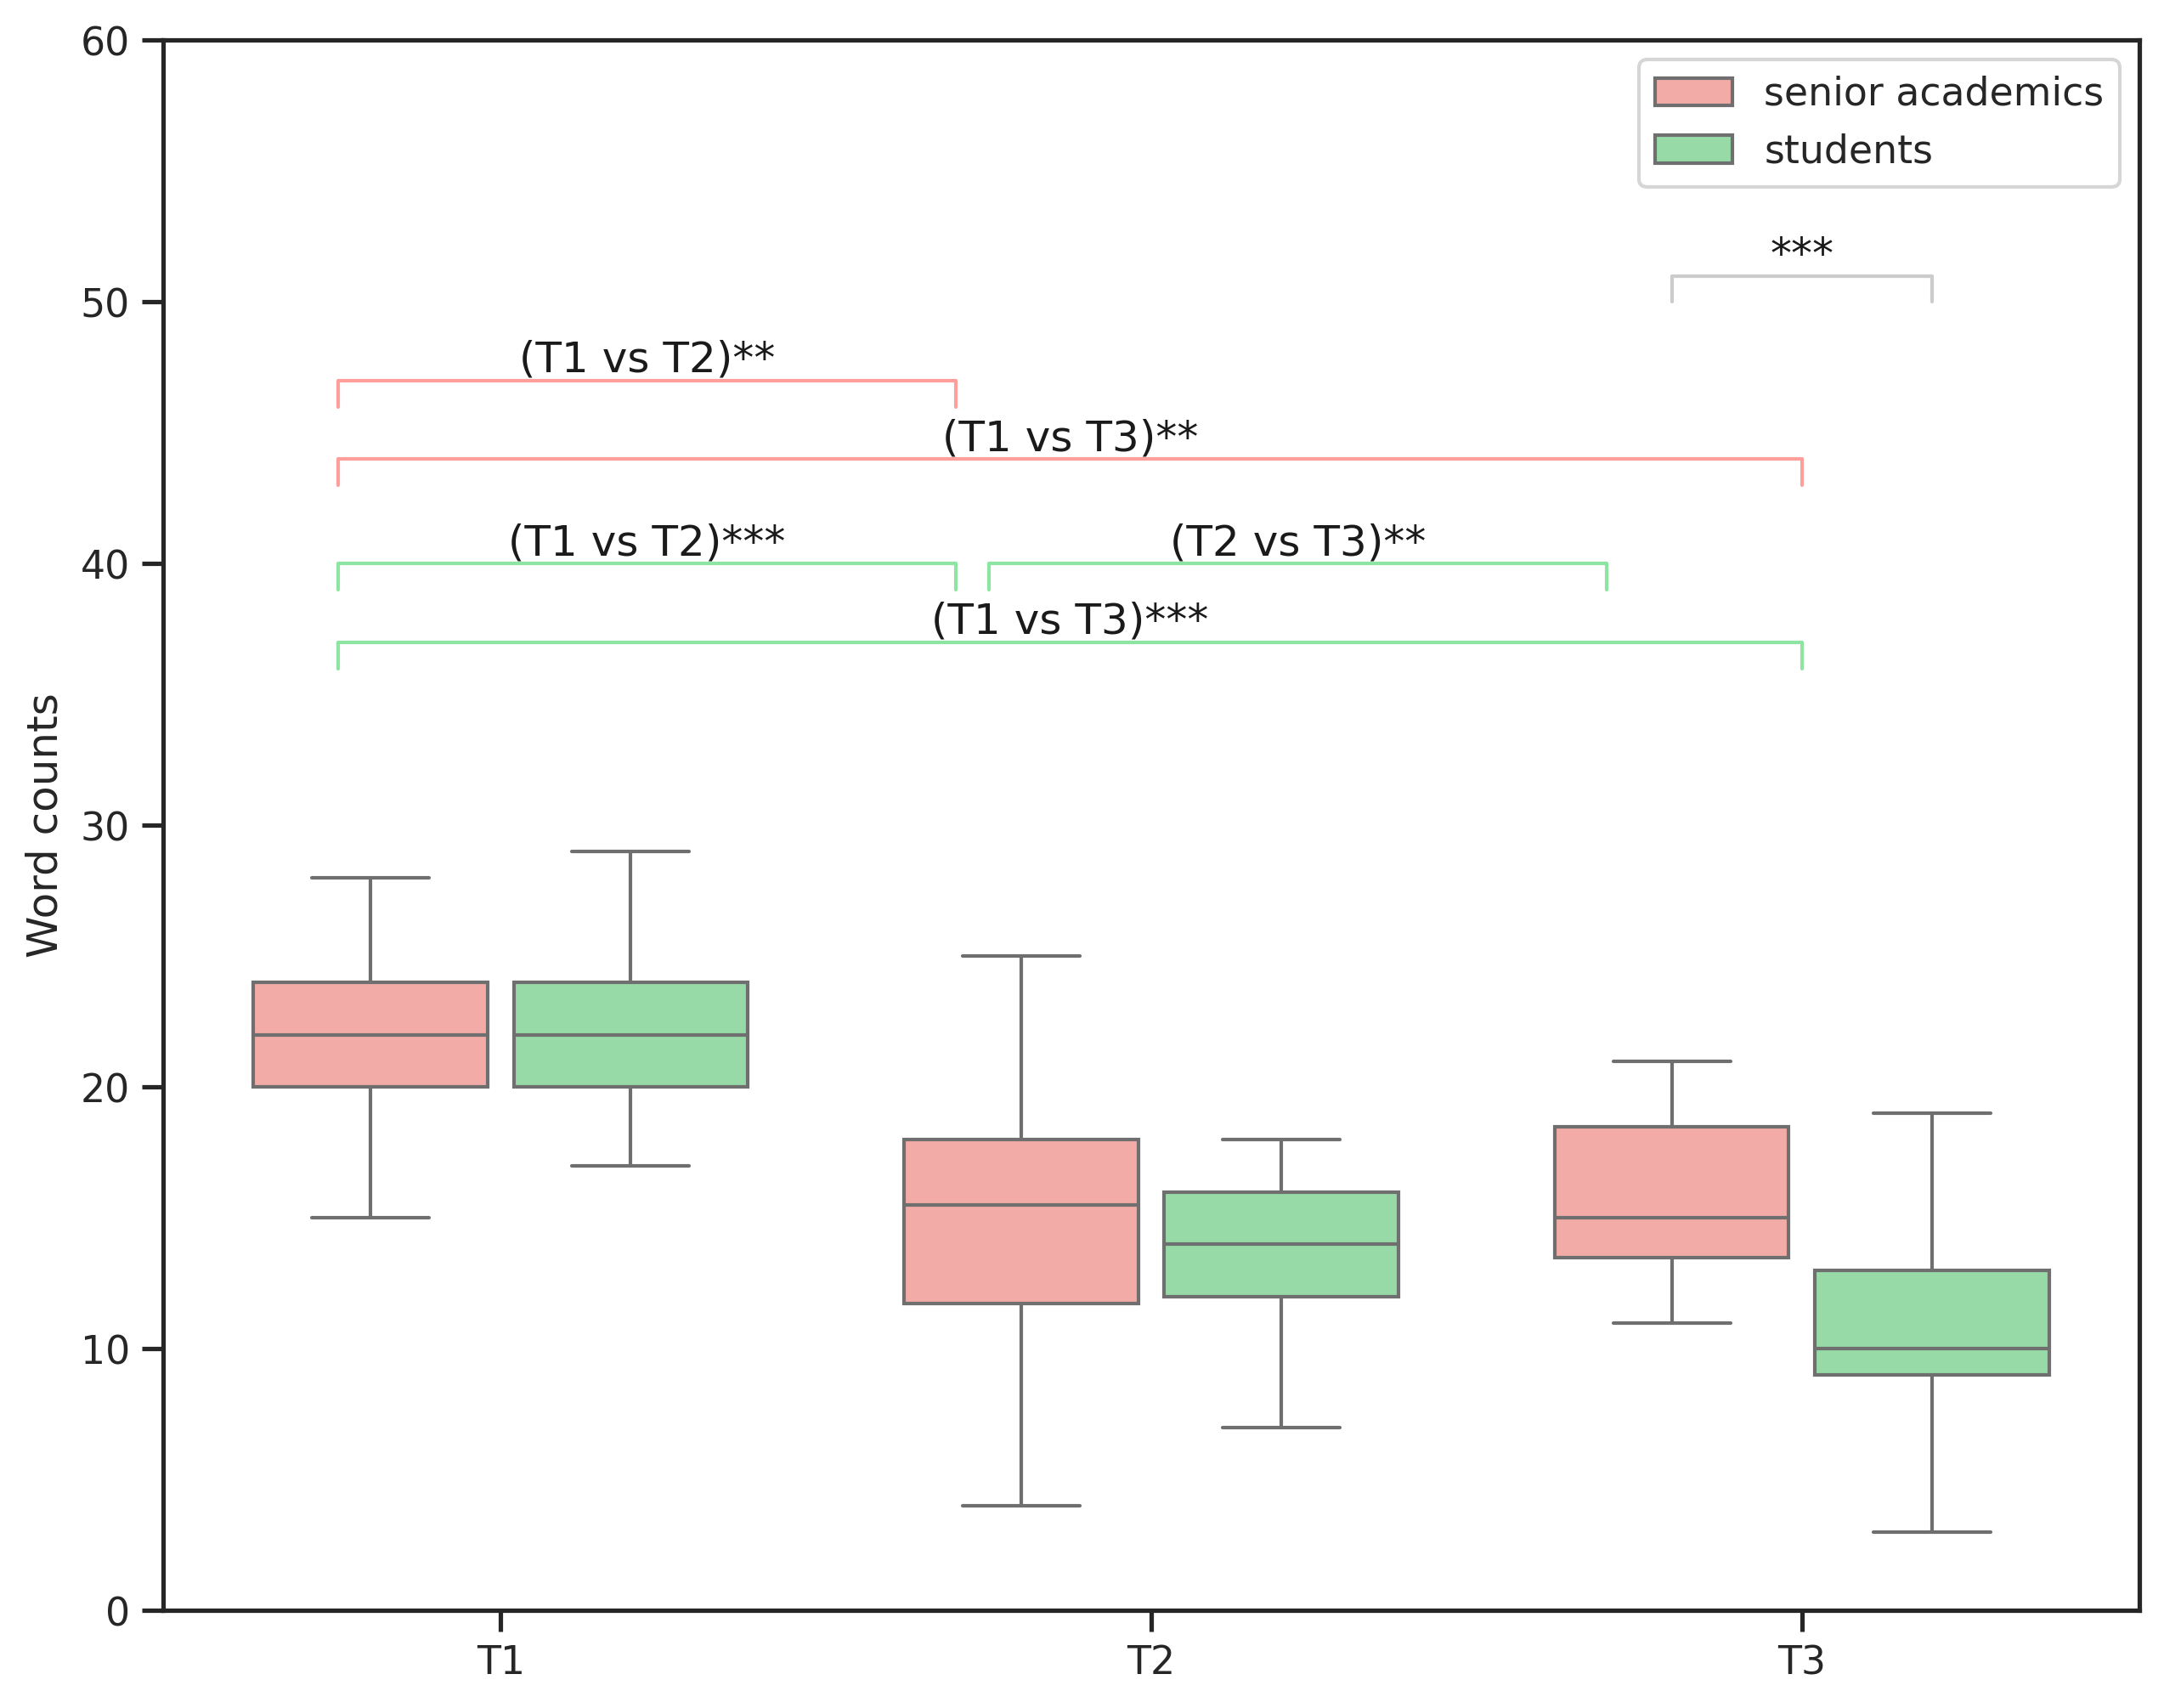

In [155]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(10, 8), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = word_counts.sort_values(['type', 'quota sec']), x='quota sec',y='word', hue='type'
                , palette={'senior academics':'r', 'students':'g'}, showfliers = False
                , gap=.1
                # , showmeans=True
                # , dodge=False
                );
# sns.pointplot(data=word_counts.sort_values(['type', 'quota sec']), x='quota sec', y='word', hue='type', ci=None
#               , estimator='median'
#               ,dodge=.8 - .8 / 2
#               , scale=0.3, color='black', marker='D'
#               , legend=False
#               )


# g.set_title('Word counts by tertiles in groups')

# g.text(-0.5, -3, f"Word counts (students period 1 vs period 2) p value corrected (Wilcox test) < 0.05 - {stud_tertiles_corrected[0][0]}"
#        + f"\nWord counts (students period 2 vs period 3) p value corrected (Wilcox test) < 0.05 - {stud_tertiles_corrected[0][1]}"
#        + f"\nWord counts (students period 1 vs period 3) p value corrected (Wilcox test) < 0.05 - {stud_tertiles_corrected[0][2]}"
#              , fontsize = 9 , ha="left", va="top")

# g.text(-0.5, -5.5, f"Word counts (senior academics period 1 vs period 2) p value corrected (Wilcox test) < 0.05 - {prof_tertiles_corrected[0][0]}"
#        + f"\nWord counts (senior academics period 2 vs period 3) p value corrected (Wilcox test) < 0.05 - {prof_tertiles_corrected[0][1]}"
#        + f"\nWord counts (senior academics period 1 vs period 3) p value corrected (Wilcox test) < 0.05 - {prof_tertiles_corrected[0][2]}"
#              , fontsize = 9 , ha="left", va="top")

# for i in range(3):
#       g.text(i*(0.33)+0.12, -0.11, f"p value corrected\n(M-U test)= {tertiles_corrected[1][i]:.3g}"
#              , fontsize = 9 , ha="left", va="top", transform=g.transAxes)

# statistical annotation
xi=60
plt.ylim(0, xi)
for i in range(3):
    x1, x2 =(i-1)+0.8, (i+1)-0.8
    y, h, col = xi-8-2, 1, '0.8'
    ptext = get_significance(tertiles_corrected[1][i])
    if 'ns' not in ptext:
        plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
        plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')

for i in range(3):
    if i <2:
        x1, x2 =(i-1)+0.75, i+0.7
        y, h, col = xi-12-2, 1, 'r'
        ptext = f'(T{i+1} vs T{i+2})' + get_significance(prof_tertiles_corrected[1][i])
        if 'ns' not in ptext:
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
            plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')
    else:
        # pass
        x1, x2 =(i-3)+0.75, i
        y, h, col = xi-15-2, 1, 'r'
        ptext = get_significance(prof_tertiles_corrected[1][i])
        if 'ns' not in ptext:
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
            plt.text((x1+x2)*.5, y+h, '(T1 vs T3)'+ ptext, ha='center', va='bottom', color='k')


for i in range(3):
    if i <2:
        x1, x2 =(i-1)+0.75, i+0.7
        y, h, col = xi-19-2, 1, 'g'
        ptext = f'(T{i+1} vs T{i+2})' + get_significance(stud_tertiles_corrected[1][i])
        if 'ns' not in ptext:
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
            plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')
    else:
        # pass
        x1, x2 =(i-3)+0.75, i
        y, h, col = xi-22-2, 1, 'g'
        ptext = get_significance(stud_tertiles_corrected[1][i])
        if 'ns' not in ptext:
            plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
            plt.text((x1+x2)*.5, y+h, '(T1 vs T3)'+ ptext, ha='center', va='bottom', color='k')

g.legend( bbox_to_anchor=(1, 1))
plt.ylabel('Word counts')
g.set_xticklabels(['T1', 'T2', 'T3'])
plt.xlabel('')
# plt.xlabel('20-s. period')
# plt.title('Word counts by 20-s. period in groups')
fig.savefig(f'figures/Word counts by tertiles in groups', bbox_inches='tight')

In [268]:
word_counts.sort_values(['type', 'quota sec']) \
    .groupby(['type', 'quota sec'], as_index=False)['word'] \
    .agg(
        Q1=lambda x: x.quantile(0.25),
        Median=lambda x: x.quantile(0.5),
        Q3=lambda x: x.quantile(0.75)
    )

,type,quota sec,Q1,Median,Q3
0,senior academics,1,20.00,22.0,24.0
1,senior academics,2,11.75,15.5,18.0
2,senior academics,3,13.50,15.0,18.5
3,students,1,20.00,22.0,24.0
4,students,2,12.00,14.0,16.0
5,students,3,9.00,10.0,13.0


### word in tertiles + strategies

In [156]:
words.head(1)

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,NaN,п,NaN,1.0,1,152.7,...,NaN,NaN,59,28,13,18,2.390357,students,NaN,NaN


In [157]:
t_strats_wcounts = (words[['quota sec', 'type', 'word', 'ID', 'strategy_paper_name']]
 .groupby(['quota sec', 'type', 'ID', 'strategy_paper_name'], as_index=False)
 .count()
 .drop('ID', axis=1)
)

In [158]:
t_strats_wcounts.head(2)

,quota sec,type,strategy_paper_name,word
0,1,senior academics,S1,4
1,1,senior academics,S2,4


In [159]:
strat_wcounts_groups = t_strats_wcounts.groupby(['strategy_paper_name','quota sec', 'type'])['word'].apply(list)
strat_wcounts_groups

strategy_paper_name  quota sec  type            
S1                   1          senior academics    [4, 3, 2, 2, 2, 2, 2, 1, 5, 2, 4, 7, 6, 4, 2, ...
                                students            [3, 3, 1, 2, 3, 4, 1, 1, 2, 1, 1, 3, 1, 1, 2, ...
                     2          senior academics    [1, 4, 1, 7, 1, 1, 1, 2, 2, 3, 5, 1, 2, 3, 4, ...
                                students            [3, 1, 1, 1, 2, 1, 1, 1, 2, 4, 1, 1, 2, 2, 3, ...
                     3          senior academics        [5, 3, 2, 5, 1, 3, 1, 2, 1, 5, 2, 1, 1, 1, 6]
                                students                               [1, 2, 1, 1, 2, 3, 2, 1, 3, 1]
S2                   1          senior academics                    [4, 2, 1, 3, 3, 2, 2, 7, 1, 1, 4]
                                students                   [2, 1, 2, 1, 3, 1, 2, 1, 1, 3, 1, 1, 3, 1]
                     2          senior academics                       [1, 1, 1, 1, 1, 5, 8, 9, 1, 3]
                                s

In [160]:
from statsmodels.stats.multitest import fdrcorrection

# Prepare the data
wcounts_dependent_ = (words[['strategy_paper_name','quota sec', 'type', 'word', 'ID']]
                    .groupby(['strategy_paper_name','quota sec', 'type', 'ID'], as_index=False)
                    .count()
                    ).pivot(index=['ID', 'type', 'strategy_paper_name'], 
                           columns='quota sec', 
                           values='word'
                           ).reset_index(drop=False).dropna(axis=0)

# Initialize the results dictionary with group → strategy → comparison structure
results = {
    'senior academics': {},
    'students': {}
}

# Define the strategies (assuming S1-S4)
strategies = ['S1', 'S2', 'S3', 'S4']
tertile_pairs = [('T1', 'T2'), ('T2', 'T3'), ('T1', 'T3')]

for group in results:
    for strategy in strategies:
        # Initialize strategy entry
        results[group][strategy] = {}
        
        # Filter data for current group and strategy
        mask = (wcounts_dependent_['type'] == group) & \
               (wcounts_dependent_['strategy_paper_name'] == strategy)
        group_strat_data = wcounts_dependent_[mask]
        
        # Collect p-values for FDR correction
        pvalues = []
        comparisons = []
        
        for t1, t2 in tertile_pairs:
            try:
                res = stats.wilcoxon(
                    group_strat_data[int(t1[-1])].values.astype(int),
                    group_strat_data[int(t2[-1])].values.astype(int),
                    method='exact'
                )
                pvalues.append(res.pvalue)
                comparisons.append((t1, t2, res.statistic))
            except ValueError as e:
                pvalues.append(np.nan)
                comparisons.append((t1, t2, str(e)))
        
        # Apply FDR correction
        if len(pvalues) > 0 and not all(np.isnan(pvalues)):
            _, corrected_pvals = fdrcorrection(pvalues)
        else:
            corrected_pvals = [np.nan] * len(pvalues)
        
        # Store results with corrected p-values
        for (t1, t2, stat), pval, corrected_pval in zip(comparisons, pvalues, corrected_pvals):
            comp_name = f"{t1}_vs_{t2}"
            results[group][strategy][comp_name] = {
                'statistic': stat if isinstance(stat, (int, float)) else None,
                'pvalue': float(pval) if not np.isnan(pval) else None,
                'pvalue_corrected': float(corrected_pval) if not np.isnan(corrected_pval) else None,
                'error': stat if not isinstance(stat, (int, float)) else None
            }


In [161]:
results['senior academics']['S1']['T1_vs_T2']['pvalue_corrected']

0.46513125780002157

In [47]:
# for key in strat_wcounts_groups.keys():
#     print(key, stats.shapiro(strat_wcounts_groups[key]))

In [162]:
t_strats_wcounts['quota sec'].unique()

array([1, 2, 3])

In [163]:
t_strats_wcounts['strategy_paper_name'].unique()

array(['S1', 'S2', 'S3', 'S4'], dtype=object)

In [164]:
t_strats_wcounts['type'].unique()

array(['senior academics', 'students'], dtype=object)

In [165]:
# m-u test
strat_ter_mu_pvalues = {}
strat_ter_mu_pvalues_corrected = {}
for strategy in t_strats_wcounts['strategy_paper_name'].unique():
    tter1_mu = stats.mannwhitneyu(strat_wcounts_groups[(strategy, 1, 'senior academics')], strat_wcounts_groups[(strategy, 1, 'students')])
    tter2_mu = stats.mannwhitneyu(strat_wcounts_groups[(strategy, 2, 'senior academics')], strat_wcounts_groups[(strategy, 2, 'students')])
    tter3_mu = stats.mannwhitneyu(strat_wcounts_groups[(strategy, 3, 'senior academics')], strat_wcounts_groups[(strategy, 3, 'students')])
    temp_p = [tter1_mu.pvalue, tter2_mu.pvalue, tter3_mu.pvalue]
    corr_p = multitest.fdrcorrection(temp_p)
    strat_ter_mu_pvalues[strategy] = temp_p
    strat_ter_mu_pvalues_corrected[strategy] = corr_p

In [166]:
list(strat_ter_mu_pvalues_corrected.keys())[0]

'S1'

In [167]:
strat_wcounts_groups.get('S1')

quota sec  type            
1          senior academics    [4, 3, 2, 2, 2, 2, 2, 1, 5, 2, 4, 7, 6, 4, 2, ...
           students            [3, 3, 1, 2, 3, 4, 1, 1, 2, 1, 1, 3, 1, 1, 2, ...
2          senior academics    [1, 4, 1, 7, 1, 1, 1, 2, 2, 3, 5, 1, 2, 3, 4, ...
           students            [3, 1, 1, 1, 2, 1, 1, 1, 2, 4, 1, 1, 2, 2, 3, ...
3          senior academics        [5, 3, 2, 5, 1, 3, 1, 2, 1, 5, 2, 1, 1, 1, 6]
           students                               [1, 2, 1, 1, 2, 3, 2, 1, 3, 1]
Name: word, dtype: object

In [168]:
t_strats_wcounts[t_strats_wcounts['strategy_paper_name']=='S1']

,quota sec,type,strategy_paper_name,word
0,1,senior academics,S1,4
4,1,senior academics,S1,3
8,1,senior academics,S1,2
12,1,senior academics,S1,2
15,1,senior academics,S1,2
...,...,...,...,...
420,3,students,S1,3
431,3,students,S1,2
434,3,students,S1,1
447,3,students,S1,3


In [169]:
strat_ter_mu_pvalues_corrected

{'S1': (array([False, False, False]),
  array([0.05262006, 0.49258972, 0.47893633])),
 'S2': (array([False, False, False]),
  array([0.24709028, 0.88575635, 0.88575635])),
 'S3': (array([False,  True,  True]),
  array([0.47032945, 0.00450703, 0.00161014])),
 'S4': (array([ True, False, False]),
  array([0.00424319, 0.16837157, 0.07712535]))}

In [170]:
results

{'senior academics': {'S1': {'T1_vs_T2': {'statistic': 17.5,
    'pvalue': 0.16031184519331876,
    'pvalue_corrected': 0.46513125780002157,
    'error': None},
   'T2_vs_T3': {'statistic': 14.0,
    'pvalue': 0.3100875052000144,
    'pvalue_corrected': 0.46513125780002157,
    'error': None},
   'T1_vs_T3': {'statistic': 17.0,
    'pvalue': 0.5120673984985882,
    'pvalue_corrected': 0.5120673984985882,
    'error': None}},
  'S2': {'T1_vs_T2': {'statistic': 3.5,
    'pvalue': 0.3125,
    'pvalue_corrected': 0.46875,
    'error': None},
   'T2_vs_T3': {'statistic': 4.0,
    'pvalue': 0.7150006546880893,
    'pvalue_corrected': 0.7150006546880893,
    'error': None},
   'T1_vs_T3': {'statistic': 1.0,
    'pvalue': 0.28504940740261275,
    'pvalue_corrected': 0.46875,
    'error': None}},
  'S3': {'T1_vs_T2': {'statistic': 42.5,
    'pvalue': 0.10602922025838936,
    'pvalue_corrected': 0.15904383038758405,
    'error': None},
   'T2_vs_T3': {'statistic': 78.5,
    'pvalue': 0.757848567

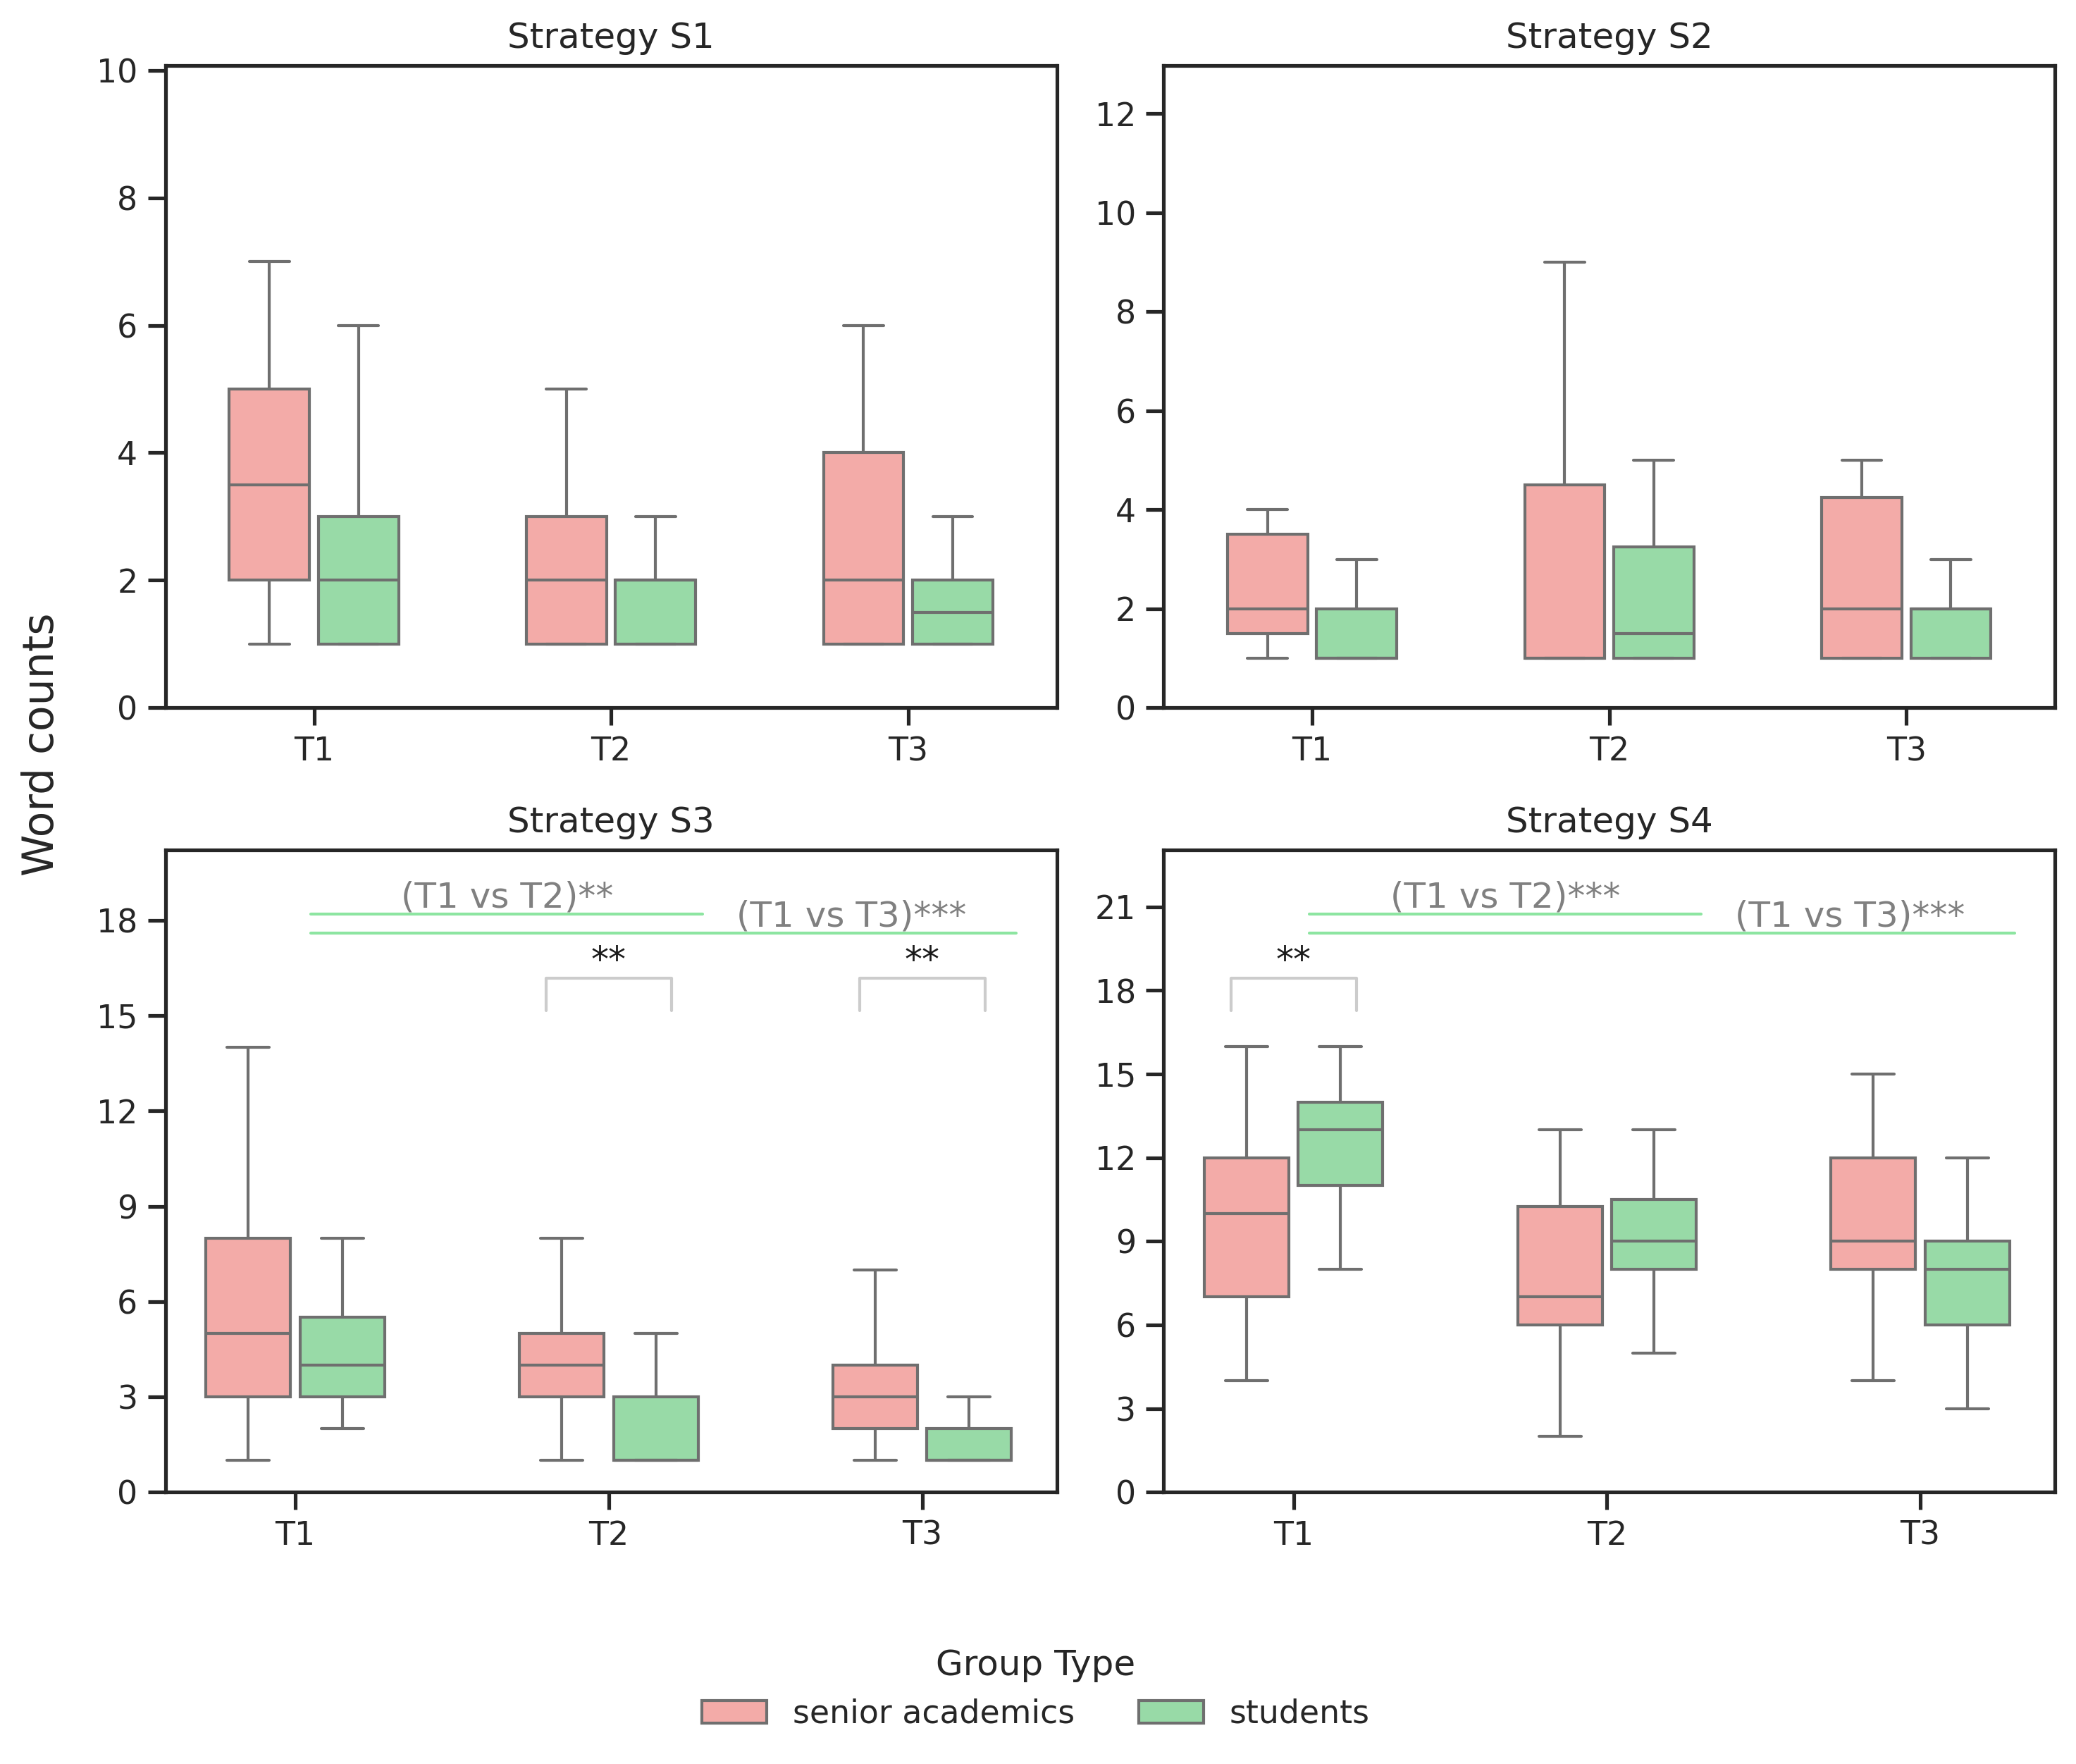

In [171]:
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import matplotlib.pyplot as plt

'''
The code assumes you have the following variables defined:

strat_ter_mu_pvalues_corrected (dictionary with p-values)

t_strats_wcounts (your main DataFrame)

get_significance function (for formatting p-values)
'''


# Set the theme
sns.set_theme(style="ticks", palette="pastel")

# Create a 2x2 grid of subplots with constrained layout
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 8), dpi=300, 
                       constrained_layout=True)
axs = axs.flatten()

# Your data processing
strategies = list(strat_ter_mu_pvalues_corrected.keys())

# We'll collect one legend handle from each plot to make a unified legend
handles, labels = None, None

for k in range(4):
    strategy = strategies[k]
    tdf = t_strats_wcounts[t_strats_wcounts['strategy_paper_name'] == strategy]
    
    # Create boxplot
    g = sns.boxplot(data=tdf.sort_values(['type', 'quota sec']),
                   x='quota sec', y='word', hue='type',
                   palette={'senior academics': 'r', 'students': 'g'},
                   showfliers=False,
                   gap=.1,
                   ax=axs[k],
                   width=0.6)
    
    # Remove individual legends and store handles/labels from first plot
    if k == 0:
        handles, labels = axs[k].get_legend_handles_labels()
    axs[k].get_legend().remove()
    
    # Set axis labels and limits
    g.set(ylabel=None, xlabel=None)
    ll = axs[k].get_ylim()[1]
    xi = ll + 0.38*ll
    axs[k].set_ylim(0, xi)
    
    # Statistical annotations (same as before)
    for i in range(3):
        # Between-group comparisons (gray)
        x1, x2 = (i-1)+0.8, (i+1)-0.8
        y, h, col = xi-0.25*xi, 0.05*xi, '0.8'
        ptext = get_significance(strat_ter_mu_pvalues_corrected.get(strategy)[1][i])
        if 'ns' not in ptext:
            axs[k].plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
            axs[k].text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')
        
        # results['senior academics']['S1']['T1_vs_T2']['pvalue_corrected']
        # Within-group comparisons
        for group, color, offset, offsetx in [('senior academics', 'r', 0.2*xi, 0), 
                                   ('students', 'g', 0.15*xi, 0.3)]:
            if i < 2:
                x1, x2 = (i-1)+0.75+offsetx, i+1+offsetx
                y = xi - offset
                pc = results[group][f'S{k+1}'][f'T{i+1}_vs_T{i+2}']['pvalue_corrected']
                ptext = f'(T{i+1} vs T{i+2})' + get_significance(pc)
            else:
                x1, x2 = (i-3)+0.75+offsetx, i+offsetx
                y = xi - offset - 0.03*xi
                pc = results[group][f'S{k+1}']['T1_vs_T3']['pvalue_corrected']
                ptext = '(T1 vs T3)' + get_significance(pc)
                
            if pc<=0.05:
                axs[k].plot([x1, x1, x2, x2], [y+h, y+h, y+h, y+h], lw=1, c=color)
                if (i==2):
                    x1,x2=x1+offsetx+0.3, x2+offsetx+0.3
                axs[k].text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='0.5')
    
    # Formatting
    axs[k].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[k].set_xticklabels(['T1', 'T2', 'T3'])
    axs[k].set_title(f"Strategy {strategy}")

# Add single legend at the bottom of the figure
fig.legend(handles, labels, loc='lower center', 
          bbox_to_anchor=(0.5, -0.1), ncol=2,
          frameon=False, title='Group Type')

# Global figure labels
fig.supylabel('Word counts')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space at top for legend

# Save the figure
fig.savefig('figures/Word_counts_by_strategies_within_tertiles_in_groups.png', 
           bbox_inches='tight')
plt.show()

In [117]:
# words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type', 'ID']).count().groupby(['quota sec', 'type']).mean()

In [118]:
# words[['quota sec', 'type', 'word', 'ID']].groupby(['quota sec', 'type'], as_index=False).agg(func=lambda x: len(x))

### 
words in tertiles + strategies + starting letter

In [156]:
!pip list

Package            Version
------------------ -----------
asttokens          2.4.1
catboost           1.2.3
certifi            2024.2.2
comm               0.2.1
contourpy          1.2.0
cycler             0.12.1
debugpy            1.8.1
decorator          5.1.1
et_xmlfile         2.0.0
exceptiongroup     1.2.0
executing          2.0.1
fonttools          4.49.0
graphviz           0.20.3
importlib-metadata 7.0.1
ipykernel          6.29.3
ipython            8.22.1
jedi               0.19.1
joblib             1.3.2
jupyter_client     8.6.0
jupyter_core       5.7.1
kiwisolver         1.4.5
lightgbm           4.3.0
matplotlib         3.8.3
matplotlib-inline  0.1.6
munkres            1.1.4
nest_asyncio       1.6.0
numpy              1.26.4
openpyxl           3.1.5
packaging          23.2
pandas             2.2.1
pandas-flavor      0.6.0
parso              0.8.3
patsy              0.5.6
pexpect            4.9.0
pickleshare        0.7.5
pillow             10.2.0
pingouin           0.5.4
pip    

In [7]:
words.head(1)

,Unnamed: 0,ID,quota sec,word,previous + word,first_letter,strategy,order_letter,order_whole_test,frequency,...,VP,VS,N of words,N of words_P,N of words_O,N of words_S,mean pause,type,strategy_name,strategy_paper_name
0,0,Б_В_10,1,пара,NaN,п,NaN,1.0,1,152.7,...,NaN,NaN,59,28,13,18,2.390357,students,NaN,NaN


In [13]:
# words[words['first_letter']=='п']

In [172]:
lettert_strats_wcounts = (words[['first_letter'
                                 , 'strategy_paper_name'
                                 , 'quota sec', 'type'
                                 , 'word'
                                 , 'ID'
                                 ]]
                                 .groupby(['first_letter'
                                 , 'strategy_paper_name'
                                 , 'quota sec', 'type'
                                 , 'ID' 
                                 ], as_index=False)
 .count()
 .drop('ID', axis=1)
)

In [173]:
lettert_strats_wcounts.head()

,first_letter,strategy_paper_name,quota sec,type,word
0,о,S1,1,senior academics,3
1,о,S1,1,senior academics,1
2,о,S1,1,senior academics,2
3,о,S1,1,senior academics,1
4,о,S1,1,senior academics,1


In [174]:
lettert_strats_wcounts.columns = ['First letter'
                                  , 'Strategy'
                                  , 'Tertile'
                                  , 'Group'
                                #   , 'Participant ID'
                                  , 'Word count']

In [175]:
lettert_strats_wcounts

,First letter,Strategy,Tertile,Group,Word count
0,о,S1,1,senior academics,3
1,о,S1,1,senior academics,1
2,о,S1,1,senior academics,2
3,о,S1,1,senior academics,1
4,о,S1,1,senior academics,1
...,...,...,...,...,...
965,с,S4,3,students,2
966,с,S4,3,students,1
967,с,S4,3,students,2
968,с,S4,3,students,2


In [176]:
temp_fisher_p = {}
for letter in ['п', 'о', 'с']:
    for strat in ['S1', 'S2', 'S3', 'S4']:
        for i in range(3):
            try:
                temp_cat_df = lettert_strats_wcounts[(lettert_strats_wcounts['First letter']==letter)
                                    & (lettert_strats_wcounts['Strategy']==strat)
                                    & (lettert_strats_wcounts['Tertile']==(i+1))
                                    ]
                temp_cat_df['Word count >= n'] = (temp_cat_df['Word count'] >= 2)
                temp_crosst = pd.crosstab(temp_cat_df['Group'], temp_cat_df['Word count >= n'])
                # temp_crosst
                temp_fisher = stats.fisher_exact(temp_crosst, alternative='two-sided')
                temp_fisher_p[(letter, strat, (i+1))] = temp_fisher.pvalue
                if temp_fisher.pvalue<0.05:
                    print(letter, strat, (i+1), temp_fisher.pvalue)
            except Exception:
                pass        

п S2 3 0.004995004995004995
п S3 3 0.046800825593395254
о S1 2 0.01976661109788045
о S4 1 0.009401286491835725
с S4 1 0.008699060638985547


In [177]:
temp_chi_p = {}
for letter in ['п', 'о', 'с']:
    for strat in ['S1', 'S2', 'S3', 'S4']:
        for i in range(3):
            # try:
            if True:
                temp_cat_df = lettert_strats_wcounts[(lettert_strats_wcounts['First letter']==letter)
                                    & (lettert_strats_wcounts['Strategy']==strat)
                                    & (lettert_strats_wcounts['Tertile']==(i+1))
                                    ]
                temp_cat_df['Word count >= n'] = (temp_cat_df['Word count'] >= 2)
                temp_crosst = pd.crosstab(temp_cat_df['Group'], temp_cat_df['Word count'])
                # temp_crosst
                temp_chi = stats.chi2_contingency(temp_crosst)
                temp_chi_p[(letter, strat, (i+1))] = temp_chi.pvalue
                if temp_chi.pvalue<0.05:
                    print(letter, strat, (i+1), temp_chi.pvalue)
            # except Exception:
                # print(Exception)
                # pass        

п S2 3 0.007295055724436127
о S4 1 0.013684360621496779


In [179]:
keys_fisher = list(temp_fisher_p.keys())

In [180]:
t = (lettert_strats_wcounts[(lettert_strats_wcounts['First letter']=='п')
                                    & (lettert_strats_wcounts['Strategy']=='S2')
                                    & (lettert_strats_wcounts['Tertile']==3)
                                    ])
display(pd.crosstab(t['Group'], t['Word count']))
print(keys_fisher[3:6])
print(multitest.fdrcorrection(list(temp_chi_p.values())[3:6]))
print(multitest.fdrcorrection(list(temp_fisher_p.values())[3:6]))

Word count,1,2,3,6,7
Group,,,,,
senior academics,0,2,1,0,1
students,9,0,0,1,0


[('п', 'S2', 1), ('п', 'S2', 2), ('п', 'S2', 3)]
(array([False, False,  True]), array([0.22343101, 0.60986287, 0.02188517]))
(array([False, False,  True]), array([0.11538462, 1.        , 0.01498501]))


In [181]:
t = (lettert_strats_wcounts[(lettert_strats_wcounts['First letter']=='о')
                                    & (lettert_strats_wcounts['Strategy']=='S4')
                                    & (lettert_strats_wcounts['Tertile']==1)
                                    ])
display(pd.crosstab(t['Group'], t['Word count']))
print(keys_fisher[21:24])
print(multitest.fdrcorrection(list(temp_chi_p.values())[21:24]))
print(multitest.fdrcorrection(list(temp_fisher_p.values())[21:24]))

Word count,1,2,3,4,5,6
Group,,,,,,
senior academics,8,5,6,2,2,1
students,1,4,5,13,1,2


[('о', 'S4', 1), ('о', 'S4', 2), ('о', 'S4', 3)]
(array([ True, False, False]), array([0.04105308, 0.67538252, 0.143697  ]))
(array([ True, False, False]), array([0.02820386, 1.        , 0.14046884]))


In [182]:
t.head()

,First letter,Strategy,Tertile,Group,Word count
150,о,S4,1,senior academics,1
151,о,S4,1,senior academics,1
152,о,S4,1,senior academics,5
153,о,S4,1,senior academics,3
154,о,S4,1,senior academics,1


In [183]:
temp_crosst

Word count,1,2,3,4,5,6,9
Group,,,,,,,
senior academics,1,7,4,2,5,3,1
students,6,9,3,5,3,0,0


<Axes: xlabel='Group', ylabel='Word count'>

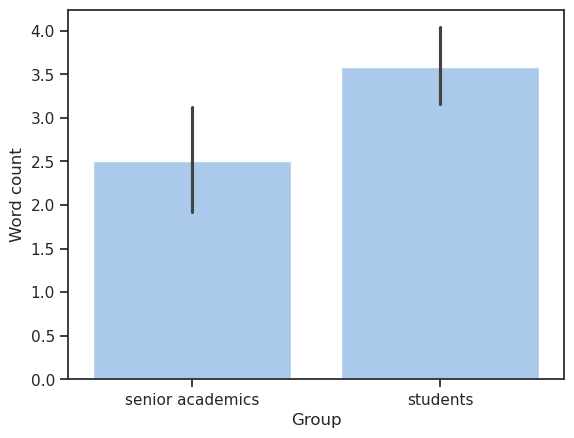

In [184]:
sns.barplot(data=t, y='Word count', x='Group')

In [185]:
lettert_strats_wcounts.head(2)

,First letter,Strategy,Tertile,Group,Word count
0,о,S1,1,senior academics,3
1,о,S1,1,senior academics,1


In [186]:
monstr_table = pd.crosstab(lettert_strats_wcounts['Group'], [lettert_strats_wcounts['Strategy']])
monstr_table

Strategy,S1,S2,S3,S4
Group,,,,
senior academics,90,49,139,205
students,70,65,117,235


In [187]:
monstr_table = pd.crosstab(lettert_strats_wcounts['Group']
                           , [
                               lettert_strats_wcounts['Strategy']
                              #  , lettert_strats_wcounts['First letter']
                              # , lettert_strats_wcounts['Tertile']
                              # , lettert_strats_wcounts['Strategy']
                              
                            ]
                        )
display(monstr_table)
stats.chi2_contingency(monstr_table)

Strategy,S1,S2,S3,S4
Group,,,,
senior academics,90,49,139,205
students,70,65,117,235


Chi2ContingencyResult(statistic=8.665346089350248, pvalue=0.03408763345901513, dof=3, expected_freq=array([[ 79.67010309,  56.76494845, 127.47216495, 219.09278351],
       [ 80.32989691,  57.23505155, 128.52783505, 220.90721649]]))

In [188]:
list(temp_chi_p)[0]

('п', 'S1', 1)

In [89]:
# 3*4*3*2
# lstrat_wcounts_groups.get(('п', 'S1', '1'))

# RT

In [189]:
rt = pd.read_csv('results_academic_student.csv', sep=';' )
rt.head()

,participant,mean_rt,group
0,12014,0.608103,senior academics
1,2001,0.537719,senior academics
2,2005,0.863233,senior academics
3,9001,0.801409,senior academics
4,9002,0.564224,senior academics


In [190]:
# rt_full = pd.read_csv('combined_shape_trials.csv', dtype = {'participant': 'str', 'accuracy' : 'float', 'rt':'float'})
rt_full = pd.read_csv('combined_shape_trials.csv')
rt_full['participant'] = pd.to_numeric(rt_full['participant'], downcast='integer')
rt_full = rt_full[(rt_full['accuracy']==1 ) & (~rt_full['participant'].isna())]
# rt_full['participant']= rt_full['participant'].fillna(0).astype('int64')
rt_full['participant']= rt_full['participant'].astype('int64')
rt_full = rt_full.merge(rt[['group', 'participant']], on='participant', how='inner')
rt_full.head(2)


,participant,accuracy,rt,group
0,12001,1,1.053446,senior academics
1,12001,1,1.504920,senior academics


In [145]:
rt_full['participant'].nunique()

46

Статистика Хи-квадрат: 1.625420533081806e-27
P-значение: 1.0
Observed difference (standardized): -0.07503624271573295
CI for observed difference [-0.3705788003218324, 0.22050631489036648]
Cohen's d (effect size): -0.49763065229628817
Expected mean diffs are normal distributed
T-student p_value: 0.08789
Нормальность средних разниц: p=0.1018
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0.0154
П-значение для разницы дисперсий: 0.8105
Доверительный интервал для средней разницы H0: (-0.06046, 0.06172)
Эффект (Cohen's D): -0.4976


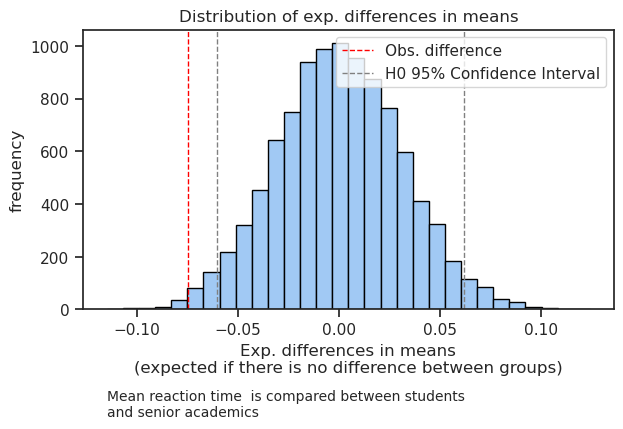

In [191]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_permutation_analysis(rt, 'mean_rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Mean reaction time ")

paper_table.loc[len(paper_table)] = ['Mean reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.3g}'), float(f'{p_value_mean:.3g}'), round(Crit_metric, 2), float(f'{pst:.3g}'), float(f'{pst:.3g}')]

In [192]:
temp_ds = get_descriptive_statistics(df = rt, col = 'mean_rt', varname='Mean reaction time'
                                         , type_col="group"
                                         , senior_type="senior academics", normal=normal)
desc_stats = pd.concat([desc_stats, temp_ds])

In [194]:
a = rt[(rt['group']!='students')]['mean_rt'].values
b = rt[(rt['group']=='students')]['mean_rt'].values
T_o , p_ond = stats.ttest_ind(a, b, permutations=1000, alternative='greater')

In [195]:
p_ond

0.04595404595404595

In [196]:
paper_table.loc[len(paper_table)] = ['Mean reaction time (one-sided alternative)', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.3g}'), float(f'{p_value_mean:.3g}'), round(T_o, 2), float(f'{p_ond:.3g}'), float(f'{p_ond:.3g}')]

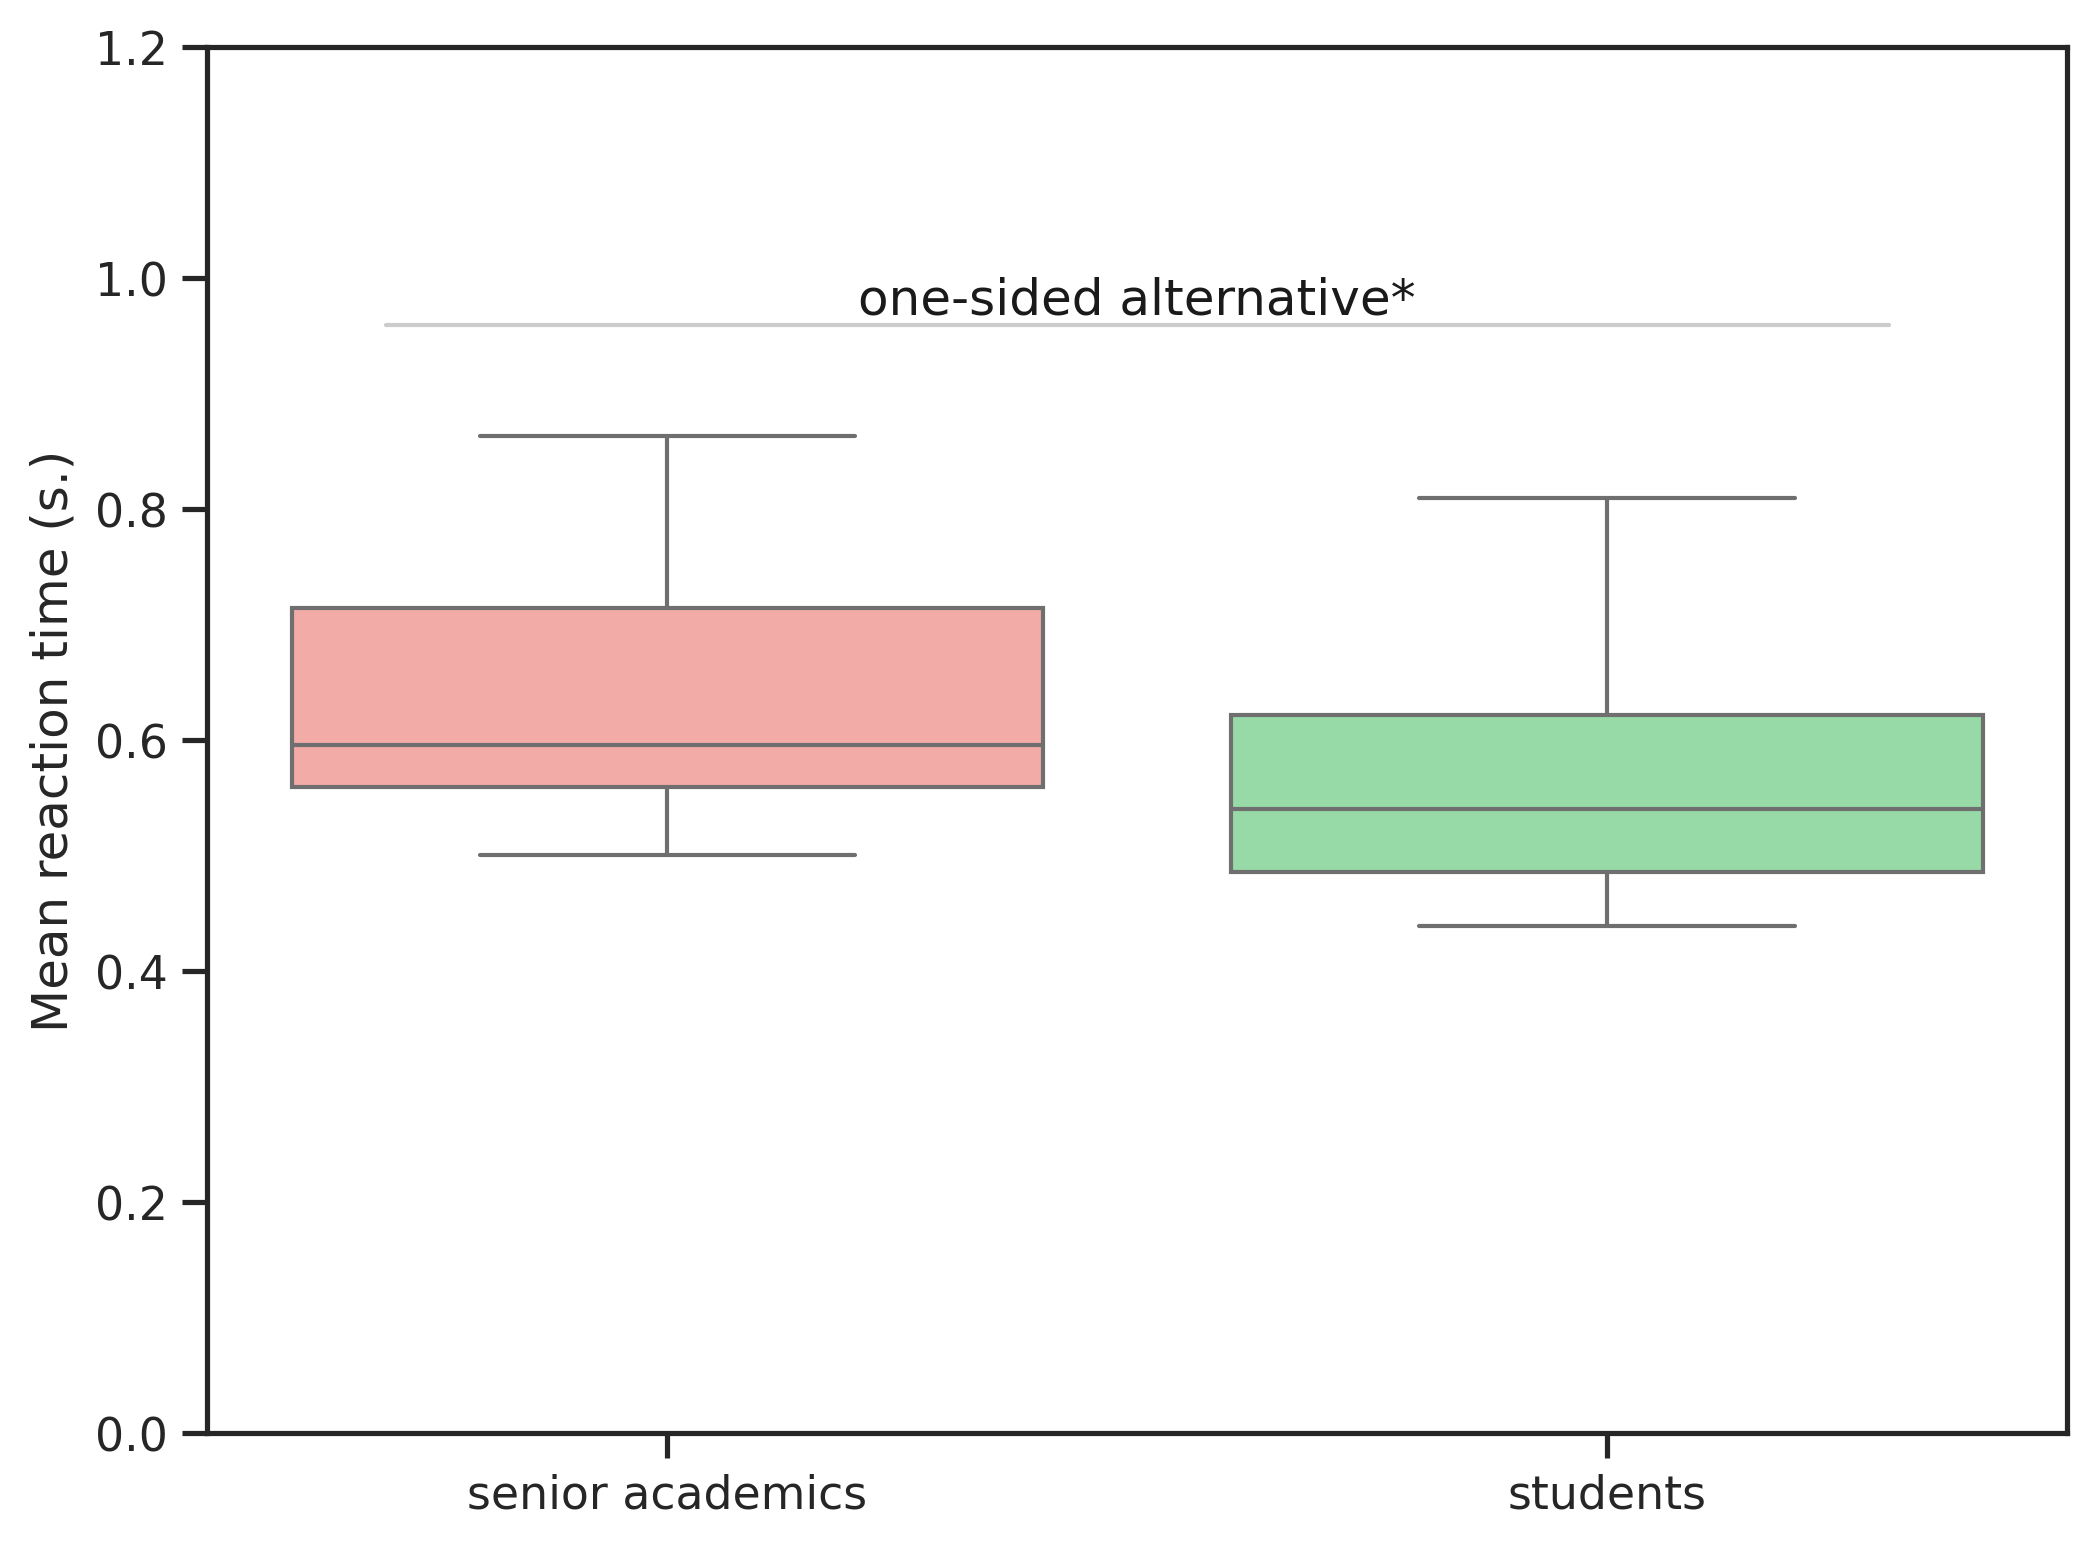

In [197]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(8, 6), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
# g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
# if 1:
#       g.text(0.01
#              , -0.17, f"p value (t_test with permutation, one-sided alternative) = {p_ond:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
      
# g.text(0.01, -0.22, f"p value (permutation)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
# plt.xlabel('Group')
# plt.title('Mean reaction time between groups')
# statistical annotation
xi=1.2
plt.ylim(0, xi)
plt.xlabel(None)
plt.ylabel('Mean reaction time (s.)')
x1, x2 = -0.3 , 1.3
y, h, col = xi-0.2*xi, 0, '0.8'
ptext = 'one-sided alternative'+ get_significance(p_ond)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')

fig.savefig(f'figures/Mean reaction time between groups one-sided.png', bbox_inches='tight')

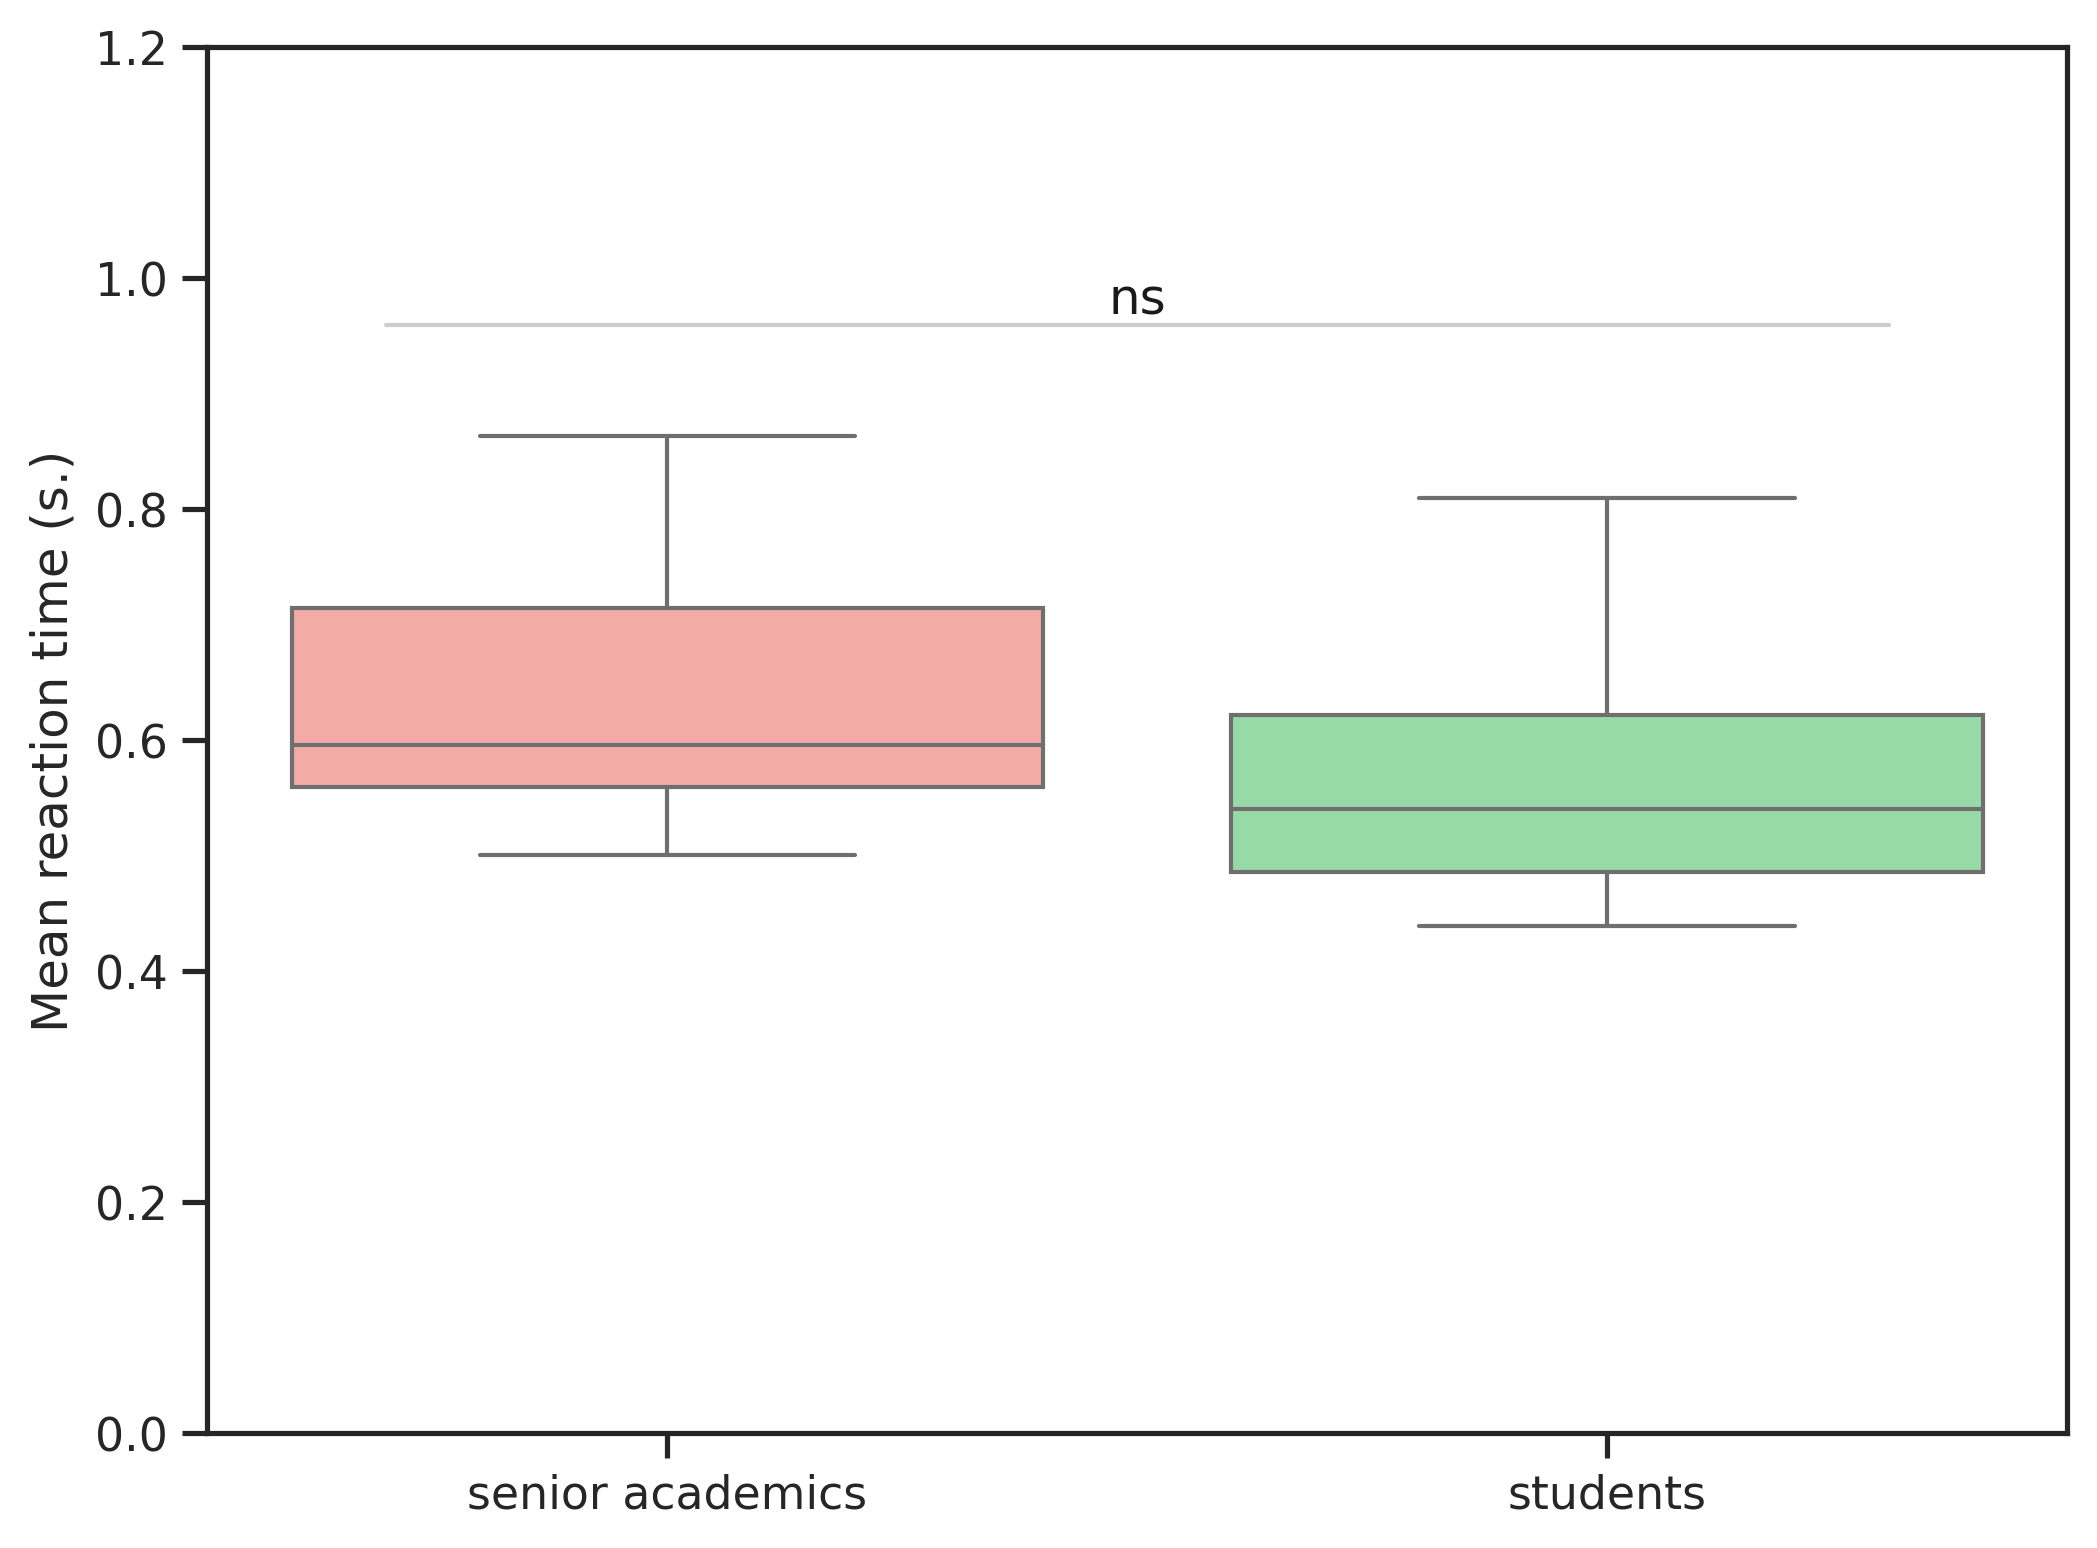

In [198]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(8, 6), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt, y='mean_rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
# g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
# if 1:
#       g.text(0.01
#              , -0.17, f"p value (t_test with permutation)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
# else:
#       g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
# g.text(0.01, -0.22, f"p value (permutation)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
    
# plt.title('Mean reaction time between groups')
# statistical annotation
xi=1.2
plt.ylim(0, xi)
plt.xlabel(None)
plt.ylabel('Mean reaction time (s.)')
x1, x2 = -0.3 , 1.3
y, h, col = xi-0.2*xi, 0, '0.8'
ptext = get_significance(pst)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')

fig.savefig(f'figures/Mean reaction time between groups.png', bbox_inches='tight')

Статистика Хи-квадрат: 3.6927543799146536e-27
P-значение: 1.0
Observed difference (standardized): -0.07204987331355128
CI for observed difference [-0.5866957114119992, 0.4425959647848966]
Cohen's d (effect size): -0.27439792812925967
Expected mean diffs are normal distributed
T-student p_value: 9.999e-05
Нормальность средних разниц: p=0.4537
Хи квадрат дисперсии разниц: p=1
P-значение для разницы средних: 0
П-значение для разницы дисперсий: 0.3475
Доверительный интервал для средней разницы H0: (-0.01723, 0.017)
Эффект (Cohen's D): -0.2744


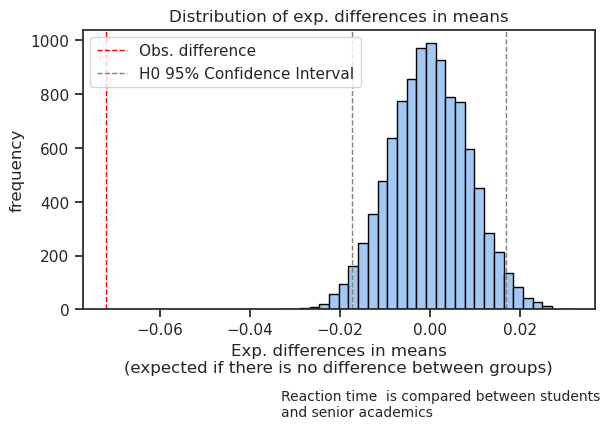

In [199]:
mean_expected_diffs, normal, ci_mean, delta ,cohens_d, p_value_mean, Crit_metric, pst = full_permutation_analysis(rt_full, 'rt', type_col='group')
plot_bresults(mean_expected_diffs, delta, ci_mean, col='', text_add="Reaction time ")

paper_table.loc[len(paper_table)] = ['Reaction time', normal, [round(x, 2) for x in ci_mean]
                                         , round(delta, 2), round(cohens_d, 2)
                                         , float(f'{p_value_mean:.3g}'), float(f'{p_value_mean:.3g}'), round(Crit_metric, 2), float(f'{pst:.3g}'), float(f'{pst:.3g}')]

temp_ds = get_descriptive_statistics(df = rt_full, col = 'rt', varname='Reaction time'
                                         , type_col="group"
                                         , senior_type="senior academics", normal=normal)
desc_stats = pd.concat([desc_stats, temp_ds])
# p_value_mean, normal, pst = full_permutation_analysis(rt_full, 'rt', type_col='group')

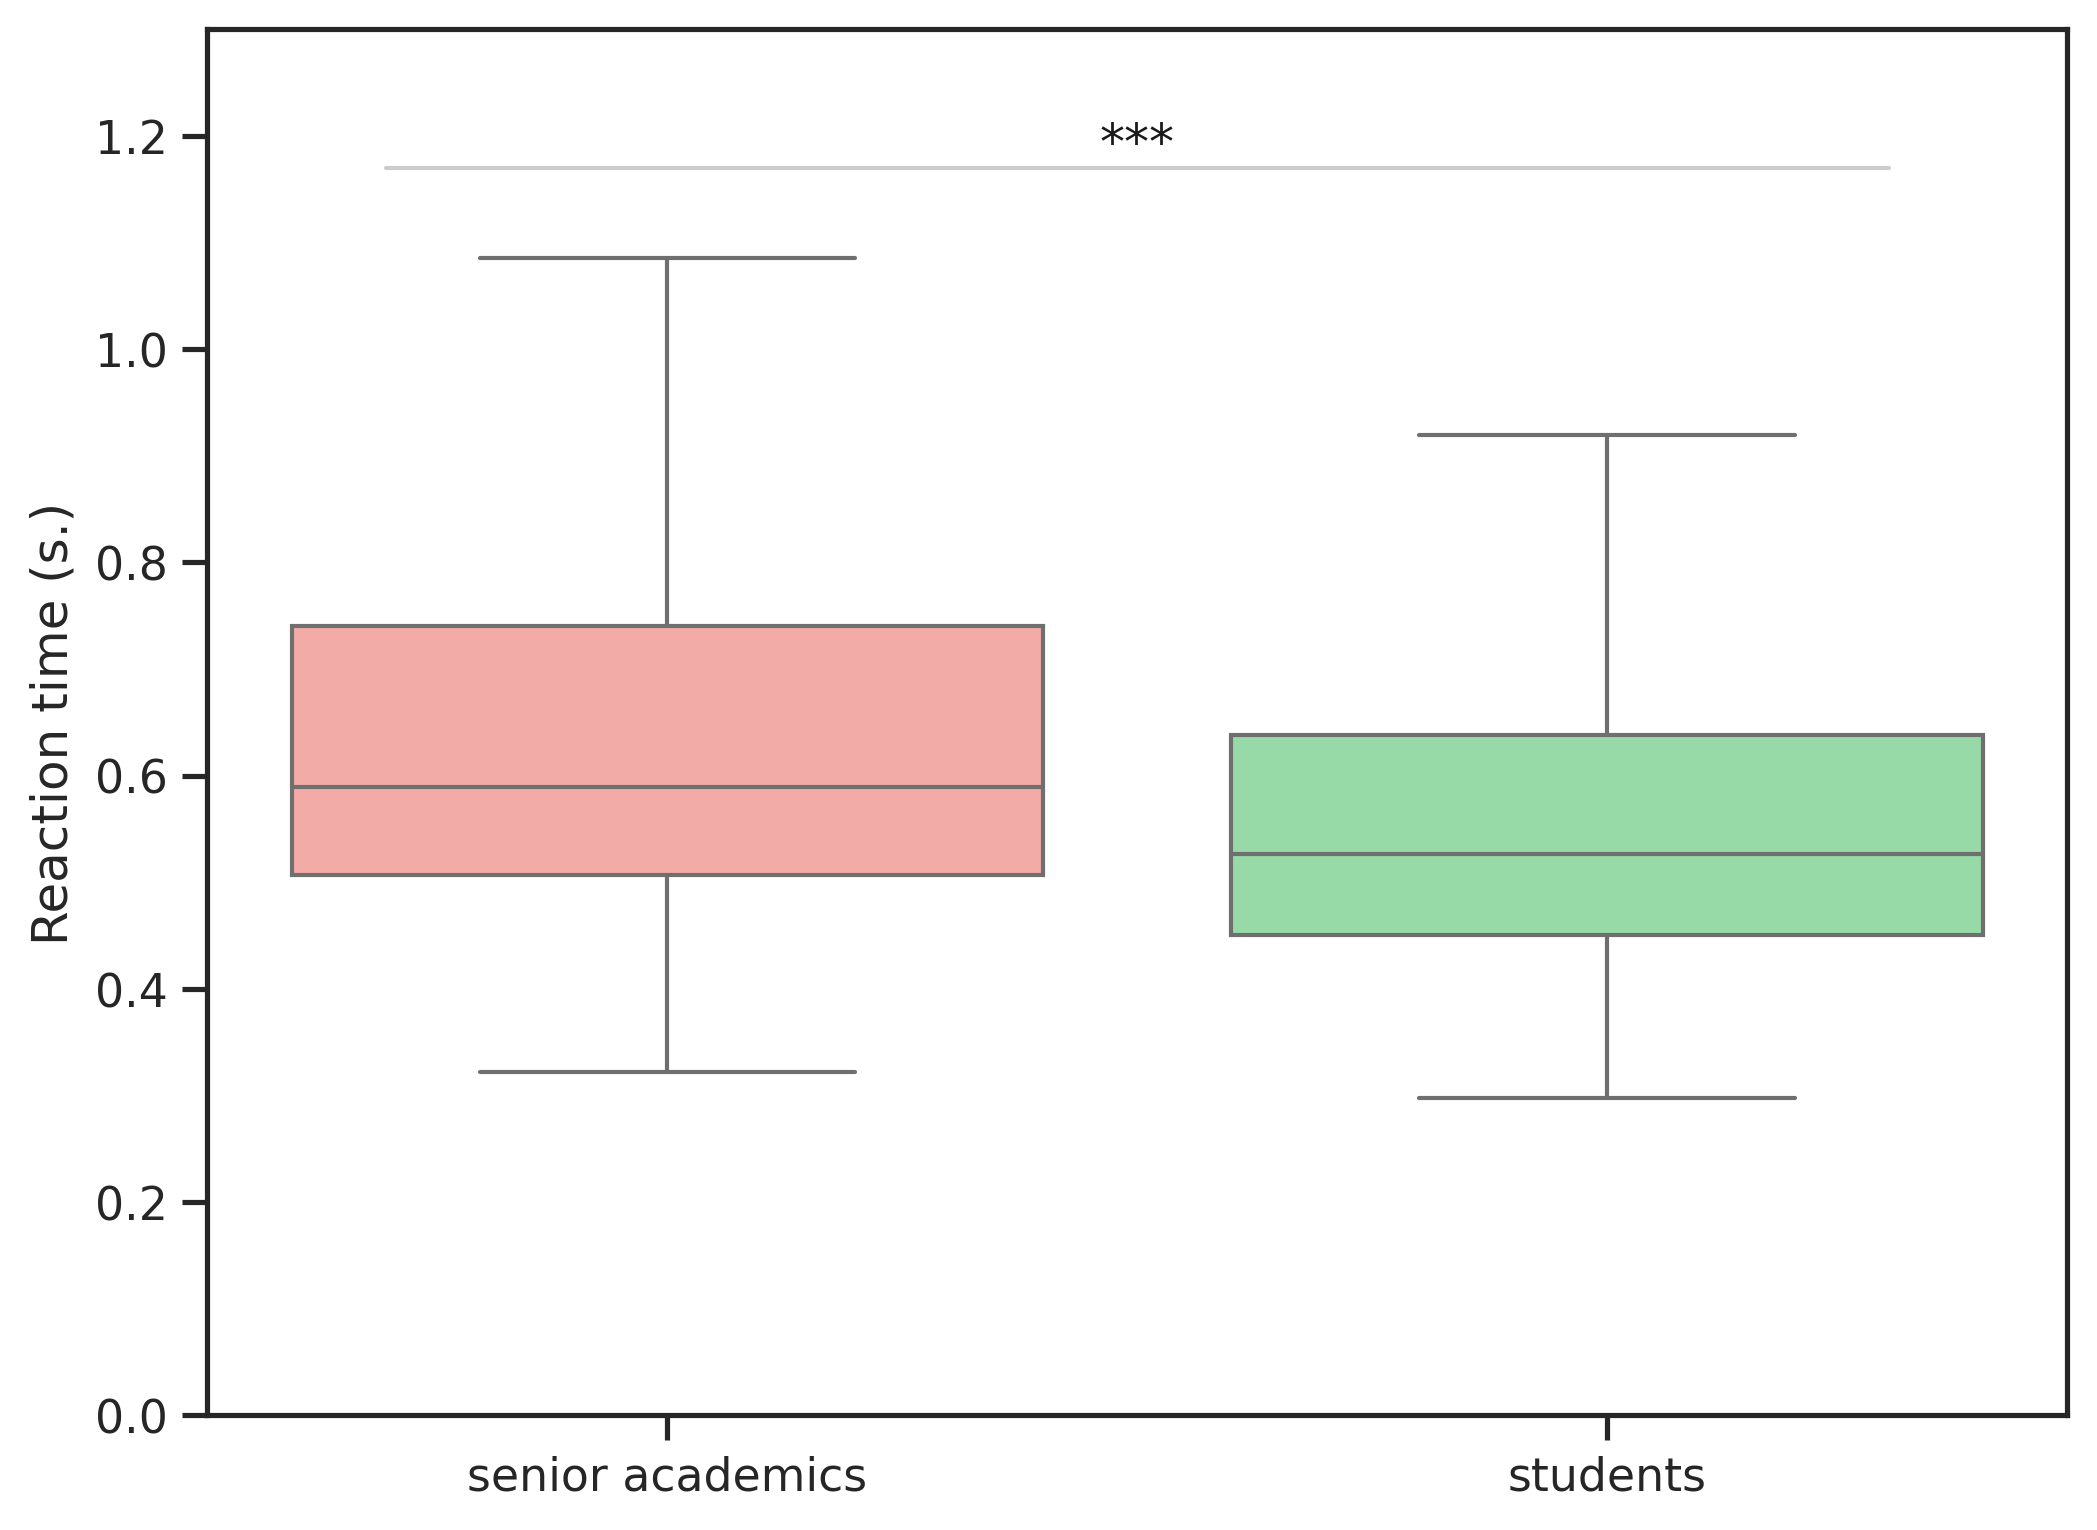

In [200]:
sns.set_theme(style="ticks", palette="pastel");
fig, axs = plt.subplots(figsize=(8, 6), dpi=300)
# plt.figure(figsize=(10, 6))
g = sns.boxplot(data = rt_full, y='rt', x='group', hue='group', palette={'senior academics':'r', 'students':'g'}, showfliers = False);
# g.text(0.01, -0.12, f"Normal distributed = {str(normal)}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )         # Size
# if 1:
#       g.text(0.01
#              , -0.17, f"p value (t_test with permutation)= {pst:.3g}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
# else:
#       g.text(-0.25-0.05, -0.17, f"p value (M-U test)= {pst:.3f}", rotation = 0, fontsize = 9, ha="left", va="top", transform=g.transAxes )
# g.text(0.01, -0.22, f"p value (permutation)= {p_value_mean:.3f}", fontsize = 9 , ha="left", va="top", transform=g.transAxes)
# statistical annotation
xi=1.3
plt.ylim(0, xi)
plt.xlabel(None)
plt.ylabel('Mean reaction time (s.)')
x1, x2 = -0.3 , 1.3
y, h, col = xi-0.1*xi, 0, '0.8'
ptext = get_significance(pst)
plt.plot([x1, x1, x2, x2], [y, y+h, y+h, y], lw=1, c=col)
plt.text((x1+x2)*.5, y+h, ptext, ha='center', va='bottom', color='k')
    
plt.xlabel(None)
plt.ylabel('Reaction time (s.)')
# plt.title('Reaction time between groups')
fig.savefig(f'figures/Reaction time between groups.png', bbox_inches='tight')

In [ ]:
# conf_interval = []
# pval = []
# es = []
# rt.columns = ['participant', 'mean_rt', 'type']

# # print(i)
# ci, p_value, observed_diff, mdelta_, cohens_d = full_permutation_mean_diff(rt, 'mean_rt')
# conf_interval.append(ci)
# pval.append(p_value)
# es.append(cohens_d)
# print('\n')

# RT correlation

In [9]:
rt = pd.read_csv('results_academic_student.csv', sep=';')
# rt.head()

In [10]:
stuts = pd.read_csv('Список_студентов_психфак_мгу_весна_осень_24_2.csv', sep = '\t')
stuts['ID autumn'] = pd.to_numeric(stuts['ID autumn'], downcast='integer')
stuts['ID autumn']= stuts['ID autumn'].fillna(0).astype('int64')
stuts = stuts[['ID', 'ID autumn']]

In [11]:
academics = pd.read_excel('senior_academics_ids.xlsx')
academics['ID autumn'] = pd.to_numeric(academics['ID_new'], downcast='integer')
academics['ID autumn']= academics['ID autumn'].fillna(0).astype('int64')
# academics.head(1)
academics = academics[['ID', 'ID autumn']]

In [12]:
ids_ac_st = pd.concat([academics, stuts])
rt_ = rt.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [16]:
fullrt_ = rt_full.merge(ids_ac_st, left_on='participant', right_on='ID autumn', how='inner')

In [17]:
fullrt_.head(2)

,participant,accuracy,rt,group,ID,ID autumn
0,12001,1,1.053446,senior academics,pr_M_2,12001
1,12001,1,1.504920,senior academics,pr_M_2,12001


In [40]:
rt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(rt_, on='ID', how='inner')
fullrt_for_cor = dfjj[['ID', 'frequency', 'pause', 'mean pause', 'type',
       'strategy_paper_name', 'Word frequency', 'Pause duration', 'order_letter', 'order_whole_test']].merge(fullrt_, on='ID', how='inner')

In [42]:
rt_for_cor = rt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'mean_rt', 'group'
       # ,'mean_rt_standardized'
       , 'order_letter', 'order_whole_test']]
fullrt_for_cor = fullrt_for_cor[['ID', 'mean pause', 'type', 'strategy_paper_name',
       'Word frequency', 'Pause duration', 'rt', 'group'
       # ,'rt_standardized'
       , 'order_letter', 'order_whole_test']]

In [43]:
fullrt_for_cor = fullrt_for_cor[['ID',
       'Pause duration', 'rt', 'group'
       # ,'rt_standardized'
       ]].drop_duplicates()
fullrt_for_cor.head(2)

,ID,Pause duration,rt,group
0,Б_В_24,1.63,0.610993,students
1,Б_В_24,1.63,0.521008,students


In [104]:
# sns.relplot(data=rt_for_cor, x='order_letter', y='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_whole_test', x='Pause duration')
# sns.scatterplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [111]:
# rt[rt['mean_rt']>1]

In [112]:
# sns.histplot(rt['mean_rt'])

In [113]:
# rt_for_cor[~rt_for_cor['additional'].isna()]
# rt_for_cor = rt_for_cor[rt_for_cor['mean_rt']<=1]

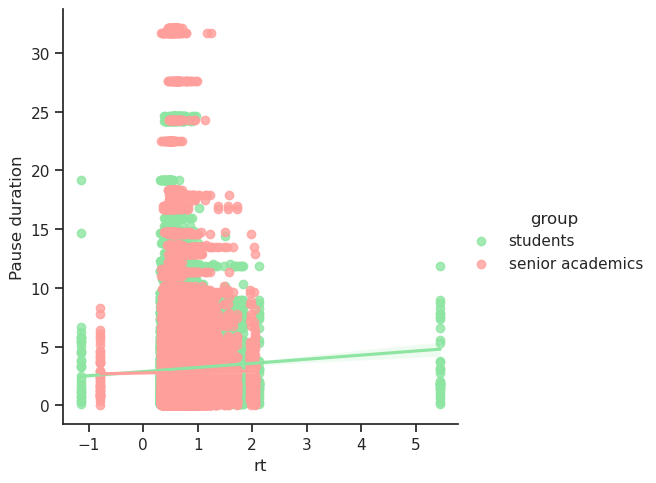

In [105]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=fullrt_for_cor, x='rt', y='Pause duration', hue='group', palette={'senior academics':'r', 'students':'g'});

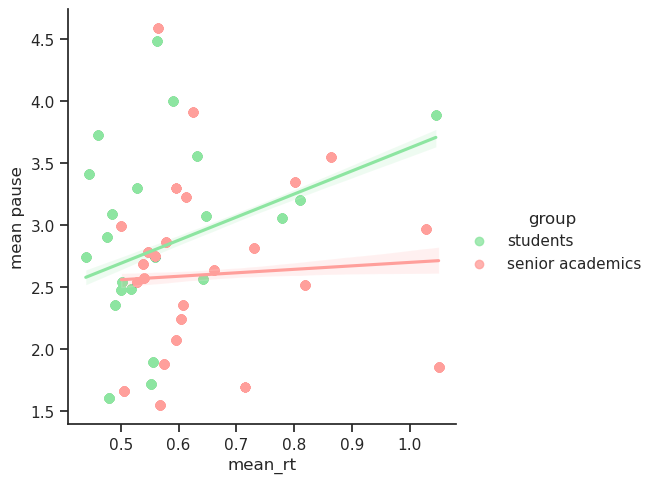

In [106]:
axs = sns.set_theme(style="ticks", palette="pastel");
axs = sns.lmplot(data=rt_for_cor, x='mean_rt', y='mean pause', hue='group', palette={'senior academics':'r', 'students':'g'});

In [44]:
fullrtcor = fullrt_for_cor.drop_duplicates()
x = fullrtcor['rt']
y = fullrtcor['Pause duration']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.012007125431173587, pvalue=0.0012442010760048844)
SignificanceResult(statistic=0.03129580759233792, pvalue=3.870245915001865e-17)
SignificanceResult(statistic=0.02112494541446955, pvalue=1.801096179337337e-17)


In [45]:
rtcor = rt_for_cor[['mean pause', 'mean_rt', 'ID', 'group']].drop_duplicates()
x = rtcor['mean_rt']
y = rtcor['mean pause']
print(stats.pearsonr(x,y))    # Pearson's r

print(stats.spearmanr(x,y) )  # Spearman's rho

print(stats.kendalltau(x,y) ) # Kendall's tau

PearsonRResult(statistic=0.10710010725138666, pvalue=0.4736611353323659)
SignificanceResult(statistic=0.1502081406105458, pvalue=0.31356107137254163)
SignificanceResult(statistic=0.1082331174838113, pvalue=0.2832966676073182)


In [46]:
rtcor.groupby('group').count()

,mean pause,mean_rt,ID
group,,,
senior academics,25,25,25
students,22,22,22


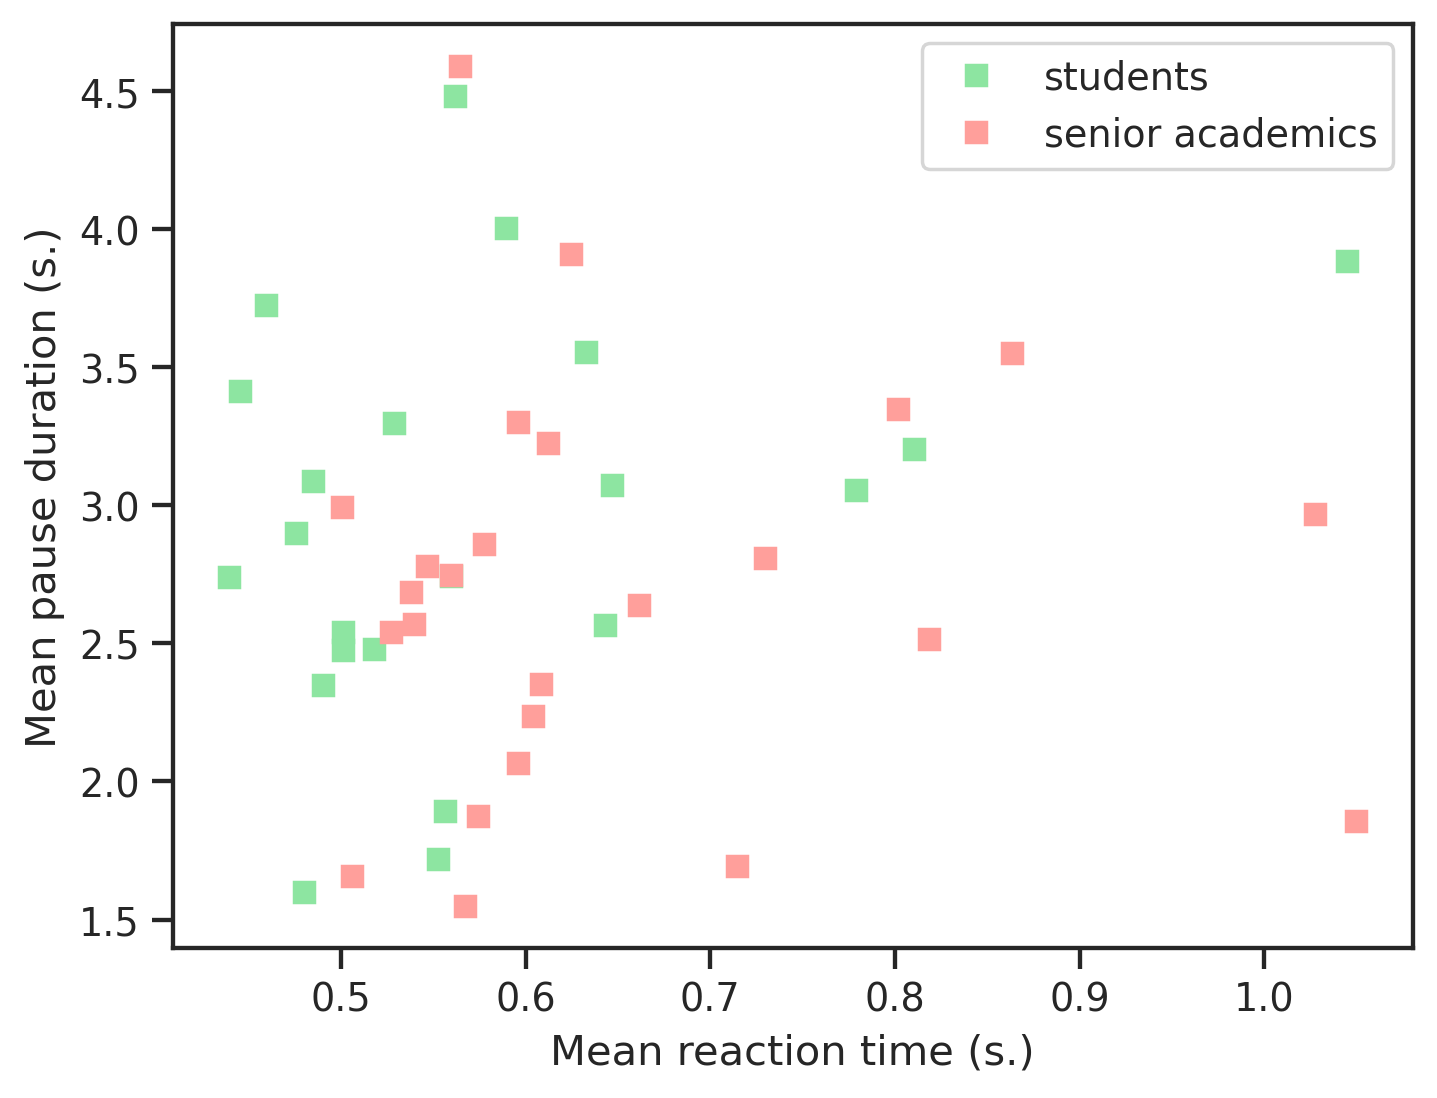

In [51]:
x1 = rtcor[rtcor['group']=='students']['mean_rt']
y1 = rtcor[rtcor['group']=='students']['mean pause']
x2 = rtcor[rtcor['group']!='students']['mean_rt']
y2 = rtcor[rtcor['group']!='students']['mean pause']

slope, intercept, r, p, stderr = stats.linregress(x1, y1)
# line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
fig, ax = plt.subplots(dpi=250)
# ax.set_color_cycle(['green', 'red'])
ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
# ax.plot(x1, intercept + slope * x1, label=line, color='green')

slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
# line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
# ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

ax.set_xlabel('Mean reaction time (s.)')
ax.set_ylabel('Mean pause duration (s.)')
ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# plt.tight_layout()

# ax.legend(facecolor='white')
plt.show()
fig.savefig(f'figures/Mean reaction time ~ Mean pause duration.png', bbox_inches='tight')

In [63]:
# x1 = rtcor[rtcor['group']=='students']['mean_rt']
# y1 = rtcor[rtcor['group']=='students']['mean pause']
# x2 = rtcor[rtcor['group']!='students']['mean_rt']
# y2 = rtcor[rtcor['group']!='students']['mean pause']

# slope, intercept, r, p, stderr = stats.linregress(x1, y1)
# line = f'Regression line: y={intercept:.2f}+{slope:.2f}x,\nr={r:.2f}, p={p:.3f}'
# fig, ax = plt.subplots(dpi=250)
# # ax.set_color_cycle(['green', 'red'])
# ax.plot(x1, y1, linewidth=0, marker='s', label='students', color='g')
# ax.plot(x1, intercept + slope * x1, label=line, color='green')

# slope2, intercept2, r2, p2, stderr2 = stats.linregress(x2, y2)
# line2 = f'Regression line: y={intercept2:.2f}+{slope2:.2f}x,\nr={r2:.2f}, p={p2:.3f}'
# ax.plot(x2, y2, linewidth=0, marker='s', label='senior academics', color='r')
# ax.plot(x2, intercept2 + slope2 * x2, label=line2, color='red')

# ax.set_xlabel('Mean reaction time')
# ax.set_ylabel('Mean pause duration')
# ax.legend(facecolor='white',  bbox_to_anchor=(1, 1))
# # plt.tight_layout()

# # ax.legend(facecolor='white')
# plt.show()
# fig.savefig(f'figures/Mean reaction time ~ Mean pause duration.png', bbox_inches='tight')

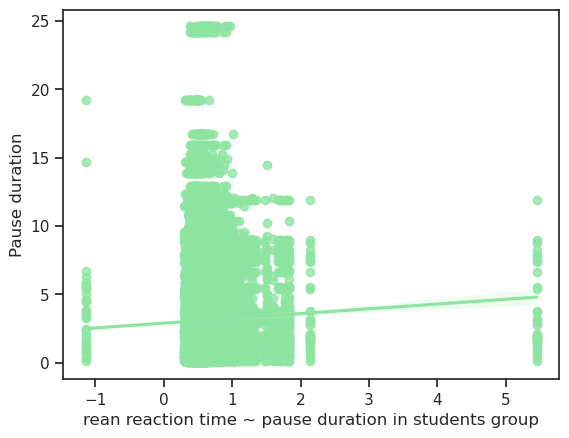

In [119]:
# fig, axs = plt.subplots(figsize=(8, 8), dpi=150)
# plt.figure(figsize=(10, 6))
    
# fig, axs = plt.subplots(figsize=(7, 7), dpi=120)

sns.regplot(data=fullrt_for_cor[fullrt_for_cor['group']=='students'], x='rt', y='Pause duration', color='g')
plt.xlabel('rean reaction time ~ pause duration in students group');

In [306]:
# sns.scatterplot(data=rt_for_cor, x='mean_rt', y='mean pause')

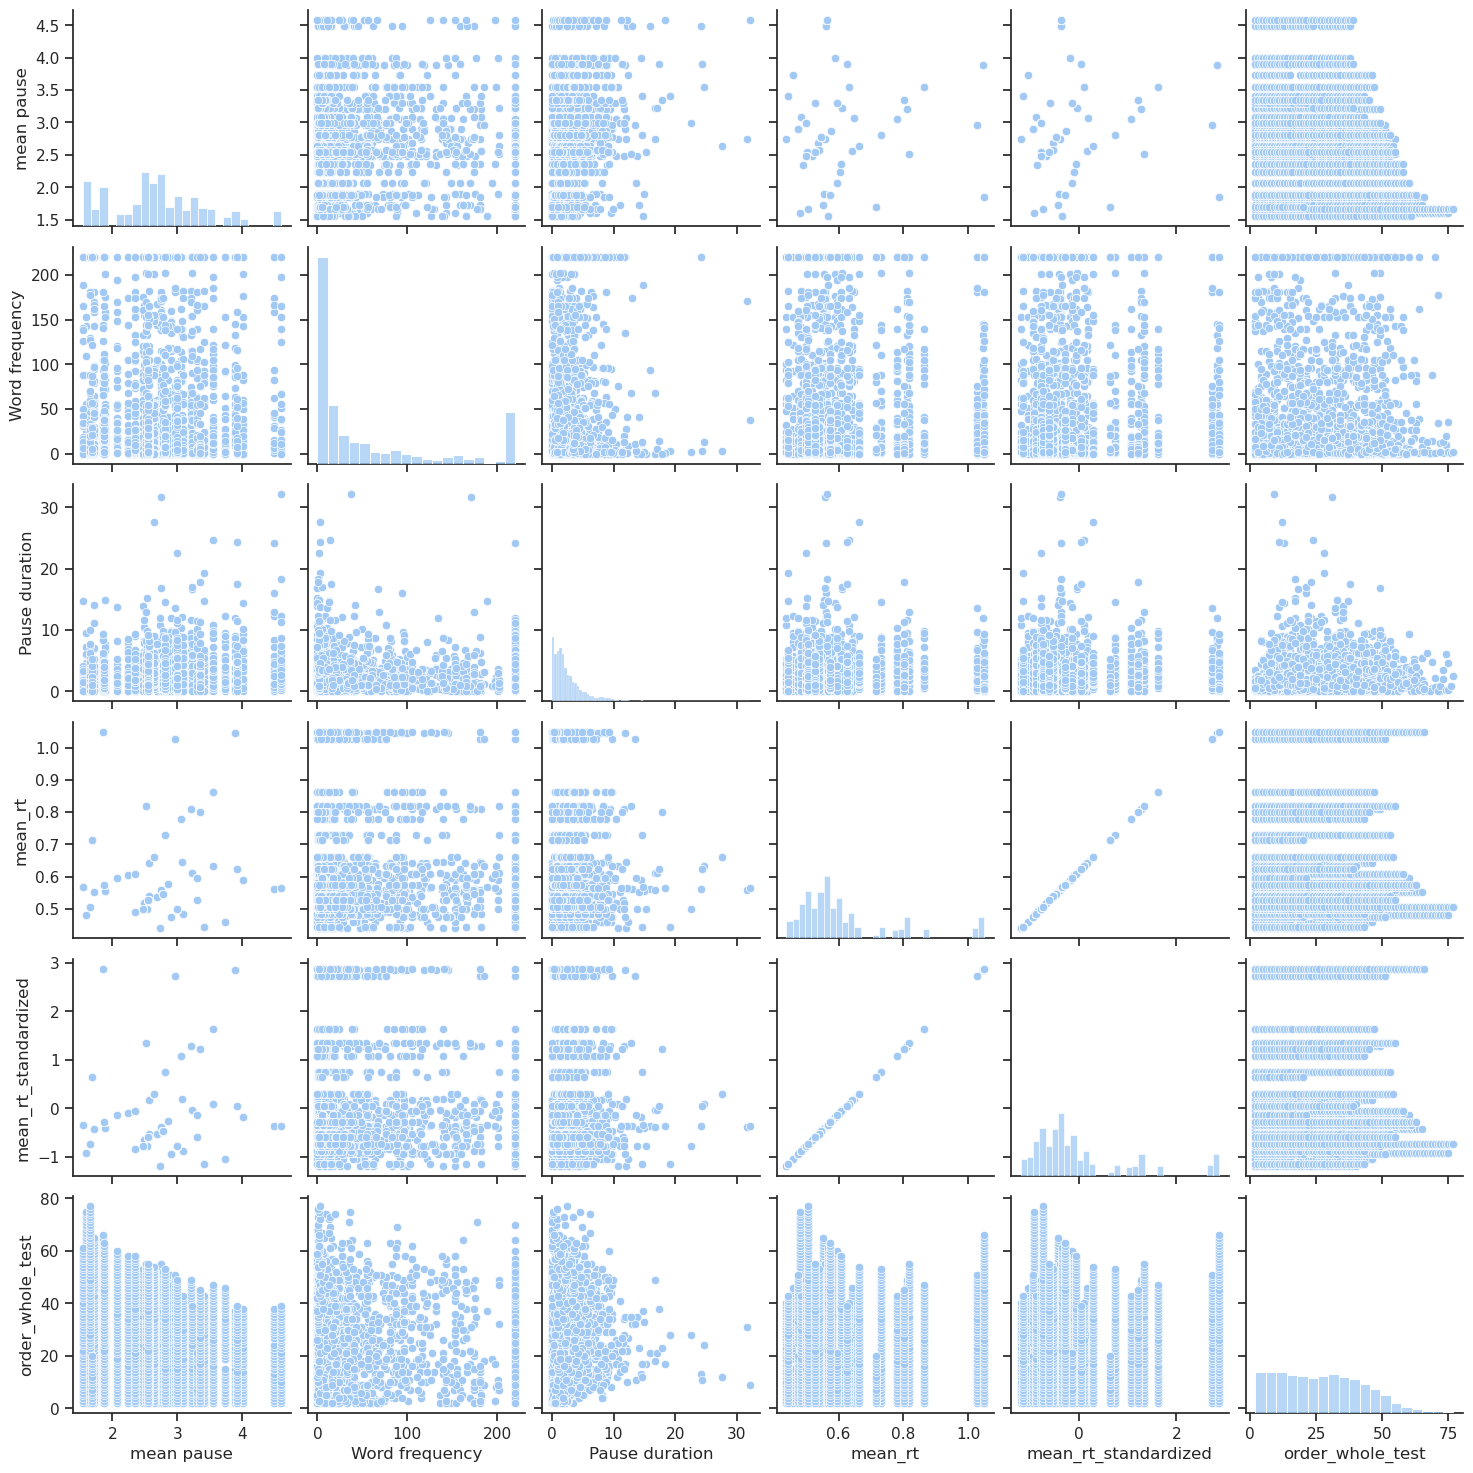

In [120]:
# fig, ax = plt.subplots(dpi=300)
ax = sns.pairplot(rt_for_cor[['mean pause', 
       'Word frequency', 'Pause duration', 'mean_rt', 
       'mean_rt_standardized', 'order_letter', 'order_whole_test']]);
ax.savefig(f'figures/pairplot.png', bbox_inches='tight')

In [304]:
# sns.lineplot(data=rt_for_cor, y='order_letter', x='Pause duration')

In [305]:
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='Pause duration')
# sns.lineplot(data=rt_for_cor, x='mean_rt', y='mean pause')

# Result table fix

## 1

In [201]:
paper_table = paper_table.drop_duplicates(subset=['Variable'], keep='last')

In [202]:
strategies_dict

{'phonetic strategy': 'S1',
 'derivative strategy': 'S2',
 'semantic-field strategy': 'S3',
 'individual association strategy': 'S4'}

In [203]:
final_paper_table = paper_table.copy()

In [213]:
# final_paper_table

In [204]:
final_paper_table['Variable'] = (paper_table['Variable'].str.replace('phonetic strategy', 'S1')
 .str.replace('derivative strategy', 'S2')
 .str.replace('semantic-field strategy', 'S3')
 .str.replace('individual association strategy', 'S4')
)

In [211]:
final_paper_table['Statistical test']=(final_paper_table['Normal sampling distribution']
                                       .apply(lambda x: 'Two-Sample two-tailed t-Test' if x else 'Mann–Whitney U test'))

In [219]:
final_paper_table['Statistical test'] = final_paper_table.apply(
    lambda x: 'Two-Sample one-tailed t-Test' if 'one-side' in x['Variable'] else x['Statistical test'],
    axis=1
)

In [213]:
round(0.616638, 4)

0.6166

In [223]:
def pround(x):
    return f'{round(float(x),4):.3g}' if (float(x)>0.0001) else x

In [224]:
final_paper_table['Permutation test p value corrected'] = final_paper_table['Permutation test p value corrected'].apply(lambda x:pround(x))
final_paper_table['Stat p value corrected'] = final_paper_table['Stat p value corrected'].apply(lambda x:pround(x))

In [226]:
final_paper_table.drop(['Permutation test p value', 'Stat p value'], axis=1)

,Variable,Normal sampling distribution,H0 CI,Delta observed,Cohens delta,Permutation test p value corrected,Stat metric value,Stat p value corrected,Statistical test
0,Fraction of S1,True,"[-3.0, 3.01]",-5.71,-0.76,0.0,-2.75,0.0097,Two-Sample two-tailed t-Test
1,Fraction of S2,True,"[-3.07, 3.1]",1.21,0.15,0.445,0.53,0.617,Two-Sample two-tailed t-Test
2,Fraction of S3,True,"[-3.38, 3.29]",-7.24,-0.88,0.0,-3.15,0.0062,Two-Sample two-tailed t-Test
3,Fraction of S4,True,"[-5.22, 5.04]",11.74,0.97,0.0,3.52,0.0044,Two-Sample two-tailed t-Test
4,Pause duration of S4,True,"[-5.22, 5.04]",11.74,0.97,0.0,3.52,0.0,Two-Sample two-tailed t-Test
5,Pause duration of S1,False,"[-0.59, 0.62]",-0.86,-0.26,0.009,5766.50,0.0321,Mann–Whitney U test
6,Pause duration of S2,False,"[-0.55, 0.54]",1.01,0.38,0.0,5101.00,0.0321,Mann–Whitney U test
7,Pause duration of S3,True,"[-0.29, 0.29]",-0.09,-0.04,0.565,-0.42,0.683,Two-Sample two-tailed t-Test
8,Pause duration of S4,True,"[-0.22, 0.22]",0.13,0.04,0.363,0.80,0.557,Two-Sample two-tailed t-Test
9,Word frequency of S1,True,"[-13.95, 14.61]",4.48,0.06,0.538,0.45,0.651,Two-Sample two-tailed t-Test


In [227]:
final_paper_table.to_csv('results/paper_table.csv', index=False, sep=';')

In [228]:
# final_paper_table.to_excel('results/paper_table.xlsx', index=False)

## 2

In [246]:
# final_paper_table = pd.read_excel('results/paper_table.xlsx')
# final_paper_table = pd.read_csv('results/paper_table.csv', sep=';')
# final_paper_table

In [ ]:
paper_table2_desc = word_counts.sort_values(['type', 'quota sec']) \
    .groupby(['type', 'quota sec'], as_index=False)['word'] \
    .agg(
        Q1=lambda x: x.quantile(0.25),
        Median=lambda x: x.quantile(0.5),
        Q3=lambda x: x.quantile(0.75)
    )


In [230]:
paper_table2 = pd.DataFrame(columns=['Hypothesis', 'Normal distribution' 
                                     , 'Statistical test'
                                     , 'H0 rejected'
                                    , 'Stat p value corrected',
                                    ])
paper_table2

,Hypothesis,Normal distribution,Statistical test,H0 rejected,Stat p value corrected


In [231]:
def pround(x):
    return f'{round(x,4):.3g}' if (x>0.0001) else x

In [232]:
paper_table2.loc[len(paper_table2)] = ['T1 between students and academics'
                                       , False
                                       , 'Mann–Whitney U test'
                                       , tertiles_corrected[0][0]
                                       , pround(tertiles_corrected[1][0])
                                       ]
paper_table2.loc[len(paper_table2)] = ['T2 between students and academics'
                                       , False
                                       , 'Mann–Whitney U test'
                                       , tertiles_corrected[0][1]
                                       , pround(tertiles_corrected[1][1])
                                       ]
paper_table2.loc[len(paper_table2)] = ['T3 between students and academics'
                                       , False
                                       , 'Mann–Whitney U test'
                                       , tertiles_corrected[0][2]
                                       , pround(tertiles_corrected[1][2])
                                       ]

paper_table2.loc[len(paper_table2)] = ['Students (T1 vs T2)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , stud_tertiles_corrected[0][0]
                                       , pround(stud_tertiles_corrected[1][0])
                                       ]
paper_table2.loc[len(paper_table2)] = ['Students (T2 vs T3)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , stud_tertiles_corrected[0][1]
                                       , pround(stud_tertiles_corrected[1][1])
                                       ]
paper_table2.loc[len(paper_table2)] = ['Students (T1 vs T3)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , stud_tertiles_corrected[0][2]
                                       , pround(stud_tertiles_corrected[1][2])
                                       ]

paper_table2.loc[len(paper_table2)] = ['Senior academics (T1 vs T2)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , prof_tertiles_corrected[0][0]
                                       , pround(prof_tertiles_corrected[1][0])
                                       ]
paper_table2.loc[len(paper_table2)] = ['Senior academics (T2 vs T3)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , prof_tertiles_corrected[0][1]
                                       , pround(prof_tertiles_corrected[1][1])
                                       ]
paper_table2.loc[len(paper_table2)] = ['Senior academics (T1 vs T3)'
                                       , False
                                       , 'Wilcoxon signed-rank test'
                                       , prof_tertiles_corrected[0][2]
                                       , pround(prof_tertiles_corrected[1][2])
                                       ]

In [275]:
paper_table2_desc.columns = ['group', 'T', 'Q1', 'Q2', 'Q3']
paper_table2_desc['T'] = 'T'+ paper_table2_desc['T'].astype('str')
paper_table2_desc

,group,T,Q1,Q2,Q3
0,senior academics,T1,20.00,22.0,24.0
1,senior academics,T2,11.75,15.5,18.0
2,senior academics,T3,13.50,15.0,18.5
3,students,T1,20.00,22.0,24.0
4,students,T2,12.00,14.0,16.0
5,students,T3,9.00,10.0,13.0


In [276]:
paper_table2

,Hypothesis,Normal distribution,Statistical test,H0 rejected,Stat p value corrected
0,T1 between students and academics,False,Mann–Whitney U test,False,0.832
1,T2 between students and academics,False,Mann–Whitney U test,False,0.598
2,T3 between students and academics,False,Mann–Whitney U test,True,0.000065
3,Students (T1 vs T2),False,Wilcoxon signed-rank test,True,0.000012
4,Students (T2 vs T3),False,Wilcoxon signed-rank test,True,0.0024
5,Students (T1 vs T3),False,Wilcoxon signed-rank test,True,0.0
6,Senior academics (T1 vs T2),False,Wilcoxon signed-rank test,True,0.0012
7,Senior academics (T2 vs T3),False,Wilcoxon signed-rank test,False,0.242
8,Senior academics (T1 vs T3),False,Wilcoxon signed-rank test,True,0.0063


In [234]:
# Convert the nested dictionary to a DataFrame
rows = []
for group in results:
    for strategy in results[group]:
        for comparison in results[group][strategy]:
            row = {
                'group': group,
                'strategy': strategy,
                'comparison': comparison,
                **results[group][strategy][comparison]
            }
            rows.append(row)

# Create DataFrame
df_results = pd.DataFrame(rows)

# Reorder columns for better readability
column_order = [
    'group',
    'strategy',
    'comparison',
    'statistic',
    'pvalue',
    'pvalue_corrected',
    'error'
]
df_results = df_results[column_order]

# Add significance markers
df_results['significance'] = df_results['pvalue_corrected'].apply(
    lambda x: '***' if x < 0.001 else '**' if x < 0.01 else '*' if x < 0.05 else 'ns' if pd.notnull(x) else ''
)

# Format numeric columns
df_results['pvalue'] = df_results['pvalue'].apply(lambda x: f"{x:.3g}" if pd.notnull(x) else '')
df_results['pvalue_corrected'] = df_results['pvalue_corrected'].apply(lambda x: f"{x:.3g}" if pd.notnull(x) else '')
df_results = df_results.drop('error', axis=1)


In [279]:
df_results['Statistical test'] = 'Wilcoxon signed-rank test'

In [236]:
paper_table2.to_csv('results/paper_table2.csv', index=False, sep=';')

In [277]:
paper_table2_desc.to_csv('results/paper_table2_descroptive.csv', index=False, sep=';')

In [285]:
df_results_descriptive = (t_strats_wcounts.sort_values(['strategy_paper_name','quota sec', 'type'])
.groupby(['strategy_paper_name','quota sec', 'type'], as_index=False)['word']
.agg(
        Q1=lambda x: x.quantile(0.25),
        Median=lambda x: x.quantile(0.5),
        Q3=lambda x: x.quantile(0.75)
    )
)
df_results_descriptive.columns = ['Strategy', 'T', 'group','Q1', 'Q2', 'Q3']
df_results_descriptive['T'] = 'T'+ df_results_descriptive['T'].astype('str')
df_results_descriptive

,Strategy,T,group,Q1,Q2,Q3
0,S1,T1,senior academics,2.0,3.5,5.00
1,S1,T1,students,1.0,2.0,3.00
2,S1,T2,senior academics,1.0,2.0,3.00
3,S1,T2,students,1.0,2.0,2.00
4,S1,T3,senior academics,1.0,2.0,4.00
5,S1,T3,students,1.0,1.5,2.00
6,S2,T1,senior academics,1.5,2.0,3.50
7,S2,T1,students,1.0,1.0,2.00
8,S2,T2,senior academics,1.0,1.0,4.50
9,S2,T2,students,1.0,1.5,3.25


In [286]:
df_results.to_csv('results/paper_table3.csv', index=False, sep=';')
df_results_descriptive.to_csv('results/paper_table3_descriptive.csv', index=False, sep=';')

## 3

In [238]:
strats_.head()

,ID,phonetic strategy,derivative strategy,semantic-field strategy,individual association strategy,type
0,pr_A_1,22.727273,11.363636,29.545455,36.363636,senior academics
1,pr_B_1,19.607843,5.882353,31.372549,43.137255,senior academics
2,pr_E_1,9.615385,1.923077,19.230769,69.230769,senior academics
3,pr_G_1,25.454545,1.818182,12.727273,60.000000,senior academics
4,pr_I_1,8.333333,2.083333,18.750000,70.833333,senior academics


In [287]:
final_desc_stats = desc_stats.drop_duplicates(subset=['Variable', 'type/group'], keep='last').round(2)
final_desc_stats

,Variable,type/group,Expected mean diffs are normal distributed,mean,std,median,Q1,Q3
0,Fraction of phonetic strategy,students,True,7.54,5.13,7.50,4.35,10.91
1,Fraction of phonetic strategy,senior academics,True,13.24,9.11,9.80,5.56,22.73
0,Fraction of derivative strategy,students,True,7.52,5.36,7.50,2.82,11.36
1,Fraction of derivative strategy,senior academics,True,6.31,10.14,1.92,0.00,7.69
0,Fraction of semantic-field strategy,students,True,16.28,4.35,16.67,13.92,18.61
1,Fraction of semantic-field strategy,senior academics,True,23.53,10.72,22.22,14.86,30.91
0,Fraction of individual association strategy,students,True,68.66,8.90,70.27,62.50,73.94
1,Fraction of individual association strategy,senior academics,True,56.92,14.32,57.89,47.92,66.67
0,Pause duration of S1,students,False,1.74,1.89,1.27,0.57,2.13
1,Pause duration of S1,senior academics,False,2.60,3.88,1.59,0.90,2.64


In [288]:
final_desc_stats.to_csv('results/descriptive_paper_table1.csv', index=False, sep=';')